In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')

# Imports

In [2]:
import GPyOpt
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import mean_absolute_error

from src import models
from src import experimental_setup

# Experimental setup

In [3]:
identity = 'dnn_mordred'
encoding = 'mordred'

kfold = experimental_setup.CrossValidator(
    splits = 5,
    sampling_type = 'random',
)

# Define search region

bounds = [
    {'name': "learning_rate", 'type': 'continuous', 'domain': (0.0001,0.01)},
    {'name': "n_layers",      'type': 'discrete',   'domain': range(1,6)},
    {'name': 'layer_size',    'type': 'discrete',   'domain': [32,64,128,256,512,1024,2048,4096]},
    {'name': 'batch_size',    'type': 'discrete',   'domain': [32,64,128,256,512,1024,2048,4096]}
]

# Optimization candidate

In [4]:
# globally referenced in search; remain calm
best = {'score': np.inf, 'history': None}

def search(x):
    errors = []
    
    
    for fold_no, (train, test) in enumerate(kfold.get_folds(encoding)):
        x_train, y_train, smiles_train = train
        x_test, y_test, smiles_test = test
        
        y_train = experimental_setup.scaler.fit_transform(y_train)
        y_test = experimental_setup.scaler.transform(y_test)
        
        model = models.DNN()
        
        model.learning_rate = float(x[:,0])
        model.n_layers = int(x[:,1])
        model.layer_size = int(x[:,2])
        model.batch_size = int(x[:,3])
        model.epochs = 3000
        
        early_stopping = tf.keras.callbacks.EarlyStopping(patience=10,
                                                          monitor='val_loss',
                                                          mode='min',
                                                          restore_best_weights=True)
        
        model.fit(x_train.astype(np.float32), y_train,
                  callbacks=[early_stopping],
                  validation_data=(x_test.astype(np.float32), y_test),
                  verbose=1)
        
        y_hat = experimental_setup.scaler.inverse_transform(model.predict(x_test))
        y_test = experimental_setup.scaler.inverse_transform(y_test)
        
        errors.append( mean_absolute_error(y_test.flatten(), y_hat.flatten()) )
    
    score = np.mean(errors)
    
    # save model for final fold if score is best
    global best
    
    if score < best['score']:
        best['score'] = score
        best['history'] = model.history
    
    print('Avg. MAE: %f' % score)    
    
    return score

# Tune
To see exploration, <kbd>Ctrl</kbd> + <kbd>F</kbd> for "Avg. MAE"

In [5]:
print("Begin processing!")

np.random.seed(9700)
optimizer = GPyOpt.methods.BayesianOptimization(f=search, domain=bounds,
                model_type='GP',
                acquisition_type ='EI',
                acquisition_jitter = 0.05,
                exact_feval = True,
                num_cores = 40, # Adjust 
                maximize = False,
                verbosity = True)

print("Starting Optimizer!")
optimizer.run_optimization(max_iter=40)

print("Finished Optimization!")

Begin processing!
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 5s 454us/sample - loss: 1.0197 - mse: 1.0197 - mae: 0.7331 - val_loss: 1.2728 - val_mse: 1.2728 - val_mae: 0.8968
Epoch 2/3000
10663/10663 [==============================] - 1s 58us/sample - loss: 0.4988 - mse: 0.4988 - mae: 0.5295 - val_loss: 1.0341 - val_mse: 1.0341 - val_mae: 0.8045
Epoch 3/3000
10663/10663 [==============================] - 1s 58us/sample - loss: 0.4357 - mse: 0.4357 - mae: 0.4928 - val_loss: 1.0004 - val_mse: 1.0004 - val_mae: 0.8064
Epoch 4/3000
10663/10663 [==============================] - 1s 59us/sample - loss: 0.4303 - mse: 0.4303 - mae: 0.4906 - val_loss: 0.6896 - val_mse: 0.6896 - val_mae: 0.6688
Epoch 5/3000
10663/10663 [==============================] - 1s 87us/sample - loss: 0.3704 - mse: 0.3704 - mae: 0.4549 - val_loss: 0.6491 - val_mse: 0.6491 - val_mae: 0.6427
Epoch 6/3000
10663/10663 [==============================] - 1s 59us

10663/10663 [==============================] - 1s 61us/sample - loss: 0.2816 - mse: 0.2816 - mae: 0.4009 - val_loss: 0.5829 - val_mse: 0.5829 - val_mae: 0.5226
Epoch 10/3000
10663/10663 [==============================] - 1s 55us/sample - loss: 0.2816 - mse: 0.2816 - mae: 0.3988 - val_loss: 0.4466 - val_mse: 0.4466 - val_mae: 0.4860
Epoch 11/3000
10663/10663 [==============================] - 1s 55us/sample - loss: 0.2465 - mse: 0.2465 - mae: 0.3743 - val_loss: 0.4560 - val_mse: 0.4560 - val_mae: 0.4867
Epoch 12/3000
10663/10663 [==============================] - 1s 48us/sample - loss: 0.2448 - mse: 0.2448 - mae: 0.3730 - val_loss: 0.4596 - val_mse: 0.4596 - val_mae: 0.4853
Epoch 13/3000
10663/10663 [==============================] - 1s 52us/sample - loss: 0.2386 - mse: 0.2386 - mae: 0.3724 - val_loss: 0.4903 - val_mse: 0.4903 - val_mae: 0.4797
Epoch 14/3000
10663/10663 [==============================] - 1s 54us/sample - loss: 0.2317 - mse: 0.2317 - mae: 0.3638 - val_loss: 0.4909 - val_

Epoch 21/3000
10663/10663 [==============================] - 1s 63us/sample - loss: 0.1857 - mse: 0.1857 - mae: 0.3283 - val_loss: 0.4256 - val_mse: 0.4256 - val_mae: 0.4681
Epoch 22/3000
10663/10663 [==============================] - 1s 61us/sample - loss: 0.1725 - mse: 0.1725 - mae: 0.3167 - val_loss: 0.4229 - val_mse: 0.4229 - val_mae: 0.4730
Epoch 23/3000
10663/10663 [==============================] - 1s 57us/sample - loss: 0.1685 - mse: 0.1685 - mae: 0.3127 - val_loss: 0.4276 - val_mse: 0.4276 - val_mae: 0.4702
Epoch 24/3000
10663/10663 [==============================] - 1s 54us/sample - loss: 0.1620 - mse: 0.1620 - mae: 0.3051 - val_loss: 0.4149 - val_mse: 0.4149 - val_mae: 0.4775
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 4s 363us/sample - loss: 0.9745 - mse: 0.9745 - mae: 0.7236 - val_loss: 1.4502 - val_mse: 1.4502 - val_mae: 0.8821
Epoch 2/3000
10663/10663 [==============================] - 1s 53us/sample - loss

10664/10664 [==============================] - 1s 50us/sample - loss: 0.1969 - mse: 0.1969 - mae: 0.3378 - val_loss: 0.4424 - val_mse: 0.4424 - val_mae: 0.4780
Epoch 19/3000
10664/10664 [==============================] - 1s 53us/sample - loss: 0.1894 - mse: 0.1894 - mae: 0.3305 - val_loss: 0.4130 - val_mse: 0.4130 - val_mae: 0.4529
Epoch 20/3000
10664/10664 [==============================] - 1s 50us/sample - loss: 0.1756 - mse: 0.1756 - mae: 0.3184 - val_loss: 0.4262 - val_mse: 0.4262 - val_mae: 0.4645
Epoch 21/3000
10664/10664 [==============================] - 1s 53us/sample - loss: 0.1741 - mse: 0.1741 - mae: 0.3164 - val_loss: 0.4165 - val_mse: 0.4165 - val_mae: 0.4582
Epoch 22/3000
10664/10664 [==============================] - 1s 54us/sample - loss: 0.1762 - mse: 0.1762 - mae: 0.3191 - val_loss: 0.4153 - val_mse: 0.4153 - val_mae: 0.4684
Epoch 23/3000
10664/10664 [==============================] - 1s 50us/sample - loss: 0.1662 - mse: 0.1662 - mae: 0.3085 - val_loss: 0.4381 - val_

10663/10663 [==============================] - 45s 4ms/sample - loss: 1.2713 - mse: 1.2713 - mae: 0.7984 - val_loss: 303.2392 - val_mse: 303.2392 - val_mae: 14.6382
Epoch 28/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 1.4184 - mse: 1.4184 - mae: 0.7771 - val_loss: 250.5364 - val_mse: 250.5364 - val_mae: 13.4968
Epoch 29/3000
10663/10663 [==============================] - 46s 4ms/sample - loss: 1.1615 - mse: 1.1615 - mae: 0.7667 - val_loss: 130.3181 - val_mse: 130.3181 - val_mae: 10.5232
Epoch 30/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 1.5495 - mse: 1.5495 - mae: 0.8202 - val_loss: 180.7640 - val_mse: 180.7640 - val_mae: 11.6093
Epoch 31/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 1.1004 - mse: 1.1004 - mae: 0.7505 - val_loss: 129.7849 - val_mse: 129.7849 - val_mae: 10.0527
Epoch 32/3000
10663/10663 [==============================] - 46s 4ms/sample - loss: 1.0378 - mse: 1.0378 - mae: 0.7305 

Epoch 74/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.7739 - mse: 0.7739 - mae: 0.6483 - val_loss: 3.0896 - val_mse: 3.0896 - val_mae: 1.5688
Epoch 75/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.7280 - mse: 0.7280 - mae: 0.6333 - val_loss: 3.4209 - val_mse: 3.4209 - val_mae: 1.5939
Epoch 76/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.7814 - mse: 0.7814 - mae: 0.6450 - val_loss: 2.7456 - val_mse: 2.7456 - val_mae: 1.4621
Epoch 77/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.6913 - mse: 0.6913 - mae: 0.6170 - val_loss: 3.0457 - val_mse: 3.0457 - val_mae: 1.5267
Epoch 78/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.7691 - mse: 0.7691 - mae: 0.6402 - val_loss: 2.5366 - val_mse: 2.5366 - val_mae: 1.4076
Epoch 79/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.7717 - mse: 0.7717 - mae: 0.6467 - val_loss:

Epoch 121/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.5499 - mse: 0.5499 - mae: 0.5509 - val_loss: 0.6995 - val_mse: 0.6995 - val_mae: 0.6651
Epoch 122/3000
10663/10663 [==============================] - 46s 4ms/sample - loss: 0.5689 - mse: 0.5689 - mae: 0.5580 - val_loss: 0.6714 - val_mse: 0.6714 - val_mae: 0.6388
Epoch 123/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.5522 - mse: 0.5522 - mae: 0.5539 - val_loss: 0.7041 - val_mse: 0.7041 - val_mae: 0.6700
Epoch 124/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.5467 - mse: 0.5467 - mae: 0.5470 - val_loss: 0.6786 - val_mse: 0.6786 - val_mae: 0.6451
Epoch 125/3000
10663/10663 [==============================] - 46s 4ms/sample - loss: 0.5371 - mse: 0.5371 - mae: 0.5390 - val_loss: 0.6606 - val_mse: 0.6606 - val_mae: 0.6330
Epoch 126/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.5209 - mse: 0.5209 - mae: 0.5368 - val

Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 47s 4ms/sample - loss: 1827.5098 - mse: 1827.5099 - mae: 22.9592 - val_loss: 6201091072.0000 - val_mse: 6201091072.0000 - val_mae: 60945.9609
Epoch 2/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 125.5171 - mse: 125.5171 - mae: 7.2493 - val_loss: 290137568.0000 - val_mse: 290137568.0000 - val_mae: 13393.3936
Epoch 3/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 165.9626 - mse: 165.9626 - mae: 9.2659 - val_loss: 10733779.0000 - val_mse: 10733779.0000 - val_mae: 2842.8032
Epoch 4/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 28.4249 - mse: 28.4249 - mae: 4.0175 - val_loss: 18636576.0000 - val_mse: 18636576.0000 - val_mae: 2527.4568
Epoch 5/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 41.7715 - mse: 41.7715 - mae: 4.2811 - val_loss: 4882698.0000 - val_mse: 4882698.00

10663/10663 [==============================] - 45s 4ms/sample - loss: 0.8005 - mse: 0.8005 - mae: 0.6798 - val_loss: 8.7543 - val_mse: 8.7543 - val_mae: 2.6965
Epoch 47/3000
10663/10663 [==============================] - 46s 4ms/sample - loss: 0.8119 - mse: 0.8119 - mae: 0.6855 - val_loss: 7.6467 - val_mse: 7.6467 - val_mae: 2.5547
Epoch 48/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.7777 - mse: 0.7777 - mae: 0.6730 - val_loss: 7.8629 - val_mse: 7.8629 - val_mae: 2.5180
Epoch 49/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.8112 - mse: 0.8112 - mae: 0.6814 - val_loss: 7.0427 - val_mse: 7.0427 - val_mae: 2.4286
Epoch 50/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.7942 - mse: 0.7942 - mae: 0.6798 - val_loss: 6.2643 - val_mse: 6.2643 - val_mae: 2.2747
Epoch 51/3000
10663/10663 [==============================] - 46s 4ms/sample - loss: 0.8084 - mse: 0.8084 - mae: 0.6799 - val_loss: 5.7898 - val_

10663/10663 [==============================] - 45s 4ms/sample - loss: 0.6710 - mse: 0.6710 - mae: 0.6143 - val_loss: 0.8841 - val_mse: 0.8841 - val_mae: 0.7668
Epoch 94/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.6634 - mse: 0.6634 - mae: 0.6111 - val_loss: 0.9016 - val_mse: 0.9016 - val_mae: 0.7767
Epoch 95/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.6665 - mse: 0.6665 - mae: 0.6161 - val_loss: 0.8466 - val_mse: 0.8466 - val_mae: 0.7393
Epoch 96/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.6768 - mse: 0.6768 - mae: 0.6185 - val_loss: 0.8180 - val_mse: 0.8180 - val_mae: 0.7172
Epoch 97/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.6631 - mse: 0.6631 - mae: 0.6061 - val_loss: 0.8863 - val_mse: 0.8863 - val_mae: 0.7740
Epoch 98/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.6580 - mse: 0.6580 - mae: 0.6123 - val_loss: 0.8044 - val_

Epoch 140/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.5179 - mse: 0.5179 - mae: 0.5371 - val_loss: 0.7459 - val_mse: 0.7459 - val_mae: 0.6011
Epoch 141/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.5216 - mse: 0.5216 - mae: 0.5310 - val_loss: 0.6494 - val_mse: 0.6494 - val_mae: 0.6010
Epoch 142/3000
10663/10663 [==============================] - 46s 4ms/sample - loss: 0.5110 - mse: 0.5110 - mae: 0.5343 - val_loss: 0.6342 - val_mse: 0.6342 - val_mae: 0.5708
Epoch 143/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.5097 - mse: 0.5097 - mae: 0.5341 - val_loss: 0.6851 - val_mse: 0.6851 - val_mae: 0.5850
Epoch 144/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.5036 - mse: 0.5036 - mae: 0.5245 - val_loss: 0.6501 - val_mse: 0.6501 - val_mae: 0.5816
Epoch 145/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.4817 - mse: 0.4817 - mae: 0.5148 - val

10663/10663 [==============================] - 46s 4ms/sample - loss: 1.0295 - mse: 1.0295 - mae: 0.7297 - val_loss: 309.1782 - val_mse: 309.1782 - val_mae: 15.2396
Epoch 26/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 1.0299 - mse: 1.0299 - mae: 0.7621 - val_loss: 278.5768 - val_mse: 278.5768 - val_mae: 14.4360
Epoch 27/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 1.0086 - mse: 1.0086 - mae: 0.7325 - val_loss: 249.8628 - val_mse: 249.8628 - val_mae: 13.7164
Epoch 28/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.9284 - mse: 0.9284 - mae: 0.7147 - val_loss: 166.4733 - val_mse: 166.4733 - val_mae: 11.6435
Epoch 29/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.9383 - mse: 0.9383 - mae: 0.7098 - val_loss: 160.4077 - val_mse: 160.4077 - val_mae: 11.3133
Epoch 30/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.9489 - mse: 0.9489 - mae: 0.7213 

Epoch 72/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.7717 - mse: 0.7717 - mae: 0.6554 - val_loss: 2.7751 - val_mse: 2.7751 - val_mae: 1.4936
Epoch 73/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.7129 - mse: 0.7129 - mae: 0.6319 - val_loss: 3.0668 - val_mse: 3.0668 - val_mae: 1.5530
Epoch 74/3000
10663/10663 [==============================] - 46s 4ms/sample - loss: 0.7559 - mse: 0.7559 - mae: 0.6443 - val_loss: 2.3791 - val_mse: 2.3791 - val_mae: 1.3720
Epoch 75/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.7517 - mse: 0.7517 - mae: 0.6409 - val_loss: 2.5784 - val_mse: 2.5784 - val_mae: 1.4334
Epoch 76/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.7290 - mse: 0.7290 - mae: 0.6325 - val_loss: 2.3627 - val_mse: 2.3627 - val_mae: 1.3714
Epoch 77/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.7550 - mse: 0.7550 - mae: 0.6435 - val_loss:

Epoch 119/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.6025 - mse: 0.6025 - mae: 0.5749 - val_loss: 0.6962 - val_mse: 0.6962 - val_mae: 0.6462
Epoch 120/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.5948 - mse: 0.5948 - mae: 0.5711 - val_loss: 0.6776 - val_mse: 0.6776 - val_mae: 0.6331
Epoch 121/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.5882 - mse: 0.5882 - mae: 0.5643 - val_loss: 0.7248 - val_mse: 0.7248 - val_mae: 0.6769
Epoch 122/3000
10663/10663 [==============================] - 46s 4ms/sample - loss: 0.5904 - mse: 0.5904 - mae: 0.5705 - val_loss: 0.6732 - val_mse: 0.6732 - val_mae: 0.6337
Epoch 123/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.5775 - mse: 0.5775 - mae: 0.5641 - val_loss: 0.6897 - val_mse: 0.6897 - val_mae: 0.6443
Epoch 124/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.5716 - mse: 0.5716 - mae: 0.5579 - val

Epoch 166/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.3722 - mse: 0.3722 - mae: 0.4517 - val_loss: 0.5247 - val_mse: 0.5247 - val_mae: 0.5233
Epoch 167/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.3596 - mse: 0.3596 - mae: 0.4448 - val_loss: 0.5922 - val_mse: 0.5922 - val_mae: 0.5518
Epoch 168/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.3398 - mse: 0.3398 - mae: 0.4359 - val_loss: 0.6070 - val_mse: 0.6070 - val_mae: 0.5557
Epoch 169/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.3491 - mse: 0.3491 - mae: 0.4409 - val_loss: 0.6099 - val_mse: 0.6099 - val_mae: 0.5653
Epoch 170/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.3406 - mse: 0.3406 - mae: 0.4374 - val_loss: 0.5131 - val_mse: 0.5131 - val_mae: 0.5209
Epoch 171/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.3311 - mse: 0.3311 - mae: 0.4309 - val

10663/10663 [==============================] - 45s 4ms/sample - loss: 1.4861 - mse: 1.4861 - mae: 0.8590 - val_loss: 299.3113 - val_mse: 299.3113 - val_mae: 14.9533
Epoch 26/3000
10663/10663 [==============================] - 46s 4ms/sample - loss: 0.8817 - mse: 0.8817 - mae: 0.7119 - val_loss: 375.9727 - val_mse: 375.9727 - val_mae: 15.9973
Epoch 27/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 1.2403 - mse: 1.2403 - mae: 0.7632 - val_loss: 235.3352 - val_mse: 235.3352 - val_mae: 13.2850
Epoch 28/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.9795 - mse: 0.9795 - mae: 0.7353 - val_loss: 133.5962 - val_mse: 133.5962 - val_mae: 10.5578
Epoch 29/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 1.0103 - mse: 1.0103 - mae: 0.7285 - val_loss: 189.5833 - val_mse: 189.5833 - val_mae: 11.7362
Epoch 30/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 1.4299 - mse: 1.4299 - mae: 0.7794 

Epoch 72/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.7269 - mse: 0.7269 - mae: 0.6421 - val_loss: 3.0389 - val_mse: 3.0389 - val_mae: 1.5547
Epoch 73/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.7116 - mse: 0.7116 - mae: 0.6299 - val_loss: 3.2796 - val_mse: 3.2796 - val_mae: 1.6153
Epoch 74/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.7197 - mse: 0.7197 - mae: 0.6286 - val_loss: 3.3778 - val_mse: 3.3778 - val_mae: 1.6534
Epoch 75/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.7150 - mse: 0.7150 - mae: 0.6411 - val_loss: 2.4959 - val_mse: 2.4959 - val_mae: 1.4041
Epoch 76/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.7121 - mse: 0.7121 - mae: 0.6233 - val_loss: 2.9954 - val_mse: 2.9954 - val_mae: 1.5406
Epoch 77/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.7048 - mse: 0.7048 - mae: 0.6281 - val_loss:

Epoch 119/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.6052 - mse: 0.6052 - mae: 0.5793 - val_loss: 0.7788 - val_mse: 0.7788 - val_mae: 0.7141
Epoch 120/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.6004 - mse: 0.6004 - mae: 0.5691 - val_loss: 0.8874 - val_mse: 0.8874 - val_mae: 0.7905
Epoch 121/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.6067 - mse: 0.6067 - mae: 0.5812 - val_loss: 0.7566 - val_mse: 0.7566 - val_mae: 0.7045
Epoch 122/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.5914 - mse: 0.5914 - mae: 0.5708 - val_loss: 0.7897 - val_mse: 0.7897 - val_mae: 0.7276
Epoch 123/3000
10663/10663 [==============================] - 46s 4ms/sample - loss: 0.5984 - mse: 0.5984 - mae: 0.5763 - val_loss: 0.7654 - val_mse: 0.7654 - val_mae: 0.7141
Epoch 124/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.5823 - mse: 0.5823 - mae: 0.5661 - val

Epoch 166/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.4411 - mse: 0.4411 - mae: 0.4908 - val_loss: 0.6323 - val_mse: 0.6323 - val_mae: 0.6168
Epoch 167/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.4256 - mse: 0.4256 - mae: 0.4802 - val_loss: 0.5986 - val_mse: 0.5986 - val_mae: 0.5971
Epoch 168/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.4259 - mse: 0.4259 - mae: 0.4842 - val_loss: 0.6179 - val_mse: 0.6179 - val_mae: 0.6059
Epoch 169/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.4285 - mse: 0.4285 - mae: 0.4774 - val_loss: 0.5984 - val_mse: 0.5984 - val_mae: 0.5890
Epoch 170/3000
10663/10663 [==============================] - 45s 4ms/sample - loss: 0.4099 - mse: 0.4099 - mae: 0.4705 - val_loss: 0.5999 - val_mse: 0.5999 - val_mae: 0.6074
Train on 10664 samples, validate on 2665 samples
Epoch 1/3000
10664/10664 [==============================] - 47s 4ms/sample -

10664/10664 [==============================] - 46s 4ms/sample - loss: 0.8201 - mse: 0.8201 - mae: 0.6894 - val_loss: 12.6433 - val_mse: 12.6433 - val_mae: 2.8994
Epoch 42/3000
10664/10664 [==============================] - 45s 4ms/sample - loss: 0.8102 - mse: 0.8102 - mae: 0.6738 - val_loss: 13.1242 - val_mse: 13.1242 - val_mae: 2.8924
Epoch 43/3000
10664/10664 [==============================] - 45s 4ms/sample - loss: 0.8037 - mse: 0.8037 - mae: 0.6874 - val_loss: 7.8685 - val_mse: 7.8685 - val_mae: 2.3612
Epoch 44/3000
10664/10664 [==============================] - 46s 4ms/sample - loss: 0.8237 - mse: 0.8237 - mae: 0.6769 - val_loss: 9.2886 - val_mse: 9.2886 - val_mae: 2.5946
Epoch 45/3000
10664/10664 [==============================] - 45s 4ms/sample - loss: 0.8172 - mse: 0.8172 - mae: 0.6869 - val_loss: 9.3414 - val_mse: 9.3414 - val_mae: 2.4469
Epoch 46/3000
10664/10664 [==============================] - 46s 4ms/sample - loss: 0.7957 - mse: 0.7957 - mae: 0.6794 - val_loss: 5.9021 - 

10664/10664 [==============================] - 45s 4ms/sample - loss: 0.6980 - mse: 0.6980 - mae: 0.6180 - val_loss: 1.1450 - val_mse: 1.1450 - val_mae: 0.8860
Epoch 89/3000
10664/10664 [==============================] - 45s 4ms/sample - loss: 0.6857 - mse: 0.6857 - mae: 0.6237 - val_loss: 0.9905 - val_mse: 0.9905 - val_mae: 0.8087
Epoch 90/3000
10664/10664 [==============================] - 46s 4ms/sample - loss: 0.7224 - mse: 0.7224 - mae: 0.6358 - val_loss: 0.8922 - val_mse: 0.8922 - val_mae: 0.7732
Epoch 91/3000
10664/10664 [==============================] - 45s 4ms/sample - loss: 0.6880 - mse: 0.6880 - mae: 0.6113 - val_loss: 1.0445 - val_mse: 1.0445 - val_mae: 0.8368
Epoch 92/3000
10664/10664 [==============================] - 45s 4ms/sample - loss: 0.6824 - mse: 0.6824 - mae: 0.6209 - val_loss: 0.7947 - val_mse: 0.7947 - val_mae: 0.7223
Epoch 93/3000
10664/10664 [==============================] - 45s 4ms/sample - loss: 0.6500 - mse: 0.6500 - mae: 0.6038 - val_loss: 1.0121 - val_

Epoch 9/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.3872 - mse: 0.3872 - mae: 0.4665 - val_loss: 0.9815 - val_mse: 0.9815 - val_mae: 0.7888
Epoch 10/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.3698 - mse: 0.3698 - mae: 0.4572 - val_loss: 0.9854 - val_mse: 0.9854 - val_mae: 0.7980
Epoch 11/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.3440 - mse: 0.3440 - mae: 0.4398 - val_loss: 0.9449 - val_mse: 0.9449 - val_mae: 0.7686
Epoch 12/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.3283 - mse: 0.3283 - mae: 0.4278 - val_loss: 0.9287 - val_mse: 0.9287 - val_mae: 0.7550
Epoch 13/3000
10663/10663 [==============================] - 0s 8us/sample - loss: 0.3181 - mse: 0.3181 - mae: 0.4210 - val_loss: 0.9207 - val_mse: 0.9207 - val_mae: 0.7570
Epoch 14/3000
10663/10663 [==============================] - 0s 8us/sample - loss: 0.2995 - mse: 0.2995 - mae: 0.4094 - val_loss: 0.9072

10663/10663 [==============================] - 0s 9us/sample - loss: 0.1175 - mse: 0.1175 - mae: 0.2592 - val_loss: 0.5455 - val_mse: 0.5455 - val_mae: 0.5524
Epoch 57/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.1144 - mse: 0.1144 - mae: 0.2575 - val_loss: 0.5281 - val_mse: 0.5281 - val_mae: 0.5389
Epoch 58/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.1078 - mse: 0.1078 - mae: 0.2485 - val_loss: 0.5113 - val_mse: 0.5113 - val_mae: 0.5308
Epoch 59/3000
10663/10663 [==============================] - 0s 8us/sample - loss: 0.1071 - mse: 0.1071 - mae: 0.2486 - val_loss: 0.5135 - val_mse: 0.5135 - val_mae: 0.5319
Epoch 60/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.1076 - mse: 0.1076 - mae: 0.2472 - val_loss: 0.5258 - val_mse: 0.5258 - val_mae: 0.5371
Epoch 61/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.1080 - mse: 0.1080 - mae: 0.2504 - val_loss: 0.5155 - val_mse: 0

10663/10663 [==============================] - 0s 9us/sample - loss: 0.4779 - mse: 0.4779 - mae: 0.5215 - val_loss: 1.0214 - val_mse: 1.0214 - val_mae: 0.7816
Epoch 7/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.4357 - mse: 0.4357 - mae: 0.4966 - val_loss: 1.0206 - val_mse: 1.0206 - val_mae: 0.7721
Epoch 8/3000
10663/10663 [==============================] - 0s 8us/sample - loss: 0.4094 - mse: 0.4094 - mae: 0.4795 - val_loss: 1.0109 - val_mse: 1.0109 - val_mae: 0.7674
Epoch 9/3000
10663/10663 [==============================] - 0s 8us/sample - loss: 0.3840 - mse: 0.3840 - mae: 0.4645 - val_loss: 1.0036 - val_mse: 1.0036 - val_mae: 0.7604
Epoch 10/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.3689 - mse: 0.3689 - mae: 0.4546 - val_loss: 1.0065 - val_mse: 1.0065 - val_mae: 0.7707
Epoch 11/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.3465 - mse: 0.3465 - mae: 0.4437 - val_loss: 1.0066 - val_mse: 1.00

10663/10663 [==============================] - 0s 10us/sample - loss: 0.1144 - mse: 0.1144 - mae: 0.2562 - val_loss: 0.5491 - val_mse: 0.5491 - val_mae: 0.5470
Epoch 54/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.1118 - mse: 0.1118 - mae: 0.2534 - val_loss: 0.5540 - val_mse: 0.5540 - val_mae: 0.5499
Epoch 55/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.1062 - mse: 0.1062 - mae: 0.2454 - val_loss: 0.5518 - val_mse: 0.5518 - val_mae: 0.5494
Epoch 56/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.1066 - mse: 0.1066 - mae: 0.2481 - val_loss: 0.5496 - val_mse: 0.5496 - val_mae: 0.5503
Epoch 57/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.1073 - mse: 0.1073 - mae: 0.2483 - val_loss: 0.5430 - val_mse: 0.5430 - val_mae: 0.5418
Epoch 58/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.1046 - mse: 0.1046 - mae: 0.2444 - val_loss: 0.5416 - val_mse: 

10663/10663 [==============================] - 0s 9us/sample - loss: 0.0718 - mse: 0.0718 - mae: 0.2035 - val_loss: 0.4899 - val_mse: 0.4899 - val_mae: 0.4992
Epoch 101/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.0702 - mse: 0.0702 - mae: 0.2015 - val_loss: 0.4834 - val_mse: 0.4834 - val_mae: 0.4949
Epoch 102/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.0742 - mse: 0.0742 - mae: 0.2065 - val_loss: 0.4759 - val_mse: 0.4759 - val_mae: 0.4902
Epoch 103/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.0750 - mse: 0.0750 - mae: 0.2059 - val_loss: 0.4810 - val_mse: 0.4810 - val_mae: 0.4927
Epoch 104/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.0722 - mse: 0.0722 - mae: 0.2035 - val_loss: 0.4886 - val_mse: 0.4886 - val_mae: 0.4984
Epoch 105/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.0714 - mse: 0.0714 - mae: 0.2019 - val_loss: 0.4908 - val_m

Epoch 35/3000
10663/10663 [==============================] - 0s 8us/sample - loss: 0.1625 - mse: 0.1625 - mae: 0.3076 - val_loss: 0.6565 - val_mse: 0.6565 - val_mae: 0.6063
Epoch 36/3000
10663/10663 [==============================] - 0s 8us/sample - loss: 0.1616 - mse: 0.1616 - mae: 0.3045 - val_loss: 0.6630 - val_mse: 0.6630 - val_mae: 0.6089
Epoch 37/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.1579 - mse: 0.1579 - mae: 0.3022 - val_loss: 0.6321 - val_mse: 0.6321 - val_mae: 0.5942
Epoch 38/3000
10663/10663 [==============================] - 0s 8us/sample - loss: 0.1528 - mse: 0.1528 - mae: 0.2966 - val_loss: 0.6341 - val_mse: 0.6341 - val_mae: 0.5956
Epoch 39/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.1496 - mse: 0.1496 - mae: 0.2948 - val_loss: 0.6246 - val_mse: 0.6246 - val_mae: 0.5917
Epoch 40/3000
10663/10663 [==============================] - 0s 8us/sample - loss: 0.1475 - mse: 0.1475 - mae: 0.2921 - val_loss: 0.598

10663/10663 [==============================] - 0s 9us/sample - loss: 0.0807 - mse: 0.0807 - mae: 0.2179 - val_loss: 0.4879 - val_mse: 0.4879 - val_mae: 0.5056
Epoch 83/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.0773 - mse: 0.0773 - mae: 0.2127 - val_loss: 0.4893 - val_mse: 0.4893 - val_mae: 0.5008
Epoch 84/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.0809 - mse: 0.0809 - mae: 0.2178 - val_loss: 0.4858 - val_mse: 0.4858 - val_mae: 0.5013
Epoch 85/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.0794 - mse: 0.0794 - mae: 0.2159 - val_loss: 0.4887 - val_mse: 0.4887 - val_mae: 0.5062
Epoch 86/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.0858 - mse: 0.0858 - mae: 0.2234 - val_loss: 0.4881 - val_mse: 0.4881 - val_mae: 0.5069
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 2s 151us/sample - loss: 2.0215 - mse: 2.

10663/10663 [==============================] - 0s 8us/sample - loss: 0.1320 - mse: 0.1320 - mae: 0.2741 - val_loss: 0.5867 - val_mse: 0.5867 - val_mae: 0.5781
Epoch 44/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.1351 - mse: 0.1351 - mae: 0.2778 - val_loss: 0.5774 - val_mse: 0.5774 - val_mae: 0.5744
Epoch 45/3000
10663/10663 [==============================] - 0s 11us/sample - loss: 0.1306 - mse: 0.1306 - mae: 0.2725 - val_loss: 0.5652 - val_mse: 0.5652 - val_mae: 0.5658
Epoch 46/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.1282 - mse: 0.1282 - mae: 0.2697 - val_loss: 0.5647 - val_mse: 0.5647 - val_mae: 0.5683
Epoch 47/3000
10663/10663 [==============================] - 0s 11us/sample - loss: 0.1279 - mse: 0.1279 - mae: 0.2707 - val_loss: 0.5523 - val_mse: 0.5523 - val_mae: 0.5569
Epoch 48/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.1260 - mse: 0.1260 - mae: 0.2668 - val_loss: 0.5665 - val_mse:

10663/10663 [==============================] - 0s 9us/sample - loss: 0.0824 - mse: 0.0824 - mae: 0.2164 - val_loss: 0.4704 - val_mse: 0.4704 - val_mae: 0.4987
Epoch 91/3000
10663/10663 [==============================] - 0s 10us/sample - loss: 0.0921 - mse: 0.0921 - mae: 0.2271 - val_loss: 0.4793 - val_mse: 0.4793 - val_mae: 0.5011
Epoch 92/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.0859 - mse: 0.0859 - mae: 0.2221 - val_loss: 0.4659 - val_mse: 0.4659 - val_mae: 0.4928
Epoch 93/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.0766 - mse: 0.0766 - mae: 0.2118 - val_loss: 0.4672 - val_mse: 0.4672 - val_mae: 0.4952
Epoch 94/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.0712 - mse: 0.0712 - mae: 0.2029 - val_loss: 0.4722 - val_mse: 0.4722 - val_mae: 0.4957
Epoch 95/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.0737 - mse: 0.0737 - mae: 0.2058 - val_loss: 0.4588 - val_mse: 

10664/10664 [==============================] - 0s 9us/sample - loss: 0.1803 - mse: 0.1803 - mae: 0.3194 - val_loss: 0.8279 - val_mse: 0.8279 - val_mae: 0.6854
Epoch 32/3000
10664/10664 [==============================] - 0s 9us/sample - loss: 0.1713 - mse: 0.1713 - mae: 0.3127 - val_loss: 0.7771 - val_mse: 0.7771 - val_mae: 0.6632
Epoch 33/3000
10664/10664 [==============================] - 0s 9us/sample - loss: 0.1729 - mse: 0.1729 - mae: 0.3151 - val_loss: 0.7956 - val_mse: 0.7956 - val_mae: 0.6723
Epoch 34/3000
10664/10664 [==============================] - 0s 9us/sample - loss: 0.1649 - mse: 0.1649 - mae: 0.3076 - val_loss: 0.7730 - val_mse: 0.7730 - val_mae: 0.6600
Epoch 35/3000
10664/10664 [==============================] - 0s 9us/sample - loss: 0.1638 - mse: 0.1638 - mae: 0.3087 - val_loss: 0.7585 - val_mse: 0.7585 - val_mae: 0.6590
Epoch 36/3000
10664/10664 [==============================] - ETA: 0s - loss: 0.1596 - mse: 0.1596 - mae: 0.301 - 0s 9us/sample - loss: 0.1607 - mse: 

10664/10664 [==============================] - 0s 9us/sample - loss: 0.0897 - mse: 0.0897 - mae: 0.2280 - val_loss: 0.4855 - val_mse: 0.4855 - val_mae: 0.5073
Epoch 79/3000
10664/10664 [==============================] - 0s 9us/sample - loss: 0.0897 - mse: 0.0897 - mae: 0.2270 - val_loss: 0.4975 - val_mse: 0.4975 - val_mae: 0.5116
Epoch 80/3000
10664/10664 [==============================] - 0s 9us/sample - loss: 0.0917 - mse: 0.0917 - mae: 0.2308 - val_loss: 0.4809 - val_mse: 0.4809 - val_mae: 0.4955
Epoch 81/3000
10664/10664 [==============================] - 0s 9us/sample - loss: 0.0909 - mse: 0.0909 - mae: 0.2301 - val_loss: 0.4881 - val_mse: 0.4881 - val_mae: 0.5036
Epoch 82/3000
10664/10664 [==============================] - 0s 9us/sample - loss: 0.0893 - mse: 0.0893 - mae: 0.2258 - val_loss: 0.4869 - val_mse: 0.4869 - val_mae: 0.5046
Epoch 83/3000
10664/10664 [==============================] - 0s 9us/sample - loss: 0.0856 - mse: 0.0856 - mae: 0.2219 - val_loss: 0.4867 - val_mse: 0

Epoch 19/3000
10663/10663 [==============================] - 4s 407us/sample - loss: 0.5499 - mse: 0.5499 - mae: 0.5503 - val_loss: 0.7301 - val_mse: 0.7301 - val_mae: 0.6748
Epoch 20/3000
10663/10663 [==============================] - 4s 409us/sample - loss: 0.5324 - mse: 0.5324 - mae: 0.5421 - val_loss: 0.7192 - val_mse: 0.7192 - val_mae: 0.6651
Epoch 21/3000
10663/10663 [==============================] - 4s 409us/sample - loss: 0.5270 - mse: 0.5270 - mae: 0.5386 - val_loss: 0.6897 - val_mse: 0.6897 - val_mae: 0.6518
Epoch 22/3000
10663/10663 [==============================] - 4s 409us/sample - loss: 0.5109 - mse: 0.5109 - mae: 0.5298 - val_loss: 0.6938 - val_mse: 0.6938 - val_mae: 0.6508
Epoch 23/3000
10663/10663 [==============================] - 4s 411us/sample - loss: 0.5023 - mse: 0.5023 - mae: 0.5273 - val_loss: 0.6432 - val_mse: 0.6432 - val_mae: 0.6179
Epoch 24/3000
10663/10663 [==============================] - 4s 407us/sample - loss: 0.4860 - mse: 0.4860 - mae: 0.5163 - val

Epoch 66/3000
10663/10663 [==============================] - 4s 406us/sample - loss: 0.1267 - mse: 0.1267 - mae: 0.2707 - val_loss: 0.4142 - val_mse: 0.4142 - val_mae: 0.4773
Epoch 67/3000
10663/10663 [==============================] - 4s 407us/sample - loss: 0.1333 - mse: 0.1333 - mae: 0.2764 - val_loss: 0.4193 - val_mse: 0.4193 - val_mae: 0.4675
Epoch 68/3000
10663/10663 [==============================] - 4s 408us/sample - loss: 0.1409 - mse: 0.1409 - mae: 0.2844 - val_loss: 0.4495 - val_mse: 0.4495 - val_mae: 0.4979
Epoch 69/3000
10663/10663 [==============================] - 4s 407us/sample - loss: 0.1311 - mse: 0.1311 - mae: 0.2720 - val_loss: 0.4235 - val_mse: 0.4235 - val_mae: 0.4706
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 6s 572us/sample - loss: 132.4649 - mse: 132.4649 - mae: 6.1540 - val_loss: 827403.6072 - val_mse: 827403.6250 - val_mae: 684.7676
Epoch 2/3000
10663/10663 [==============================] - 4

10663/10663 [==============================] - 4s 406us/sample - loss: 0.2973 - mse: 0.2973 - mae: 0.4064 - val_loss: 0.5182 - val_mse: 0.5182 - val_mae: 0.5242
Epoch 44/3000
10663/10663 [==============================] - 4s 408us/sample - loss: 0.2871 - mse: 0.2871 - mae: 0.4023 - val_loss: 0.5772 - val_mse: 0.5772 - val_mae: 0.5407
Epoch 45/3000
10663/10663 [==============================] - 4s 408us/sample - loss: 0.2833 - mse: 0.2833 - mae: 0.3987 - val_loss: 0.5526 - val_mse: 0.5526 - val_mae: 0.5326
Epoch 46/3000
10663/10663 [==============================] - 4s 419us/sample - loss: 0.2675 - mse: 0.2675 - mae: 0.3883 - val_loss: 0.5649 - val_mse: 0.5649 - val_mae: 0.5284
Epoch 47/3000
10663/10663 [==============================] - 4s 419us/sample - loss: 0.2583 - mse: 0.2583 - mae: 0.3802 - val_loss: 0.5126 - val_mse: 0.5126 - val_mae: 0.5135
Epoch 48/3000
10663/10663 [==============================] - 4s 415us/sample - loss: 0.2554 - mse: 0.2554 - mae: 0.3802 - val_loss: 0.5530 

Epoch 90/3000
10663/10663 [==============================] - 4s 411us/sample - loss: 0.0849 - mse: 0.0849 - mae: 0.2183 - val_loss: 0.4363 - val_mse: 0.4363 - val_mae: 0.4484
Epoch 91/3000
10663/10663 [==============================] - 4s 409us/sample - loss: 0.0899 - mse: 0.0899 - mae: 0.2248 - val_loss: 0.4235 - val_mse: 0.4235 - val_mae: 0.4369
Epoch 92/3000
10663/10663 [==============================] - 4s 410us/sample - loss: 0.0942 - mse: 0.0942 - mae: 0.2319 - val_loss: 0.4310 - val_mse: 0.4310 - val_mae: 0.4539
Epoch 93/3000
10663/10663 [==============================] - 4s 408us/sample - loss: 0.0925 - mse: 0.0925 - mae: 0.2281 - val_loss: 0.4036 - val_mse: 0.4036 - val_mae: 0.4409
Epoch 94/3000
10663/10663 [==============================] - 4s 406us/sample - loss: 0.0898 - mse: 0.0898 - mae: 0.2248 - val_loss: 0.5040 - val_mse: 0.5040 - val_mae: 0.4531
Epoch 95/3000
10663/10663 [==============================] - 4s 408us/sample - loss: 0.0849 - mse: 0.0849 - mae: 0.2188 - val

10663/10663 [==============================] - 4s 407us/sample - loss: 0.3002 - mse: 0.3002 - mae: 0.4089 - val_loss: 0.5450 - val_mse: 0.5450 - val_mae: 0.5687
Epoch 38/3000
10663/10663 [==============================] - 4s 409us/sample - loss: 0.2913 - mse: 0.2913 - mae: 0.4051 - val_loss: 0.5093 - val_mse: 0.5093 - val_mae: 0.5318
Epoch 39/3000
10663/10663 [==============================] - 4s 406us/sample - loss: 0.2875 - mse: 0.2875 - mae: 0.3990 - val_loss: 0.5217 - val_mse: 0.5217 - val_mae: 0.5367
Epoch 40/3000
10663/10663 [==============================] - 4s 407us/sample - loss: 0.2737 - mse: 0.2737 - mae: 0.3908 - val_loss: 0.5129 - val_mse: 0.5129 - val_mae: 0.5364
Epoch 41/3000
10663/10663 [==============================] - 4s 408us/sample - loss: 0.2644 - mse: 0.2644 - mae: 0.3877 - val_loss: 0.4912 - val_mse: 0.4912 - val_mae: 0.5193
Epoch 42/3000
10663/10663 [==============================] - 4s 408us/sample - loss: 0.2570 - mse: 0.2570 - mae: 0.3808 - val_loss: 0.5074 

10663/10663 [==============================] - 4s 410us/sample - loss: 0.7461 - mse: 0.7461 - mae: 0.6555 - val_loss: 1.5034 - val_mse: 1.5034 - val_mae: 0.9425
Epoch 8/3000
10663/10663 [==============================] - 4s 410us/sample - loss: 0.7277 - mse: 0.7277 - mae: 0.6466 - val_loss: 1.2405 - val_mse: 1.2405 - val_mae: 0.8309
Epoch 9/3000
10663/10663 [==============================] - 4s 408us/sample - loss: 0.7096 - mse: 0.7096 - mae: 0.6418 - val_loss: 1.0143 - val_mse: 1.0143 - val_mae: 0.7679
Epoch 10/3000
10663/10663 [==============================] - 4s 418us/sample - loss: 0.6937 - mse: 0.6937 - mae: 0.6309 - val_loss: 0.9142 - val_mse: 0.9142 - val_mae: 0.7293
Epoch 11/3000
10663/10663 [==============================] - 4s 413us/sample - loss: 0.6777 - mse: 0.6777 - mae: 0.6229 - val_loss: 0.8858 - val_mse: 0.8858 - val_mae: 0.7304
Epoch 12/3000
10663/10663 [==============================] - 4s 409us/sample - loss: 0.6693 - mse: 0.6693 - mae: 0.6175 - val_loss: 0.8626 - 

Epoch 54/3000
10663/10663 [==============================] - 4s 411us/sample - loss: 0.2286 - mse: 0.2286 - mae: 0.3589 - val_loss: 0.4586 - val_mse: 0.4586 - val_mae: 0.4881
Epoch 55/3000
10663/10663 [==============================] - 4s 409us/sample - loss: 0.2190 - mse: 0.2190 - mae: 0.3504 - val_loss: 0.4969 - val_mse: 0.4969 - val_mae: 0.5098
Epoch 56/3000
10663/10663 [==============================] - 4s 410us/sample - loss: 0.2173 - mse: 0.2173 - mae: 0.3501 - val_loss: 0.4701 - val_mse: 0.4701 - val_mae: 0.5061
Epoch 57/3000
10663/10663 [==============================] - 4s 410us/sample - loss: 0.2141 - mse: 0.2141 - mae: 0.3486 - val_loss: 0.5021 - val_mse: 0.5021 - val_mae: 0.5217
Epoch 58/3000
10663/10663 [==============================] - 4s 407us/sample - loss: 0.2115 - mse: 0.2115 - mae: 0.3464 - val_loss: 0.4645 - val_mse: 0.4645 - val_mae: 0.4899
Epoch 59/3000
10663/10663 [==============================] - 4s 408us/sample - loss: 0.1919 - mse: 0.1919 - mae: 0.3288 - val

10664/10664 [==============================] - 4s 407us/sample - loss: 0.5680 - mse: 0.5680 - mae: 0.5547 - val_loss: 0.6880 - val_mse: 0.6880 - val_mae: 0.6102
Epoch 20/3000
10664/10664 [==============================] - 4s 410us/sample - loss: 0.5478 - mse: 0.5478 - mae: 0.5477 - val_loss: 0.6310 - val_mse: 0.6310 - val_mae: 0.6016
Epoch 21/3000
10664/10664 [==============================] - 4s 407us/sample - loss: 0.5363 - mse: 0.5363 - mae: 0.5369 - val_loss: 0.6575 - val_mse: 0.6575 - val_mae: 0.6123
Epoch 22/3000
10664/10664 [==============================] - 4s 410us/sample - loss: 0.5207 - mse: 0.5207 - mae: 0.5318 - val_loss: 0.6146 - val_mse: 0.6146 - val_mae: 0.5884
Epoch 23/3000
10664/10664 [==============================] - 4s 406us/sample - loss: 0.5103 - mse: 0.5103 - mae: 0.5251 - val_loss: 0.6368 - val_mse: 0.6368 - val_mae: 0.5956
Epoch 24/3000
10664/10664 [==============================] - 4s 409us/sample - loss: 0.4984 - mse: 0.4984 - mae: 0.5207 - val_loss: 0.6090 

Epoch 28/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.4545 - mse: 0.4545 - mae: 0.5054 - val_loss: 0.5856 - val_mse: 0.5856 - val_mae: 0.5846
Epoch 29/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.4521 - mse: 0.4521 - mae: 0.5051 - val_loss: 0.5848 - val_mse: 0.5848 - val_mae: 0.5860
Epoch 30/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.4431 - mse: 0.4431 - mae: 0.4995 - val_loss: 0.5667 - val_mse: 0.5667 - val_mae: 0.5754
Epoch 31/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.4379 - mse: 0.4379 - mae: 0.4952 - val_loss: 0.5625 - val_mse: 0.5625 - val_mae: 0.5709
Epoch 32/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.4363 - mse: 0.4363 - mae: 0.4945 - val_loss: 0.5587 - val_mse: 0.5587 - val_mae: 0.5680
Epoch 33/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.4292 - mse: 0.4292 - mae: 0.4906 - val_loss: 0.550

10663/10663 [==============================] - 0s 6us/sample - loss: 0.3239 - mse: 0.3239 - mae: 0.4269 - val_loss: 0.4762 - val_mse: 0.4762 - val_mae: 0.5143
Epoch 76/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.3195 - mse: 0.3195 - mae: 0.4239 - val_loss: 0.4785 - val_mse: 0.4785 - val_mae: 0.5137
Epoch 77/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.3233 - mse: 0.3233 - mae: 0.4276 - val_loss: 0.4854 - val_mse: 0.4854 - val_mae: 0.5164
Epoch 78/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.3192 - mse: 0.3192 - mae: 0.4246 - val_loss: 0.4728 - val_mse: 0.4728 - val_mae: 0.5118
Epoch 79/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.3156 - mse: 0.3156 - mae: 0.4222 - val_loss: 0.4743 - val_mse: 0.4743 - val_mae: 0.5109
Epoch 80/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.3153 - mse: 0.3153 - mae: 0.4215 - val_loss: 0.4680 - val_mse: 0

10663/10663 [==============================] - 0s 6us/sample - loss: 0.6227 - mse: 0.6227 - mae: 0.5943 - val_loss: 1.9739 - val_mse: 1.9739 - val_mae: 1.2088
Epoch 11/3000
10663/10663 [==============================] - 0s 7us/sample - loss: 0.6010 - mse: 0.6010 - mae: 0.5837 - val_loss: 1.7610 - val_mse: 1.7610 - val_mae: 1.1348
Epoch 12/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.5842 - mse: 0.5842 - mae: 0.5770 - val_loss: 1.5334 - val_mse: 1.5334 - val_mae: 1.0522
Epoch 13/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.5739 - mse: 0.5739 - mae: 0.5713 - val_loss: 1.3352 - val_mse: 1.3352 - val_mae: 0.9708
Epoch 14/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.5620 - mse: 0.5620 - mae: 0.5645 - val_loss: 1.1990 - val_mse: 1.1990 - val_mae: 0.9122
Epoch 15/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.5511 - mse: 0.5511 - mae: 0.5593 - val_loss: 1.0809 - val_mse: 1

10663/10663 [==============================] - 0s 6us/sample - loss: 0.3563 - mse: 0.3563 - mae: 0.4502 - val_loss: 0.5332 - val_mse: 0.5332 - val_mae: 0.5298
Epoch 58/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.3511 - mse: 0.3511 - mae: 0.4460 - val_loss: 0.5209 - val_mse: 0.5209 - val_mae: 0.5260
Epoch 59/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.3507 - mse: 0.3507 - mae: 0.4471 - val_loss: 0.5272 - val_mse: 0.5272 - val_mae: 0.5229
Epoch 60/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.3482 - mse: 0.3482 - mae: 0.4466 - val_loss: 0.5221 - val_mse: 0.5221 - val_mae: 0.5244
Epoch 61/3000
10663/10663 [==============================] - 0s 5us/sample - loss: 0.3461 - mse: 0.3461 - mae: 0.4433 - val_loss: 0.5199 - val_mse: 0.5199 - val_mae: 0.5260
Epoch 62/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.3451 - mse: 0.3451 - mae: 0.4432 - val_loss: 0.5227 - val_mse: 0

Epoch 17/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.5407 - mse: 0.5407 - mae: 0.5517 - val_loss: 0.8734 - val_mse: 0.8734 - val_mae: 0.7715
Epoch 18/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.5307 - mse: 0.5307 - mae: 0.5464 - val_loss: 0.8225 - val_mse: 0.8225 - val_mae: 0.7442
Epoch 19/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.5224 - mse: 0.5224 - mae: 0.5428 - val_loss: 0.7716 - val_mse: 0.7716 - val_mae: 0.7153
Epoch 20/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.5147 - mse: 0.5147 - mae: 0.5386 - val_loss: 0.7342 - val_mse: 0.7342 - val_mae: 0.6945
Epoch 21/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.5060 - mse: 0.5060 - mae: 0.5356 - val_loss: 0.6876 - val_mse: 0.6876 - val_mae: 0.6646
Epoch 22/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.5022 - mse: 0.5022 - mae: 0.5319 - val_loss: 0.659

10663/10663 [==============================] - 0s 6us/sample - loss: 0.3496 - mse: 0.3496 - mae: 0.4455 - val_loss: 0.4766 - val_mse: 0.4766 - val_mae: 0.5115
Epoch 65/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.3464 - mse: 0.3464 - mae: 0.4430 - val_loss: 0.4669 - val_mse: 0.4669 - val_mae: 0.5080
Epoch 66/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.3437 - mse: 0.3437 - mae: 0.4422 - val_loss: 0.4726 - val_mse: 0.4726 - val_mae: 0.5108
Epoch 67/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.3403 - mse: 0.3403 - mae: 0.4395 - val_loss: 0.4662 - val_mse: 0.4662 - val_mae: 0.5072
Epoch 68/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.3426 - mse: 0.3426 - mae: 0.4394 - val_loss: 0.4722 - val_mse: 0.4722 - val_mae: 0.5087
Epoch 69/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.3420 - mse: 0.3420 - mae: 0.4402 - val_loss: 0.4702 - val_mse: 0

10663/10663 [==============================] - 0s 6us/sample - loss: 0.5574 - mse: 0.5574 - mae: 0.5633 - val_loss: 1.0448 - val_mse: 1.0448 - val_mae: 0.8507
Epoch 15/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.5492 - mse: 0.5492 - mae: 0.5581 - val_loss: 0.9594 - val_mse: 0.9594 - val_mae: 0.8107
Epoch 16/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.5427 - mse: 0.5427 - mae: 0.5539 - val_loss: 0.8860 - val_mse: 0.8860 - val_mae: 0.7723
Epoch 17/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.5307 - mse: 0.5307 - mae: 0.5479 - val_loss: 0.8343 - val_mse: 0.8343 - val_mae: 0.7465
Epoch 18/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.5186 - mse: 0.5186 - mae: 0.5427 - val_loss: 0.8027 - val_mse: 0.8027 - val_mae: 0.7279
Epoch 19/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.5120 - mse: 0.5120 - mae: 0.5381 - val_loss: 0.7541 - val_mse: 0

10663/10663 [==============================] - 0s 5us/sample - loss: 0.3530 - mse: 0.3530 - mae: 0.4475 - val_loss: 0.4926 - val_mse: 0.4926 - val_mae: 0.5237
Epoch 62/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.3501 - mse: 0.3501 - mae: 0.4454 - val_loss: 0.4848 - val_mse: 0.4848 - val_mae: 0.5164
Epoch 63/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.3469 - mse: 0.3469 - mae: 0.4451 - val_loss: 0.4855 - val_mse: 0.4855 - val_mae: 0.5141
Epoch 64/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.3476 - mse: 0.3476 - mae: 0.4458 - val_loss: 0.4886 - val_mse: 0.4886 - val_mae: 0.5222
Epoch 65/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.3420 - mse: 0.3420 - mae: 0.4407 - val_loss: 0.4889 - val_mse: 0.4889 - val_mae: 0.5178
Epoch 66/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.3402 - mse: 0.3402 - mae: 0.4399 - val_loss: 0.4843 - val_mse: 0

10664/10664 [==============================] - 0s 6us/sample - loss: 0.4439 - mse: 0.4439 - mae: 0.4995 - val_loss: 0.5959 - val_mse: 0.5959 - val_mae: 0.5812
Epoch 31/3000
10664/10664 [==============================] - 0s 6us/sample - loss: 0.4381 - mse: 0.4381 - mae: 0.4971 - val_loss: 0.5851 - val_mse: 0.5851 - val_mae: 0.5724
Epoch 32/3000
10664/10664 [==============================] - 0s 6us/sample - loss: 0.4323 - mse: 0.4323 - mae: 0.4928 - val_loss: 0.5798 - val_mse: 0.5798 - val_mae: 0.5687
Epoch 33/3000
10664/10664 [==============================] - 0s 6us/sample - loss: 0.4306 - mse: 0.4306 - mae: 0.4915 - val_loss: 0.5739 - val_mse: 0.5739 - val_mae: 0.5653
Epoch 34/3000
10664/10664 [==============================] - 0s 6us/sample - loss: 0.4267 - mse: 0.4267 - mae: 0.4896 - val_loss: 0.5647 - val_mse: 0.5647 - val_mae: 0.5580
Epoch 35/3000
10664/10664 [==============================] - 0s 6us/sample - loss: 0.4189 - mse: 0.4189 - mae: 0.4856 - val_loss: 0.5552 - val_mse: 0

10664/10664 [==============================] - 0s 6us/sample - loss: 0.3238 - mse: 0.3238 - mae: 0.4293 - val_loss: 0.4906 - val_mse: 0.4906 - val_mae: 0.5026
Epoch 78/3000
10664/10664 [==============================] - 0s 6us/sample - loss: 0.3164 - mse: 0.3164 - mae: 0.4252 - val_loss: 0.4861 - val_mse: 0.4861 - val_mae: 0.4981
Epoch 79/3000
10664/10664 [==============================] - 0s 4us/sample - loss: 0.3192 - mse: 0.3192 - mae: 0.4268 - val_loss: 0.4888 - val_mse: 0.4888 - val_mae: 0.5005
Epoch 80/3000
10664/10664 [==============================] - 0s 6us/sample - loss: 0.3191 - mse: 0.3191 - mae: 0.4255 - val_loss: 0.4977 - val_mse: 0.4977 - val_mae: 0.5042
Epoch 81/3000
10664/10664 [==============================] - 0s 4us/sample - loss: 0.3156 - mse: 0.3156 - mae: 0.4236 - val_loss: 0.4895 - val_mse: 0.4895 - val_mae: 0.5020
Epoch 82/3000
10664/10664 [==============================] - 0s 5us/sample - loss: 0.3138 - mse: 0.3138 - mae: 0.4240 - val_loss: 0.4906 - val_mse: 0

10663/10663 [==============================] - 0s 14us/sample - loss: 0.3296 - mse: 0.3296 - mae: 0.4334 - val_loss: 0.5069 - val_mse: 0.5069 - val_mae: 0.5249
Epoch 12/3000
10663/10663 [==============================] - 0s 14us/sample - loss: 0.3268 - mse: 0.3268 - mae: 0.4314 - val_loss: 0.4918 - val_mse: 0.4918 - val_mae: 0.5217
Epoch 13/3000
10663/10663 [==============================] - 0s 14us/sample - loss: 0.3107 - mse: 0.3107 - mae: 0.4231 - val_loss: 0.5165 - val_mse: 0.5165 - val_mae: 0.5171
Epoch 14/3000
10663/10663 [==============================] - 0s 14us/sample - loss: 0.3148 - mse: 0.3148 - mae: 0.4259 - val_loss: 0.4822 - val_mse: 0.4822 - val_mae: 0.5085
Epoch 15/3000
10663/10663 [==============================] - 0s 14us/sample - loss: 0.2934 - mse: 0.2934 - mae: 0.4100 - val_loss: 0.5109 - val_mse: 0.5109 - val_mae: 0.5133
Epoch 16/3000
10663/10663 [==============================] - 0s 15us/sample - loss: 0.2896 - mse: 0.2896 - mae: 0.4071 - val_loss: 0.4675 - val_

Epoch 22/3000
10663/10663 [==============================] - 0s 13us/sample - loss: 0.2565 - mse: 0.2565 - mae: 0.3849 - val_loss: 0.4941 - val_mse: 0.4941 - val_mae: 0.5090
Epoch 23/3000
10663/10663 [==============================] - 0s 13us/sample - loss: 0.2645 - mse: 0.2645 - mae: 0.3918 - val_loss: 0.4896 - val_mse: 0.4896 - val_mae: 0.5081
Epoch 24/3000
10663/10663 [==============================] - 0s 13us/sample - loss: 0.2507 - mse: 0.2507 - mae: 0.3802 - val_loss: 0.4779 - val_mse: 0.4779 - val_mae: 0.4919
Epoch 25/3000
10663/10663 [==============================] - 0s 13us/sample - loss: 0.2560 - mse: 0.2560 - mae: 0.3808 - val_loss: 0.4715 - val_mse: 0.4715 - val_mae: 0.5071
Epoch 26/3000
10663/10663 [==============================] - 0s 13us/sample - loss: 0.2446 - mse: 0.2446 - mae: 0.3766 - val_loss: 0.4646 - val_mse: 0.4646 - val_mae: 0.4947
Epoch 27/3000
10663/10663 [==============================] - 0s 13us/sample - loss: 0.2449 - mse: 0.2449 - mae: 0.3758 - val_loss:

10664/10664 [==============================] - 0s 13us/sample - loss: 0.3062 - mse: 0.3062 - mae: 0.4169 - val_loss: 0.4535 - val_mse: 0.4535 - val_mae: 0.4837
Epoch 15/3000
10664/10664 [==============================] - 0s 13us/sample - loss: 0.3015 - mse: 0.3015 - mae: 0.4123 - val_loss: 0.4391 - val_mse: 0.4391 - val_mae: 0.4762
Epoch 16/3000
10664/10664 [==============================] - 0s 13us/sample - loss: 0.2886 - mse: 0.2886 - mae: 0.4052 - val_loss: 0.4524 - val_mse: 0.4524 - val_mae: 0.4745
Epoch 17/3000
10664/10664 [==============================] - 0s 14us/sample - loss: 0.2793 - mse: 0.2793 - mae: 0.4002 - val_loss: 0.4539 - val_mse: 0.4539 - val_mae: 0.4844
Epoch 18/3000
10664/10664 [==============================] - 0s 13us/sample - loss: 0.2788 - mse: 0.2788 - mae: 0.4002 - val_loss: 0.4656 - val_mse: 0.4656 - val_mae: 0.4924
Epoch 19/3000
10664/10664 [==============================] - 0s 13us/sample - loss: 0.2734 - mse: 0.2734 - mae: 0.3965 - val_loss: 0.4441 - val_

Epoch 21/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.1516 - mse: 0.1516 - mae: 0.2929 - val_loss: 0.4120 - val_mse: 0.4120 - val_mae: 0.4659
Epoch 22/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.1520 - mse: 0.1520 - mae: 0.2952 - val_loss: 0.4333 - val_mse: 0.4333 - val_mae: 0.4719
Epoch 23/3000
10663/10663 [==============================] - 0s 21us/sample - loss: 0.1434 - mse: 0.1434 - mae: 0.2878 - val_loss: 0.4327 - val_mse: 0.4327 - val_mae: 0.4691
Epoch 24/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.1408 - mse: 0.1408 - mae: 0.2846 - val_loss: 0.4210 - val_mse: 0.4210 - val_mae: 0.4657
Epoch 25/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.1368 - mse: 0.1368 - mae: 0.2807 - val_loss: 0.4207 - val_mse: 0.4207 - val_mae: 0.4667
Epoch 26/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.1282 - mse: 0.1282 - mae: 0.2720 - val_loss:

Epoch 11/3000
10663/10663 [==============================] - 0s 21us/sample - loss: 0.2272 - mse: 0.2272 - mae: 0.3616 - val_loss: 0.4343 - val_mse: 0.4343 - val_mae: 0.4756
Epoch 12/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.2094 - mse: 0.2094 - mae: 0.3462 - val_loss: 0.4386 - val_mse: 0.4386 - val_mae: 0.4688
Epoch 13/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.2030 - mse: 0.2030 - mae: 0.3415 - val_loss: 0.4624 - val_mse: 0.4624 - val_mae: 0.4740
Epoch 14/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.1972 - mse: 0.1972 - mae: 0.3382 - val_loss: 0.4605 - val_mse: 0.4605 - val_mae: 0.4741
Epoch 15/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.1858 - mse: 0.1858 - mae: 0.3267 - val_loss: 0.4243 - val_mse: 0.4243 - val_mae: 0.4623
Epoch 16/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.1772 - mse: 0.1772 - mae: 0.3176 - val_loss:

10663/10663 [==============================] - 0s 22us/sample - loss: 0.0734 - mse: 0.0734 - mae: 0.2040 - val_loss: 0.4093 - val_mse: 0.4093 - val_mae: 0.4435
Epoch 59/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.0727 - mse: 0.0727 - mae: 0.2045 - val_loss: 0.3966 - val_mse: 0.3966 - val_mae: 0.4413
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 1s 125us/sample - loss: 1.0931 - mse: 1.0931 - mae: 0.7541 - val_loss: 1.1860 - val_mse: 1.1860 - val_mae: 0.8659
Epoch 2/3000
10663/10663 [==============================] - 0s 23us/sample - loss: 0.5130 - mse: 0.5130 - mae: 0.5371 - val_loss: 1.1230 - val_mse: 1.1230 - val_mae: 0.8817
Epoch 3/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.4274 - mse: 0.4274 - mae: 0.4894 - val_loss: 0.8199 - val_mse: 0.8199 - val_mae: 0.7308
Epoch 4/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.3860 - mse: 

Epoch 46/3000
10663/10663 [==============================] - 0s 21us/sample - loss: 0.0836 - mse: 0.0836 - mae: 0.2195 - val_loss: 0.4047 - val_mse: 0.4047 - val_mae: 0.4590
Epoch 47/3000
10663/10663 [==============================] - 0s 21us/sample - loss: 0.0886 - mse: 0.0886 - mae: 0.2275 - val_loss: 0.4009 - val_mse: 0.4009 - val_mae: 0.4513
Epoch 48/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.0868 - mse: 0.0868 - mae: 0.2236 - val_loss: 0.4137 - val_mse: 0.4137 - val_mae: 0.4525
Epoch 49/3000
10663/10663 [==============================] - 0s 21us/sample - loss: 0.0840 - mse: 0.0840 - mae: 0.2209 - val_loss: 0.4120 - val_mse: 0.4120 - val_mae: 0.4543
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 2s 147us/sample - loss: 0.9834 - mse: 0.9834 - mae: 0.7234 - val_loss: 1.6465 - val_mse: 1.6465 - val_mae: 1.0538
Epoch 2/3000
10663/10663 [==============================] - 0s 23us/sample - loss

10664/10664 [==============================] - 0s 21us/sample - loss: 0.3037 - mse: 0.3037 - mae: 0.4118 - val_loss: 0.5333 - val_mse: 0.5333 - val_mae: 0.5585
Epoch 8/3000
10664/10664 [==============================] - 0s 23us/sample - loss: 0.2818 - mse: 0.2818 - mae: 0.3987 - val_loss: 0.4984 - val_mse: 0.4984 - val_mae: 0.5358
Epoch 9/3000
10664/10664 [==============================] - 0s 20us/sample - loss: 0.2602 - mse: 0.2602 - mae: 0.3810 - val_loss: 0.4575 - val_mse: 0.4575 - val_mae: 0.4951
Epoch 10/3000
10664/10664 [==============================] - 0s 22us/sample - loss: 0.2477 - mse: 0.2477 - mae: 0.3770 - val_loss: 0.4537 - val_mse: 0.4537 - val_mae: 0.4851
Epoch 11/3000
10664/10664 [==============================] - 0s 22us/sample - loss: 0.2376 - mse: 0.2376 - mae: 0.3676 - val_loss: 0.4876 - val_mse: 0.4876 - val_mae: 0.5124
Epoch 12/3000
10664/10664 [==============================] - 0s 22us/sample - loss: 0.2283 - mse: 0.2283 - mae: 0.3609 - val_loss: 0.4300 - val_ms

Epoch 16/3000
10663/10663 [==============================] - 0s 31us/sample - loss: 0.1687 - mse: 0.1687 - mae: 0.3086 - val_loss: 0.4002 - val_mse: 0.4002 - val_mae: 0.4597
Epoch 17/3000
10663/10663 [==============================] - 0s 30us/sample - loss: 0.1683 - mse: 0.1683 - mae: 0.3090 - val_loss: 0.4275 - val_mse: 0.4275 - val_mae: 0.4747
Epoch 18/3000
10663/10663 [==============================] - 0s 30us/sample - loss: 0.1605 - mse: 0.1605 - mae: 0.3006 - val_loss: 0.4122 - val_mse: 0.4122 - val_mae: 0.4659
Epoch 19/3000
10663/10663 [==============================] - 0s 31us/sample - loss: 0.1537 - mse: 0.1537 - mae: 0.2939 - val_loss: 0.3934 - val_mse: 0.3934 - val_mae: 0.4578
Epoch 20/3000
10663/10663 [==============================] - 0s 30us/sample - loss: 0.1443 - mse: 0.1443 - mae: 0.2870 - val_loss: 0.4078 - val_mse: 0.4078 - val_mae: 0.4580
Epoch 21/3000
10663/10663 [==============================] - 0s 30us/sample - loss: 0.1370 - mse: 0.1370 - mae: 0.2775 - val_loss:

10663/10663 [==============================] - 0s 31us/sample - loss: 0.0647 - mse: 0.0647 - mae: 0.1889 - val_loss: 0.3752 - val_mse: 0.3752 - val_mae: 0.4401
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 2s 172us/sample - loss: 0.8920 - mse: 0.8920 - mae: 0.7078 - val_loss: 1.2864 - val_mse: 1.2864 - val_mae: 0.8327
Epoch 2/3000
10663/10663 [==============================] - 0s 32us/sample - loss: 0.5105 - mse: 0.5105 - mae: 0.5376 - val_loss: 1.0404 - val_mse: 1.0404 - val_mae: 0.7245
Epoch 3/3000
10663/10663 [==============================] - 0s 31us/sample - loss: 0.4183 - mse: 0.4183 - mae: 0.4832 - val_loss: 0.9154 - val_mse: 0.9154 - val_mae: 0.7222
Epoch 4/3000
10663/10663 [==============================] - 0s 32us/sample - loss: 0.3731 - mse: 0.3731 - mae: 0.4551 - val_loss: 0.7050 - val_mse: 0.7050 - val_mae: 0.6638
Epoch 5/3000
10663/10663 [==============================] - 0s 31us/sample - loss: 0.3460 - mse: 0

Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 2s 201us/sample - loss: 0.8783 - mse: 0.8783 - mae: 0.6985 - val_loss: 1.0462 - val_mse: 1.0462 - val_mae: 0.8316
Epoch 2/3000
10663/10663 [==============================] - 0s 32us/sample - loss: 0.4967 - mse: 0.4967 - mae: 0.5279 - val_loss: 1.0031 - val_mse: 1.0031 - val_mae: 0.8169
Epoch 3/3000
10663/10663 [==============================] - 0s 32us/sample - loss: 0.4127 - mse: 0.4127 - mae: 0.4800 - val_loss: 0.9384 - val_mse: 0.9384 - val_mae: 0.7762
Epoch 4/3000
10663/10663 [==============================] - 0s 32us/sample - loss: 0.3771 - mse: 0.3771 - mae: 0.4589 - val_loss: 0.6965 - val_mse: 0.6965 - val_mae: 0.6568
Epoch 5/3000
10663/10663 [==============================] - 0s 32us/sample - loss: 0.3483 - mse: 0.3483 - mae: 0.4409 - val_loss: 0.5502 - val_mse: 0.5502 - val_mae: 0.5756
Epoch 6/3000
10663/10663 [==============================] - 0s 32us/sample - loss: 0.

Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 2s 174us/sample - loss: 0.9050 - mse: 0.9050 - mae: 0.7052 - val_loss: 1.0951 - val_mse: 1.0951 - val_mae: 0.8420
Epoch 2/3000
10663/10663 [==============================] - 0s 33us/sample - loss: 0.5209 - mse: 0.5209 - mae: 0.5347 - val_loss: 0.9313 - val_mse: 0.9313 - val_mae: 0.7362
Epoch 3/3000
10663/10663 [==============================] - 0s 32us/sample - loss: 0.4365 - mse: 0.4365 - mae: 0.4927 - val_loss: 0.7828 - val_mse: 0.7828 - val_mae: 0.7018
Epoch 4/3000
10663/10663 [==============================] - 0s 32us/sample - loss: 0.3779 - mse: 0.3779 - mae: 0.4592 - val_loss: 0.7387 - val_mse: 0.7387 - val_mae: 0.6752
Epoch 5/3000
10663/10663 [==============================] - 0s 32us/sample - loss: 0.3431 - mse: 0.3431 - mae: 0.4379 - val_loss: 0.6046 - val_mse: 0.6046 - val_mae: 0.6058
Epoch 6/3000
10663/10663 [==============================] - 0s 32us/sample - loss: 0.

10664/10664 [==============================] - 0s 31us/sample - loss: 0.1563 - mse: 0.1563 - mae: 0.2962 - val_loss: 0.4111 - val_mse: 0.4111 - val_mae: 0.4508
Epoch 20/3000
10664/10664 [==============================] - 0s 31us/sample - loss: 0.1439 - mse: 0.1439 - mae: 0.2886 - val_loss: 0.4100 - val_mse: 0.4100 - val_mae: 0.4516
Epoch 21/3000
10664/10664 [==============================] - 0s 31us/sample - loss: 0.1400 - mse: 0.1400 - mae: 0.2819 - val_loss: 0.3974 - val_mse: 0.3974 - val_mae: 0.4382
Epoch 22/3000
10664/10664 [==============================] - 0s 31us/sample - loss: 0.1386 - mse: 0.1386 - mae: 0.2782 - val_loss: 0.4211 - val_mse: 0.4211 - val_mae: 0.4485
Epoch 23/3000
10664/10664 [==============================] - 0s 31us/sample - loss: 0.1351 - mse: 0.1351 - mae: 0.2742 - val_loss: 0.4357 - val_mse: 0.4357 - val_mae: 0.4617
Epoch 24/3000
10664/10664 [==============================] - 0s 32us/sample - loss: 0.1367 - mse: 0.1367 - mae: 0.2742 - val_loss: 0.4188 - val_

Epoch 41/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.1082 - mse: 0.1082 - mae: 0.2478 - val_loss: 0.3868 - val_mse: 0.3868 - val_mae: 0.4441
Epoch 42/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.1034 - mse: 0.1034 - mae: 0.2400 - val_loss: 0.4001 - val_mse: 0.4001 - val_mae: 0.4510
Epoch 43/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.0994 - mse: 0.0994 - mae: 0.2356 - val_loss: 0.3965 - val_mse: 0.3965 - val_mae: 0.4439
Epoch 44/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.0955 - mse: 0.0955 - mae: 0.2313 - val_loss: 0.3986 - val_mse: 0.3986 - val_mae: 0.4455
Epoch 45/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.0931 - mse: 0.0931 - mae: 0.2305 - val_loss: 0.4013 - val_mse: 0.4013 - val_mae: 0.4515
Epoch 46/3000
10663/10663 [==============================] - 0s 26us/sample - loss: 0.0914 - mse: 0.0914 - mae: 0.2281 - val_loss:

Epoch 40/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.1011 - mse: 0.1011 - mae: 0.2365 - val_loss: 0.4355 - val_mse: 0.4355 - val_mae: 0.4456
Epoch 41/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.1073 - mse: 0.1073 - mae: 0.2436 - val_loss: 0.4384 - val_mse: 0.4384 - val_mae: 0.4517
Epoch 42/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.1011 - mse: 0.1011 - mae: 0.2385 - val_loss: 0.4266 - val_mse: 0.4266 - val_mae: 0.4438
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 2s 148us/sample - loss: 1.0269 - mse: 1.0269 - mae: 0.7289 - val_loss: 19.1225 - val_mse: 19.1225 - val_mae: 4.0755
Epoch 2/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.5454 - mse: 0.5454 - mae: 0.5473 - val_loss: 1.7307 - val_mse: 1.7307 - val_mae: 1.1275
Epoch 3/3000
10663/10663 [==============================] - 0s 27us/sample - los

Epoch 45/3000
10663/10663 [==============================] - 0s 26us/sample - loss: 0.0921 - mse: 0.0921 - mae: 0.2292 - val_loss: 0.4494 - val_mse: 0.4494 - val_mae: 0.4502
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 2s 178us/sample - loss: 1.1384 - mse: 1.1384 - mae: 0.7554 - val_loss: 2.1034 - val_mse: 2.1034 - val_mae: 1.0439
Epoch 2/3000
10663/10663 [==============================] - 0s 28us/sample - loss: 0.5383 - mse: 0.5383 - mae: 0.5451 - val_loss: 0.9452 - val_mse: 0.9452 - val_mae: 0.7736
Epoch 3/3000
10663/10663 [==============================] - 0s 28us/sample - loss: 0.4687 - mse: 0.4687 - mae: 0.5101 - val_loss: 1.0177 - val_mse: 1.0177 - val_mae: 0.8237
Epoch 4/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.4227 - mse: 0.4227 - mae: 0.4826 - val_loss: 0.7409 - val_mse: 0.7409 - val_mae: 0.6897
Epoch 5/3000
10663/10663 [==============================] - 0s 28us/sample - loss: 0

Epoch 47/3000
10663/10663 [==============================] - 0s 26us/sample - loss: 0.0916 - mse: 0.0916 - mae: 0.2270 - val_loss: 0.3873 - val_mse: 0.3873 - val_mae: 0.4354
Epoch 48/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.0877 - mse: 0.0877 - mae: 0.2211 - val_loss: 0.4065 - val_mse: 0.4065 - val_mae: 0.4475
Epoch 49/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.0945 - mse: 0.0945 - mae: 0.2303 - val_loss: 0.3851 - val_mse: 0.3851 - val_mae: 0.4394
Epoch 50/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.0941 - mse: 0.0941 - mae: 0.2281 - val_loss: 0.3930 - val_mse: 0.3930 - val_mae: 0.4359
Epoch 51/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.0946 - mse: 0.0946 - mae: 0.2291 - val_loss: 0.3755 - val_mse: 0.3755 - val_mae: 0.4351
Epoch 52/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.0811 - mse: 0.0811 - mae: 0.2124 - val_loss:

10663/10663 [==============================] - 2s 223us/sample - loss: 0.4943 - mse: 0.4943 - mae: 0.5267 - val_loss: 0.5520 - val_mse: 0.5520 - val_mae: 0.5691
Epoch 8/3000
10663/10663 [==============================] - 2s 221us/sample - loss: 0.4864 - mse: 0.4864 - mae: 0.5198 - val_loss: 0.5476 - val_mse: 0.5476 - val_mae: 0.5672
Epoch 9/3000
10663/10663 [==============================] - 2s 230us/sample - loss: 0.4456 - mse: 0.4456 - mae: 0.4995 - val_loss: 0.5525 - val_mse: 0.5525 - val_mae: 0.5627
Epoch 10/3000
10663/10663 [==============================] - 2s 231us/sample - loss: 0.4186 - mse: 0.4186 - mae: 0.4859 - val_loss: 0.5191 - val_mse: 0.5191 - val_mae: 0.5552
Epoch 11/3000
10663/10663 [==============================] - 3s 237us/sample - loss: 0.4281 - mse: 0.4281 - mae: 0.4919 - val_loss: 0.5499 - val_mse: 0.5499 - val_mae: 0.5494
Epoch 12/3000
10663/10663 [==============================] - 2s 229us/sample - loss: 0.4351 - mse: 0.4351 - mae: 0.4932 - val_loss: 0.4786 - 

Epoch 32/3000
10663/10663 [==============================] - 2s 225us/sample - loss: 0.3182 - mse: 0.3182 - mae: 0.4228 - val_loss: 0.7464 - val_mse: 0.7464 - val_mae: 0.5183
Epoch 33/3000
10663/10663 [==============================] - 2s 227us/sample - loss: 0.3063 - mse: 0.3063 - mae: 0.4142 - val_loss: 0.6252 - val_mse: 0.6252 - val_mae: 0.5875
Epoch 34/3000
10663/10663 [==============================] - 2s 223us/sample - loss: 0.3425 - mse: 0.3425 - mae: 0.4448 - val_loss: 0.6017 - val_mse: 0.6017 - val_mae: 0.5132
Epoch 35/3000
10663/10663 [==============================] - 2s 230us/sample - loss: 0.4016 - mse: 0.4016 - mae: 0.4681 - val_loss: 0.5886 - val_mse: 0.5886 - val_mae: 0.5246
Epoch 36/3000
10663/10663 [==============================] - 2s 223us/sample - loss: 0.3569 - mse: 0.3569 - mae: 0.4499 - val_loss: 0.5188 - val_mse: 0.5188 - val_mae: 0.5214
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 3s 289us/sample 

10663/10663 [==============================] - 2s 220us/sample - loss: 0.4139 - mse: 0.4139 - mae: 0.4881 - val_loss: 0.5435 - val_mse: 0.5435 - val_mae: 0.5165
Epoch 16/3000
10663/10663 [==============================] - 2s 220us/sample - loss: 0.3828 - mse: 0.3828 - mae: 0.4674 - val_loss: 0.5385 - val_mse: 0.5385 - val_mae: 0.5298
Epoch 17/3000
10663/10663 [==============================] - 2s 221us/sample - loss: 0.3659 - mse: 0.3659 - mae: 0.4548 - val_loss: 0.5503 - val_mse: 0.5503 - val_mae: 0.5127
Epoch 18/3000
10663/10663 [==============================] - 2s 220us/sample - loss: 0.3766 - mse: 0.3766 - mae: 0.4573 - val_loss: 0.8621 - val_mse: 0.8621 - val_mae: 0.6624
Epoch 19/3000
10663/10663 [==============================] - 2s 221us/sample - loss: 0.4295 - mse: 0.4295 - mae: 0.4885 - val_loss: 0.6869 - val_mse: 0.6869 - val_mae: 0.5122
Epoch 20/3000
10663/10663 [==============================] - 2s 221us/sample - loss: 0.3639 - mse: 0.3639 - mae: 0.4571 - val_loss: 0.6566 

10663/10663 [==============================] - 1s 60us/sample - loss: 0.4270 - mse: 0.4270 - mae: 0.4836 - val_loss: 0.4871 - val_mse: 0.4871 - val_mae: 0.5171
Epoch 12/3000
10663/10663 [==============================] - 1s 58us/sample - loss: 0.4298 - mse: 0.4298 - mae: 0.4883 - val_loss: 0.5293 - val_mse: 0.5293 - val_mae: 0.5099
Epoch 13/3000
10663/10663 [==============================] - 1s 59us/sample - loss: 0.4174 - mse: 0.4174 - mae: 0.4840 - val_loss: 0.5237 - val_mse: 0.5237 - val_mae: 0.5331
Epoch 14/3000
10663/10663 [==============================] - 1s 59us/sample - loss: 0.4111 - mse: 0.4111 - mae: 0.4760 - val_loss: 0.4800 - val_mse: 0.4800 - val_mae: 0.5041
Epoch 15/3000
10663/10663 [==============================] - 1s 58us/sample - loss: 0.4023 - mse: 0.4023 - mae: 0.4740 - val_loss: 0.4973 - val_mse: 0.4973 - val_mae: 0.5114
Epoch 16/3000
10663/10663 [==============================] - 1s 59us/sample - loss: 0.4111 - mse: 0.4111 - mae: 0.4779 - val_loss: 0.4804 - val_

Epoch 8/3000
10663/10663 [==============================] - 1s 58us/sample - loss: 0.4560 - mse: 0.4560 - mae: 0.5056 - val_loss: 0.5174 - val_mse: 0.5174 - val_mae: 0.5222
Epoch 9/3000
10663/10663 [==============================] - 1s 59us/sample - loss: 0.4493 - mse: 0.4493 - mae: 0.5040 - val_loss: 0.5018 - val_mse: 0.5018 - val_mae: 0.5259
Epoch 10/3000
10663/10663 [==============================] - 1s 60us/sample - loss: 0.4409 - mse: 0.4409 - mae: 0.4977 - val_loss: 0.5185 - val_mse: 0.5185 - val_mae: 0.5201
Epoch 11/3000
10663/10663 [==============================] - 1s 59us/sample - loss: 0.4239 - mse: 0.4239 - mae: 0.4889 - val_loss: 0.4660 - val_mse: 0.4660 - val_mae: 0.5003
Epoch 12/3000
10663/10663 [==============================] - 1s 60us/sample - loss: 0.4257 - mse: 0.4257 - mae: 0.4892 - val_loss: 0.4962 - val_mse: 0.4962 - val_mae: 0.5093
Epoch 13/3000
10663/10663 [==============================] - 1s 58us/sample - loss: 0.4190 - mse: 0.4190 - mae: 0.4864 - val_loss: 0

10664/10664 [==============================] - 1s 59us/sample - loss: 0.4092 - mse: 0.4092 - mae: 0.4810 - val_loss: 0.4878 - val_mse: 0.4878 - val_mae: 0.4861
Epoch 16/3000
10664/10664 [==============================] - 1s 59us/sample - loss: 0.4033 - mse: 0.4033 - mae: 0.4779 - val_loss: 0.4866 - val_mse: 0.4866 - val_mae: 0.4967
Epoch 17/3000
10664/10664 [==============================] - 1s 59us/sample - loss: 0.4063 - mse: 0.4063 - mae: 0.4796 - val_loss: 0.4655 - val_mse: 0.4655 - val_mae: 0.4907
Epoch 18/3000
10664/10664 [==============================] - 1s 58us/sample - loss: 0.4038 - mse: 0.4038 - mae: 0.4790 - val_loss: 0.4643 - val_mse: 0.4643 - val_mae: 0.4974
Epoch 19/3000
10664/10664 [==============================] - 1s 58us/sample - loss: 0.3863 - mse: 0.3863 - mae: 0.4664 - val_loss: 0.4518 - val_mse: 0.4518 - val_mae: 0.4826
Epoch 20/3000
10664/10664 [==============================] - 1s 59us/sample - loss: 0.3809 - mse: 0.3809 - mae: 0.4660 - val_loss: 0.4886 - val_

Epoch 31/3000
10663/10663 [==============================] - 1s 100us/sample - loss: 0.2052 - mse: 0.2052 - mae: 0.3364 - val_loss: 0.4771 - val_mse: 0.4771 - val_mae: 0.5004
Epoch 32/3000
10663/10663 [==============================] - 1s 109us/sample - loss: 0.2146 - mse: 0.2146 - mae: 0.3459 - val_loss: 0.4430 - val_mse: 0.4430 - val_mae: 0.4851
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 2s 191us/sample - loss: 3.2094 - mse: 3.2094 - mae: 1.2473 - val_loss: 1.6270 - val_mse: 1.6270 - val_mae: 1.0122
Epoch 2/3000
10663/10663 [==============================] - 1s 98us/sample - loss: 0.8970 - mse: 0.8970 - mae: 0.6831 - val_loss: 1.1337 - val_mse: 1.1337 - val_mae: 0.8573
Epoch 3/3000
10663/10663 [==============================] - 1s 100us/sample - loss: 0.5547 - mse: 0.5547 - mae: 0.5473 - val_loss: 1.1513 - val_mse: 1.1513 - val_mae: 0.8854
Epoch 4/3000
10663/10663 [==============================] - 1s 101us/sample - lo

10663/10663 [==============================] - 1s 99us/sample - loss: 0.5831 - mse: 0.5831 - mae: 0.5684 - val_loss: 0.8404 - val_mse: 0.8404 - val_mae: 0.7382
Epoch 5/3000
10663/10663 [==============================] - 1s 99us/sample - loss: 0.4114 - mse: 0.4114 - mae: 0.4771 - val_loss: 0.7241 - val_mse: 0.7241 - val_mae: 0.6928
Epoch 6/3000
10663/10663 [==============================] - 1s 99us/sample - loss: 0.3854 - mse: 0.3854 - mae: 0.4636 - val_loss: 0.6239 - val_mse: 0.6239 - val_mae: 0.6337
Epoch 7/3000
10663/10663 [==============================] - 1s 98us/sample - loss: 0.3484 - mse: 0.3484 - mae: 0.4406 - val_loss: 0.5628 - val_mse: 0.5628 - val_mae: 0.5865
Epoch 8/3000
10663/10663 [==============================] - 1s 99us/sample - loss: 0.3397 - mse: 0.3397 - mae: 0.4309 - val_loss: 0.5425 - val_mse: 0.5425 - val_mae: 0.5483
Epoch 9/3000
10663/10663 [==============================] - 1s 99us/sample - loss: 0.3666 - mse: 0.3666 - mae: 0.4467 - val_loss: 0.5868 - val_mse: 

Epoch 19/3000
10663/10663 [==============================] - 1s 101us/sample - loss: 0.3584 - mse: 0.3584 - mae: 0.4279 - val_loss: 0.6110 - val_mse: 0.6110 - val_mae: 0.5646
Epoch 20/3000
10663/10663 [==============================] - 1s 99us/sample - loss: 0.3660 - mse: 0.3660 - mae: 0.4397 - val_loss: 0.4656 - val_mse: 0.4656 - val_mae: 0.4989
Epoch 21/3000
10663/10663 [==============================] - 1s 101us/sample - loss: 0.2361 - mse: 0.2361 - mae: 0.3612 - val_loss: 0.4535 - val_mse: 0.4535 - val_mae: 0.4854
Epoch 22/3000
10663/10663 [==============================] - 1s 99us/sample - loss: 0.2447 - mse: 0.2447 - mae: 0.3733 - val_loss: 0.5090 - val_mse: 0.5090 - val_mae: 0.4963
Epoch 23/3000
10663/10663 [==============================] - 1s 100us/sample - loss: 0.2296 - mse: 0.2296 - mae: 0.3581 - val_loss: 0.4954 - val_mse: 0.4954 - val_mae: 0.5184
Epoch 24/3000
10663/10663 [==============================] - 1s 100us/sample - loss: 0.2333 - mse: 0.2333 - mae: 0.3654 - val_l

Avg. MAE: 0.412624
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 21s 2ms/sample - loss: 67.9188 - mse: 67.9188 - mae: 3.3051 - val_loss: 18769.4384 - val_mse: 18769.4395 - val_mae: 106.5516
Epoch 2/3000
10663/10663 [==============================] - 19s 2ms/sample - loss: 1.0340 - mse: 1.0340 - mae: 0.7548 - val_loss: 45.5841 - val_mse: 45.5841 - val_mae: 6.4065
Epoch 3/3000
10663/10663 [==============================] - 19s 2ms/sample - loss: 0.8351 - mse: 0.8351 - mae: 0.6731 - val_loss: 11.2101 - val_mse: 11.2101 - val_mae: 3.0514
Epoch 4/3000
10663/10663 [==============================] - 19s 2ms/sample - loss: 0.7453 - mse: 0.7453 - mae: 0.6433 - val_loss: 4.3054 - val_mse: 4.3054 - val_mae: 1.8452
Epoch 5/3000
10663/10663 [==============================] - 19s 2ms/sample - loss: 0.6885 - mse: 0.6885 - mae: 0.6154 - val_loss: 2.6107 - val_mse: 2.6107 - val_mae: 1.4534
Epoch 6/3000
10663/10663 [=========================

10663/10663 [==============================] - 19s 2ms/sample - loss: 0.9508 - mse: 0.9508 - mae: 0.7370 - val_loss: 60.7646 - val_mse: 60.7646 - val_mae: 5.7835
Epoch 3/3000
10663/10663 [==============================] - 19s 2ms/sample - loss: 0.7581 - mse: 0.7581 - mae: 0.6564 - val_loss: 11.4168 - val_mse: 11.4168 - val_mae: 2.9229
Epoch 4/3000
10663/10663 [==============================] - 19s 2ms/sample - loss: 0.7264 - mse: 0.7264 - mae: 0.6404 - val_loss: 3.1531 - val_mse: 3.1531 - val_mae: 1.5689
Epoch 5/3000
10663/10663 [==============================] - 19s 2ms/sample - loss: 0.7037 - mse: 0.7037 - mae: 0.6253 - val_loss: 2.9436 - val_mse: 2.9436 - val_mae: 1.4764
Epoch 6/3000
10663/10663 [==============================] - 19s 2ms/sample - loss: 0.6894 - mse: 0.6894 - mae: 0.6294 - val_loss: 1.2105 - val_mse: 1.2105 - val_mae: 0.9272
Epoch 7/3000
10663/10663 [==============================] - 19s 2ms/sample - loss: 0.6301 - mse: 0.6301 - mae: 0.5919 - val_loss: 0.8815 - val_m

10663/10663 [==============================] - 19s 2ms/sample - loss: 0.2679 - mse: 0.2679 - mae: 0.3627 - val_loss: 0.4262 - val_mse: 0.4262 - val_mae: 0.4529
Epoch 50/3000
10663/10663 [==============================] - 19s 2ms/sample - loss: 0.2015 - mse: 0.2015 - mae: 0.3317 - val_loss: 0.7014 - val_mse: 0.7014 - val_mae: 0.5939
Epoch 51/3000
10663/10663 [==============================] - 19s 2ms/sample - loss: 0.2133 - mse: 0.2133 - mae: 0.3419 - val_loss: 0.4657 - val_mse: 0.4657 - val_mae: 0.4712
Epoch 52/3000
10663/10663 [==============================] - 19s 2ms/sample - loss: 0.2106 - mse: 0.2106 - mae: 0.3376 - val_loss: 0.4691 - val_mse: 0.4691 - val_mae: 0.4858
Epoch 53/3000
10663/10663 [==============================] - 19s 2ms/sample - loss: 0.1749 - mse: 0.1749 - mae: 0.3086 - val_loss: 0.5461 - val_mse: 0.5461 - val_mae: 0.4924
Epoch 54/3000
10663/10663 [==============================] - 19s 2ms/sample - loss: 0.2040 - mse: 0.2040 - mae: 0.3297 - val_loss: 0.7777 - val_

Epoch 37/3000
10663/10663 [==============================] - 19s 2ms/sample - loss: 0.2638 - mse: 0.2638 - mae: 0.3766 - val_loss: 0.4387 - val_mse: 0.4387 - val_mae: 0.4709
Epoch 38/3000
10663/10663 [==============================] - 19s 2ms/sample - loss: 0.2372 - mse: 0.2372 - mae: 0.3603 - val_loss: 0.4549 - val_mse: 0.4549 - val_mae: 0.4826
Epoch 39/3000
10663/10663 [==============================] - 19s 2ms/sample - loss: 0.3126 - mse: 0.3126 - mae: 0.3880 - val_loss: 0.7094 - val_mse: 0.7094 - val_mae: 0.5301
Epoch 40/3000
10663/10663 [==============================] - 19s 2ms/sample - loss: 0.3324 - mse: 0.3324 - mae: 0.3906 - val_loss: 0.5696 - val_mse: 0.5696 - val_mae: 0.5236
Epoch 41/3000
10663/10663 [==============================] - 19s 2ms/sample - loss: 0.2188 - mse: 0.2188 - mae: 0.3481 - val_loss: 0.7498 - val_mse: 0.7498 - val_mae: 0.5482
Epoch 42/3000
10663/10663 [==============================] - 19s 2ms/sample - loss: 0.2346 - mse: 0.2346 - mae: 0.3609 - val_loss:

Train on 10664 samples, validate on 2665 samples
Epoch 1/3000
10664/10664 [==============================] - 21s 2ms/sample - loss: 64.4194 - mse: 64.4194 - mae: 2.7243 - val_loss: 5051.0326 - val_mse: 5051.0327 - val_mae: 47.6563
Epoch 2/3000
10664/10664 [==============================] - 19s 2ms/sample - loss: 0.9505 - mse: 0.9505 - mae: 0.7401 - val_loss: 28.5437 - val_mse: 28.5437 - val_mae: 3.7990
Epoch 3/3000
10664/10664 [==============================] - 19s 2ms/sample - loss: 0.8697 - mse: 0.8697 - mae: 0.7007 - val_loss: 5.3024 - val_mse: 5.3024 - val_mae: 1.8564
Epoch 4/3000
10664/10664 [==============================] - 19s 2ms/sample - loss: 0.8329 - mse: 0.8329 - mae: 0.6842 - val_loss: 1.7441 - val_mse: 1.7441 - val_mae: 1.1295
Epoch 5/3000
10664/10664 [==============================] - 19s 2ms/sample - loss: 0.7581 - mse: 0.7581 - mae: 0.6545 - val_loss: 1.2162 - val_mse: 1.2162 - val_mae: 0.9479
Epoch 6/3000
10664/10664 [==============================] - 19s 2ms/sample 

10663/10663 [==============================] - 0s 27us/sample - loss: 0.2258 - mse: 0.2258 - mae: 0.3602 - val_loss: 0.4171 - val_mse: 0.4171 - val_mae: 0.4708
Epoch 16/3000
10663/10663 [==============================] - 0s 26us/sample - loss: 0.2200 - mse: 0.2200 - mae: 0.3524 - val_loss: 0.3921 - val_mse: 0.3921 - val_mae: 0.4551
Epoch 17/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.2044 - mse: 0.2044 - mae: 0.3397 - val_loss: 0.3886 - val_mse: 0.3886 - val_mae: 0.4547
Epoch 18/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.1925 - mse: 0.1925 - mae: 0.3285 - val_loss: 0.4199 - val_mse: 0.4199 - val_mae: 0.4727
Epoch 19/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.1831 - mse: 0.1831 - mae: 0.3241 - val_loss: 0.4010 - val_mse: 0.4010 - val_mae: 0.4581
Epoch 20/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.1753 - mse: 0.1753 - mae: 0.3151 - val_loss: 0.4156 - val_

Epoch 25/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.1465 - mse: 0.1465 - mae: 0.2901 - val_loss: 0.4067 - val_mse: 0.4067 - val_mae: 0.4548
Epoch 26/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.1416 - mse: 0.1416 - mae: 0.2828 - val_loss: 0.4320 - val_mse: 0.4320 - val_mae: 0.4685
Epoch 27/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.1566 - mse: 0.1566 - mae: 0.2957 - val_loss: 0.4229 - val_mse: 0.4229 - val_mae: 0.4564
Epoch 28/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.1391 - mse: 0.1391 - mae: 0.2809 - val_loss: 0.4214 - val_mse: 0.4214 - val_mae: 0.4542
Epoch 29/3000
10663/10663 [==============================] - 0s 26us/sample - loss: 0.1350 - mse: 0.1350 - mae: 0.2780 - val_loss: 0.4320 - val_mse: 0.4320 - val_mae: 0.4670
Epoch 30/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.1312 - mse: 0.1312 - mae: 0.2753 - val_loss:

Epoch 32/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.1226 - mse: 0.1226 - mae: 0.2631 - val_loss: 0.4059 - val_mse: 0.4059 - val_mae: 0.4539
Epoch 33/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.1244 - mse: 0.1244 - mae: 0.2682 - val_loss: 0.3943 - val_mse: 0.3943 - val_mae: 0.4456
Epoch 34/3000
10663/10663 [==============================] - 0s 26us/sample - loss: 0.1107 - mse: 0.1107 - mae: 0.2520 - val_loss: 0.3805 - val_mse: 0.3805 - val_mae: 0.4337
Epoch 35/3000
10663/10663 [==============================] - 0s 26us/sample - loss: 0.1114 - mse: 0.1114 - mae: 0.2522 - val_loss: 0.3879 - val_mse: 0.3879 - val_mae: 0.4428
Epoch 36/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.1088 - mse: 0.1088 - mae: 0.2507 - val_loss: 0.3894 - val_mse: 0.3894 - val_mae: 0.4362
Epoch 37/3000
10663/10663 [==============================] - 0s 26us/sample - loss: 0.1076 - mse: 0.1076 - mae: 0.2501 - val_loss:

Epoch 30/3000
10663/10663 [==============================] - 0s 28us/sample - loss: 0.1370 - mse: 0.1370 - mae: 0.2810 - val_loss: 0.3962 - val_mse: 0.3962 - val_mae: 0.4514
Epoch 31/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.1273 - mse: 0.1273 - mae: 0.2706 - val_loss: 0.3898 - val_mse: 0.3898 - val_mae: 0.4476
Epoch 32/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.1247 - mse: 0.1247 - mae: 0.2646 - val_loss: 0.3974 - val_mse: 0.3974 - val_mae: 0.4508
Epoch 33/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.1266 - mse: 0.1266 - mae: 0.2723 - val_loss: 0.4042 - val_mse: 0.4042 - val_mae: 0.4496
Epoch 34/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.1186 - mse: 0.1186 - mae: 0.2603 - val_loss: 0.3901 - val_mse: 0.3901 - val_mae: 0.4489
Epoch 35/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.1160 - mse: 0.1160 - mae: 0.2581 - val_loss:

Epoch 36/3000
10664/10664 [==============================] - 0s 27us/sample - loss: 0.1201 - mse: 0.1201 - mae: 0.2613 - val_loss: 0.3850 - val_mse: 0.3850 - val_mae: 0.4287
Epoch 37/3000
10664/10664 [==============================] - 0s 27us/sample - loss: 0.1158 - mse: 0.1158 - mae: 0.2573 - val_loss: 0.3995 - val_mse: 0.3995 - val_mae: 0.4390
Epoch 38/3000
10664/10664 [==============================] - 0s 27us/sample - loss: 0.1125 - mse: 0.1125 - mae: 0.2538 - val_loss: 0.3904 - val_mse: 0.3904 - val_mae: 0.4341
Avg. MAE: 0.387737
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 2s 169us/sample - loss: 1.6726 - mse: 1.6726 - mae: 0.8666 - val_loss: 2.5162 - val_mse: 2.5162 - val_mae: 1.2154
Epoch 2/3000
10663/10663 [==============================] - 1s 47us/sample - loss: 0.5427 - mse: 0.5427 - mae: 0.5483 - val_loss: 1.1890 - val_mse: 1.1890 - val_mae: 0.8269
Epoch 3/3000
10663/10663 [==============================] - 0s 

Epoch 45/3000
10663/10663 [==============================] - 0s 45us/sample - loss: 0.0750 - mse: 0.0750 - mae: 0.2057 - val_loss: 0.3640 - val_mse: 0.3640 - val_mae: 0.4314
Epoch 46/3000
10663/10663 [==============================] - 0s 46us/sample - loss: 0.0677 - mse: 0.0677 - mae: 0.1948 - val_loss: 0.3741 - val_mse: 0.3741 - val_mae: 0.4312
Epoch 47/3000
10663/10663 [==============================] - 0s 45us/sample - loss: 0.0674 - mse: 0.0674 - mae: 0.1930 - val_loss: 0.3677 - val_mse: 0.3677 - val_mae: 0.4264
Epoch 48/3000
10663/10663 [==============================] - 0s 45us/sample - loss: 0.0676 - mse: 0.0676 - mae: 0.1922 - val_loss: 0.3734 - val_mse: 0.3734 - val_mae: 0.4287
Epoch 49/3000
10663/10663 [==============================] - 0s 45us/sample - loss: 0.0695 - mse: 0.0695 - mae: 0.1942 - val_loss: 0.3702 - val_mse: 0.3702 - val_mae: 0.4298
Epoch 50/3000
10663/10663 [==============================] - 0s 46us/sample - loss: 0.0722 - mse: 0.0722 - mae: 0.1996 - val_loss:

Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 2s 171us/sample - loss: 1.6591 - mse: 1.6591 - mae: 0.8538 - val_loss: 1.6303 - val_mse: 1.6303 - val_mae: 0.9483
Epoch 2/3000
10663/10663 [==============================] - 0s 45us/sample - loss: 0.5085 - mse: 0.5085 - mae: 0.5322 - val_loss: 0.9858 - val_mse: 0.9858 - val_mae: 0.7881
Epoch 3/3000
10663/10663 [==============================] - 0s 46us/sample - loss: 0.4235 - mse: 0.4235 - mae: 0.4870 - val_loss: 1.2119 - val_mse: 1.2119 - val_mae: 0.8863
Epoch 4/3000
10663/10663 [==============================] - 0s 46us/sample - loss: 0.3865 - mse: 0.3865 - mae: 0.4664 - val_loss: 0.8758 - val_mse: 0.8758 - val_mae: 0.7454
Epoch 5/3000
10663/10663 [==============================] - 0s 45us/sample - loss: 0.3527 - mse: 0.3527 - mae: 0.4423 - val_loss: 0.6778 - val_mse: 0.6778 - val_mae: 0.6482
Epoch 6/3000
10663/10663 [==============================] - 0s 45us/sample - loss: 0.

10663/10663 [==============================] - 2s 165us/sample - loss: 1.8257 - mse: 1.8257 - mae: 0.9114 - val_loss: 6.4517 - val_mse: 6.4517 - val_mae: 2.1082
Epoch 2/3000
10663/10663 [==============================] - 0s 46us/sample - loss: 0.5197 - mse: 0.5197 - mae: 0.5351 - val_loss: 0.9188 - val_mse: 0.9188 - val_mae: 0.7730
Epoch 3/3000
10663/10663 [==============================] - 0s 46us/sample - loss: 0.4361 - mse: 0.4361 - mae: 0.4907 - val_loss: 0.8104 - val_mse: 0.8104 - val_mae: 0.7291
Epoch 4/3000
10663/10663 [==============================] - 0s 45us/sample - loss: 0.3855 - mse: 0.3855 - mae: 0.4627 - val_loss: 0.8415 - val_mse: 0.8415 - val_mae: 0.7271
Epoch 5/3000
10663/10663 [==============================] - 0s 45us/sample - loss: 0.3626 - mse: 0.3626 - mae: 0.4492 - val_loss: 0.6013 - val_mse: 0.6013 - val_mae: 0.6178
Epoch 6/3000
10663/10663 [==============================] - 0s 45us/sample - loss: 0.3200 - mse: 0.3200 - mae: 0.4231 - val_loss: 0.5148 - val_mse:

Epoch 7/3000
10664/10664 [==============================] - 1s 47us/sample - loss: 0.2962 - mse: 0.2962 - mae: 0.4077 - val_loss: 0.5297 - val_mse: 0.5297 - val_mae: 0.5443
Epoch 8/3000
10664/10664 [==============================] - 1s 47us/sample - loss: 0.2906 - mse: 0.2906 - mae: 0.4006 - val_loss: 0.4624 - val_mse: 0.4624 - val_mae: 0.5052
Epoch 9/3000
10664/10664 [==============================] - 1s 47us/sample - loss: 0.2708 - mse: 0.2708 - mae: 0.3873 - val_loss: 0.5080 - val_mse: 0.5080 - val_mae: 0.5283
Epoch 10/3000
10664/10664 [==============================] - 1s 50us/sample - loss: 0.2679 - mse: 0.2679 - mae: 0.3862 - val_loss: 0.5195 - val_mse: 0.5195 - val_mae: 0.5136
Epoch 11/3000
10664/10664 [==============================] - 1s 49us/sample - loss: 0.2435 - mse: 0.2435 - mae: 0.3699 - val_loss: 0.4480 - val_mse: 0.4480 - val_mae: 0.4760
Epoch 12/3000
10664/10664 [==============================] - 1s 48us/sample - loss: 0.2218 - mse: 0.2218 - mae: 0.3514 - val_loss: 0.

10664/10664 [==============================] - 0s 45us/sample - loss: 0.0797 - mse: 0.0797 - mae: 0.2113 - val_loss: 0.3719 - val_mse: 0.3719 - val_mae: 0.4209
Epoch 55/3000
10664/10664 [==============================] - 0s 46us/sample - loss: 0.0728 - mse: 0.0728 - mae: 0.2024 - val_loss: 0.3840 - val_mse: 0.3840 - val_mae: 0.4251
Epoch 56/3000
10664/10664 [==============================] - 0s 46us/sample - loss: 0.0677 - mse: 0.0677 - mae: 0.1950 - val_loss: 0.3909 - val_mse: 0.3909 - val_mae: 0.4322
Avg. MAE: 0.381631
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 2s 198us/sample - loss: 1.6289 - mse: 1.6289 - mae: 0.9629 - val_loss: 0.9880 - val_mse: 0.9880 - val_mae: 0.7825
Epoch 2/3000
10663/10663 [==============================] - 1s 57us/sample - loss: 0.8844 - mse: 0.8844 - mae: 0.7230 - val_loss: 0.9357 - val_mse: 0.9357 - val_mae: 0.7159
Epoch 3/3000
10663/10663 [==============================] - 1s 56us/sample - 

10663/10663 [==============================] - ETA: 0s - loss: 0.1185 - mse: 0.1185 - mae: 0.264 - 1s 54us/sample - loss: 0.1219 - mse: 0.1219 - mae: 0.2676 - val_loss: 0.5134 - val_mse: 0.5134 - val_mae: 0.5118
Epoch 45/3000
10663/10663 [==============================] - 1s 55us/sample - loss: 0.1159 - mse: 0.1159 - mae: 0.2635 - val_loss: 0.5094 - val_mse: 0.5094 - val_mae: 0.5108
Epoch 46/3000
10663/10663 [==============================] - 1s 56us/sample - loss: 0.1141 - mse: 0.1141 - mae: 0.2584 - val_loss: 0.4887 - val_mse: 0.4887 - val_mae: 0.5033
Epoch 47/3000
10663/10663 [==============================] - 1s 55us/sample - loss: 0.1169 - mse: 0.1169 - mae: 0.2628 - val_loss: 0.4946 - val_mse: 0.4946 - val_mae: 0.5046
Epoch 48/3000
10663/10663 [==============================] - 1s 57us/sample - loss: 0.1127 - mse: 0.1127 - mae: 0.2579 - val_loss: 0.4981 - val_mse: 0.4981 - val_mae: 0.5068
Epoch 49/3000
10663/10663 [==============================] - 1s 55us/sample - loss: 0.1125 -

10663/10663 [==============================] - 1s 56us/sample - loss: 0.4134 - mse: 0.4134 - mae: 0.4923 - val_loss: 0.6742 - val_mse: 0.6742 - val_mae: 0.6180
Epoch 9/3000
10663/10663 [==============================] - 1s 57us/sample - loss: 0.3680 - mse: 0.3680 - mae: 0.4664 - val_loss: 0.6531 - val_mse: 0.6531 - val_mae: 0.6016
Epoch 10/3000
10663/10663 [==============================] - 1s 55us/sample - loss: 0.3469 - mse: 0.3469 - mae: 0.4541 - val_loss: 0.6310 - val_mse: 0.6310 - val_mae: 0.5868
Epoch 11/3000
10663/10663 [==============================] - 1s 57us/sample - loss: 0.3267 - mse: 0.3267 - mae: 0.4410 - val_loss: 0.6166 - val_mse: 0.6166 - val_mae: 0.5765
Epoch 12/3000
10663/10663 [==============================] - 1s 56us/sample - loss: 0.3031 - mse: 0.3031 - mae: 0.4251 - val_loss: 0.6031 - val_mse: 0.6031 - val_mae: 0.5676
Epoch 13/3000
10663/10663 [==============================] - 1s 56us/sample - loss: 0.2853 - mse: 0.2853 - mae: 0.4119 - val_loss: 0.5894 - val_m

10663/10663 [==============================] - 1s 56us/sample - loss: 0.1043 - mse: 0.1043 - mae: 0.2469 - val_loss: 0.4771 - val_mse: 0.4771 - val_mae: 0.4825
Epoch 56/3000
10663/10663 [==============================] - 1s 57us/sample - loss: 0.1071 - mse: 0.1071 - mae: 0.2502 - val_loss: 0.4712 - val_mse: 0.4712 - val_mae: 0.4797
Epoch 57/3000
10663/10663 [==============================] - 1s 55us/sample - loss: 0.1030 - mse: 0.1030 - mae: 0.2467 - val_loss: 0.4734 - val_mse: 0.4734 - val_mae: 0.4787
Epoch 58/3000
10663/10663 [==============================] - 1s 56us/sample - loss: 0.1002 - mse: 0.1002 - mae: 0.2421 - val_loss: 0.4721 - val_mse: 0.4721 - val_mae: 0.4776
Epoch 59/3000
10663/10663 [==============================] - 1s 57us/sample - loss: 0.0969 - mse: 0.0969 - mae: 0.2375 - val_loss: 0.4685 - val_mse: 0.4685 - val_mae: 0.4764
Epoch 60/3000
10663/10663 [==============================] - 1s 55us/sample - loss: 0.1003 - mse: 0.1003 - mae: 0.2420 - val_loss: 0.4699 - val_

10663/10663 [==============================] - 1s 56us/sample - loss: 0.0706 - mse: 0.0706 - mae: 0.2014 - val_loss: 0.4343 - val_mse: 0.4343 - val_mae: 0.4561
Epoch 103/3000
10663/10663 [==============================] - 1s 58us/sample - loss: 0.0687 - mse: 0.0687 - mae: 0.2001 - val_loss: 0.4322 - val_mse: 0.4322 - val_mae: 0.4567
Epoch 104/3000
10663/10663 [==============================] - 1s 55us/sample - loss: 0.0663 - mse: 0.0663 - mae: 0.1976 - val_loss: 0.4314 - val_mse: 0.4314 - val_mae: 0.4583
Epoch 105/3000
10663/10663 [==============================] - 1s 56us/sample - loss: 0.0676 - mse: 0.0676 - mae: 0.2006 - val_loss: 0.4331 - val_mse: 0.4331 - val_mae: 0.4566
Epoch 106/3000
10663/10663 [==============================] - 1s 56us/sample - loss: 0.0653 - mse: 0.0653 - mae: 0.1937 - val_loss: 0.4347 - val_mse: 0.4347 - val_mae: 0.4572
Epoch 107/3000
10663/10663 [==============================] - 1s 56us/sample - loss: 0.0662 - mse: 0.0662 - mae: 0.1964 - val_loss: 0.4279 -

Epoch 32/3000
10663/10663 [==============================] - 1s 56us/sample - loss: 0.1495 - mse: 0.1495 - mae: 0.3007 - val_loss: 0.5357 - val_mse: 0.5357 - val_mae: 0.5017
Epoch 33/3000
10663/10663 [==============================] - 1s 57us/sample - loss: 0.1510 - mse: 0.1510 - mae: 0.3014 - val_loss: 0.5283 - val_mse: 0.5283 - val_mae: 0.5024
Epoch 34/3000
10663/10663 [==============================] - 1s 55us/sample - loss: 0.1433 - mse: 0.1433 - mae: 0.2920 - val_loss: 0.5192 - val_mse: 0.5192 - val_mae: 0.5012
Epoch 35/3000
10663/10663 [==============================] - 1s 55us/sample - loss: 0.1441 - mse: 0.1441 - mae: 0.2942 - val_loss: 0.5097 - val_mse: 0.5097 - val_mae: 0.4977
Epoch 36/3000
10663/10663 [==============================] - 1s 56us/sample - loss: 0.1459 - mse: 0.1459 - mae: 0.2928 - val_loss: 0.5491 - val_mse: 0.5491 - val_mae: 0.4986
Epoch 37/3000
10663/10663 [==============================] - 1s 55us/sample - loss: 0.1347 - mse: 0.1347 - mae: 0.2842 - val_loss:

10663/10663 [==============================] - 1s 55us/sample - loss: 0.0813 - mse: 0.0813 - mae: 0.2204 - val_loss: 0.4427 - val_mse: 0.4427 - val_mae: 0.4669
Epoch 80/3000
10663/10663 [==============================] - 1s 54us/sample - loss: 0.0780 - mse: 0.0780 - mae: 0.2172 - val_loss: 0.4387 - val_mse: 0.4387 - val_mae: 0.4659
Epoch 81/3000
10663/10663 [==============================] - 1s 54us/sample - loss: 0.0788 - mse: 0.0788 - mae: 0.2190 - val_loss: 0.4414 - val_mse: 0.4414 - val_mae: 0.4676
Epoch 82/3000
10663/10663 [==============================] - 1s 56us/sample - loss: 0.0765 - mse: 0.0765 - mae: 0.2141 - val_loss: 0.4514 - val_mse: 0.4514 - val_mae: 0.4676
Epoch 83/3000
10663/10663 [==============================] - 1s 55us/sample - loss: 0.0744 - mse: 0.0744 - mae: 0.2116 - val_loss: 0.4457 - val_mse: 0.4457 - val_mae: 0.4666
Epoch 84/3000
10663/10663 [==============================] - 1s 56us/sample - loss: 0.0746 - mse: 0.0746 - mae: 0.2118 - val_loss: 0.4437 - val_

10663/10663 [==============================] - 1s 56us/sample - loss: 0.1462 - mse: 0.1462 - mae: 0.2959 - val_loss: 0.4605 - val_mse: 0.4605 - val_mae: 0.4887
Epoch 36/3000
10663/10663 [==============================] - 1s 55us/sample - loss: 0.1361 - mse: 0.1361 - mae: 0.2844 - val_loss: 0.4632 - val_mse: 0.4632 - val_mae: 0.4912
Epoch 37/3000
10663/10663 [==============================] - 1s 57us/sample - loss: 0.1412 - mse: 0.1412 - mae: 0.2891 - val_loss: 0.4597 - val_mse: 0.4597 - val_mae: 0.4887
Epoch 38/3000
10663/10663 [==============================] - 1s 55us/sample - loss: 0.1366 - mse: 0.1366 - mae: 0.2838 - val_loss: 0.4560 - val_mse: 0.4560 - val_mae: 0.4861
Epoch 39/3000
10663/10663 [==============================] - 1s 56us/sample - loss: 0.1334 - mse: 0.1334 - mae: 0.2798 - val_loss: 0.4515 - val_mse: 0.4515 - val_mae: 0.4836
Epoch 40/3000
10663/10663 [==============================] - 1s 56us/sample - loss: 0.1296 - mse: 0.1296 - mae: 0.2762 - val_loss: 0.4594 - val_

Epoch 6/3000
10664/10664 [==============================] - 1s 55us/sample - loss: 0.4953 - mse: 0.4953 - mae: 0.5398 - val_loss: 0.7043 - val_mse: 0.7043 - val_mae: 0.6259
Epoch 7/3000
10664/10664 [==============================] - 1s 55us/sample - loss: 0.4448 - mse: 0.4448 - mae: 0.5138 - val_loss: 0.6604 - val_mse: 0.6604 - val_mae: 0.6033
Epoch 8/3000
10664/10664 [==============================] - 1s 58us/sample - loss: 0.4099 - mse: 0.4099 - mae: 0.4925 - val_loss: 0.6290 - val_mse: 0.6290 - val_mae: 0.5809
Epoch 9/3000
10664/10664 [==============================] - 1s 59us/sample - loss: 0.3756 - mse: 0.3756 - mae: 0.4726 - val_loss: 0.6229 - val_mse: 0.6229 - val_mae: 0.5768
Epoch 10/3000
10664/10664 [==============================] - 1s 59us/sample - loss: 0.3566 - mse: 0.3566 - mae: 0.4588 - val_loss: 0.5969 - val_mse: 0.5969 - val_mae: 0.5658
Epoch 11/3000
10664/10664 [==============================] - 1s 57us/sample - loss: 0.3291 - mse: 0.3291 - mae: 0.4420 - val_loss: 0.6

10664/10664 [==============================] - 1s 55us/sample - loss: 0.1077 - mse: 0.1077 - mae: 0.2506 - val_loss: 0.4503 - val_mse: 0.4503 - val_mae: 0.4724
Epoch 54/3000
10664/10664 [==============================] - 1s 54us/sample - loss: 0.1097 - mse: 0.1097 - mae: 0.2526 - val_loss: 0.4592 - val_mse: 0.4592 - val_mae: 0.4786
Epoch 55/3000
10664/10664 [==============================] - 1s 56us/sample - loss: 0.1079 - mse: 0.1079 - mae: 0.2537 - val_loss: 0.4540 - val_mse: 0.4540 - val_mae: 0.4728
Epoch 56/3000
10664/10664 [==============================] - 1s 55us/sample - loss: 0.1059 - mse: 0.1059 - mae: 0.2508 - val_loss: 0.4548 - val_mse: 0.4548 - val_mae: 0.4734
Epoch 57/3000
10664/10664 [==============================] - 1s 56us/sample - loss: 0.1032 - mse: 0.1032 - mae: 0.2467 - val_loss: 0.4471 - val_mse: 0.4471 - val_mae: 0.4707
Epoch 58/3000
10664/10664 [==============================] - 1s 55us/sample - loss: 0.1009 - mse: 0.1009 - mae: 0.2437 - val_loss: 0.4481 - val_

10664/10664 [==============================] - 1s 56us/sample - loss: 0.0729 - mse: 0.0729 - mae: 0.2052 - val_loss: 0.4156 - val_mse: 0.4156 - val_mae: 0.4473
Epoch 101/3000
10664/10664 [==============================] - 1s 54us/sample - loss: 0.0683 - mse: 0.0683 - mae: 0.1989 - val_loss: 0.4113 - val_mse: 0.4113 - val_mae: 0.4468
Epoch 102/3000
10664/10664 [==============================] - 1s 55us/sample - loss: 0.0702 - mse: 0.0702 - mae: 0.2023 - val_loss: 0.4144 - val_mse: 0.4144 - val_mae: 0.4479
Epoch 103/3000
10664/10664 [==============================] - 1s 57us/sample - loss: 0.0665 - mse: 0.0665 - mae: 0.1979 - val_loss: 0.4063 - val_mse: 0.4063 - val_mae: 0.4433
Epoch 104/3000
10664/10664 [==============================] - 1s 55us/sample - loss: 0.0657 - mse: 0.0657 - mae: 0.1957 - val_loss: 0.4116 - val_mse: 0.4116 - val_mae: 0.4449
Epoch 105/3000
10664/10664 [==============================] - 1s 55us/sample - loss: 0.0667 - mse: 0.0667 - mae: 0.1979 - val_loss: 0.4114 -

Epoch 147/3000
10664/10664 [==============================] - 1s 56us/sample - loss: 0.0545 - mse: 0.0545 - mae: 0.1774 - val_loss: 0.3931 - val_mse: 0.3931 - val_mae: 0.4305
Avg. MAE: 0.403136
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 18s 2ms/sample - loss: 13.5164 - mse: 13.5164 - mae: 2.2363 - val_loss: 0.9970 - val_mse: 0.9970 - val_mae: 0.7723
Epoch 2/3000
10663/10663 [==============================] - 17s 2ms/sample - loss: 1.4163 - mse: 1.4163 - mae: 0.8511 - val_loss: 0.9522 - val_mse: 0.9522 - val_mae: 0.7354
Epoch 3/3000
10663/10663 [==============================] - 16s 2ms/sample - loss: 0.5210 - mse: 0.5210 - mae: 0.5366 - val_loss: 1.0080 - val_mse: 1.0080 - val_mae: 0.7886
Epoch 4/3000
10663/10663 [==============================] - 16s 2ms/sample - loss: 0.3216 - mse: 0.3216 - mae: 0.4247 - val_loss: 0.9625 - val_mse: 0.9625 - val_mae: 0.7616
Epoch 5/3000
10663/10663 [==============================] - 16s

10663/10663 [==============================] - 16s 2ms/sample - loss: 1.2587 - mse: 1.2587 - mae: 0.8088 - val_loss: 2.3857 - val_mse: 2.3857 - val_mae: 1.2270
Epoch 3/3000
10663/10663 [==============================] - 16s 2ms/sample - loss: 0.5961 - mse: 0.5961 - mae: 0.5599 - val_loss: 1.8337 - val_mse: 1.8337 - val_mae: 0.8085
Epoch 4/3000
10663/10663 [==============================] - 16s 2ms/sample - loss: 0.3321 - mse: 0.3321 - mae: 0.4300 - val_loss: 1.0714 - val_mse: 1.0714 - val_mae: 0.7523
Epoch 5/3000
10663/10663 [==============================] - 16s 2ms/sample - loss: 0.2551 - mse: 0.2551 - mae: 0.3759 - val_loss: 0.9743 - val_mse: 0.9743 - val_mae: 0.7023
Epoch 6/3000
10663/10663 [==============================] - 16s 2ms/sample - loss: 0.1987 - mse: 0.1987 - mae: 0.3308 - val_loss: 0.9759 - val_mse: 0.9759 - val_mae: 0.6850
Epoch 7/3000
10663/10663 [==============================] - 16s 2ms/sample - loss: 0.1753 - mse: 0.1753 - mae: 0.3074 - val_loss: 0.8808 - val_mse: 

Epoch 6/3000
10663/10663 [==============================] - 16s 2ms/sample - loss: 0.2007 - mse: 0.2007 - mae: 0.3322 - val_loss: 0.8976 - val_mse: 0.8976 - val_mae: 0.7265
Epoch 7/3000
10663/10663 [==============================] - 16s 2ms/sample - loss: 0.1874 - mse: 0.1874 - mae: 0.3260 - val_loss: 0.8267 - val_mse: 0.8267 - val_mae: 0.6788
Epoch 8/3000
10663/10663 [==============================] - 16s 2ms/sample - loss: 0.1516 - mse: 0.1516 - mae: 0.2902 - val_loss: 0.7473 - val_mse: 0.7473 - val_mae: 0.6574
Epoch 9/3000
10663/10663 [==============================] - 16s 2ms/sample - loss: 0.1419 - mse: 0.1419 - mae: 0.2810 - val_loss: 0.8221 - val_mse: 0.8221 - val_mae: 0.6917
Epoch 10/3000
10663/10663 [==============================] - 17s 2ms/sample - loss: 0.1305 - mse: 0.1305 - mae: 0.2713 - val_loss: 0.7211 - val_mse: 0.7211 - val_mae: 0.6359
Epoch 11/3000
10663/10663 [==============================] - 16s 2ms/sample - loss: 0.1219 - mse: 0.1219 - mae: 0.2589 - val_loss: 0.6

Epoch 8/3000
10663/10663 [==============================] - 16s 2ms/sample - loss: 0.1473 - mse: 0.1473 - mae: 0.2852 - val_loss: 0.7934 - val_mse: 0.7934 - val_mae: 0.6696
Epoch 9/3000
10663/10663 [==============================] - 16s 2ms/sample - loss: 0.1382 - mse: 0.1382 - mae: 0.2761 - val_loss: 0.7762 - val_mse: 0.7762 - val_mae: 0.6631
Epoch 10/3000
10663/10663 [==============================] - 17s 2ms/sample - loss: 0.1236 - mse: 0.1236 - mae: 0.2594 - val_loss: 0.7445 - val_mse: 0.7445 - val_mae: 0.6545
Epoch 11/3000
10663/10663 [==============================] - 16s 2ms/sample - loss: 0.1454 - mse: 0.1454 - mae: 0.2760 - val_loss: 0.6820 - val_mse: 0.6820 - val_mae: 0.6181
Epoch 12/3000
10663/10663 [==============================] - 16s 2ms/sample - loss: 0.1462 - mse: 0.1462 - mae: 0.2795 - val_loss: 0.6282 - val_mse: 0.6282 - val_mae: 0.6121
Epoch 13/3000
10663/10663 [==============================] - 16s 2ms/sample - loss: 0.1173 - mse: 0.1173 - mae: 0.2520 - val_loss: 0

10663/10663 [==============================] - 16s 2ms/sample - loss: 0.0785 - mse: 0.0785 - mae: 0.1935 - val_loss: 0.3597 - val_mse: 0.3597 - val_mae: 0.4308
Epoch 56/3000
10663/10663 [==============================] - 16s 2ms/sample - loss: 0.0737 - mse: 0.0737 - mae: 0.1894 - val_loss: 0.3499 - val_mse: 0.3499 - val_mae: 0.4223
Epoch 57/3000
10663/10663 [==============================] - 16s 2ms/sample - loss: 0.0530 - mse: 0.0530 - mae: 0.1686 - val_loss: 0.3774 - val_mse: 0.3774 - val_mae: 0.4378
Epoch 58/3000
10663/10663 [==============================] - 18s 2ms/sample - loss: 0.0545 - mse: 0.0545 - mae: 0.1717 - val_loss: 0.3479 - val_mse: 0.3479 - val_mae: 0.4190
Epoch 59/3000
10663/10663 [==============================] - 17s 2ms/sample - loss: 0.0555 - mse: 0.0555 - mae: 0.1674 - val_loss: 0.3671 - val_mse: 0.3671 - val_mae: 0.4278
Epoch 60/3000
10663/10663 [==============================] - 18s 2ms/sample - loss: 0.0550 - mse: 0.0550 - mae: 0.1719 - val_loss: 0.3608 - val_

Epoch 41/3000
10664/10664 [==============================] - 16s 2ms/sample - loss: 0.0826 - mse: 0.0826 - mae: 0.2134 - val_loss: 0.4155 - val_mse: 0.4155 - val_mae: 0.4624
Epoch 42/3000
10664/10664 [==============================] - 16s 2ms/sample - loss: 0.0686 - mse: 0.0686 - mae: 0.1946 - val_loss: 0.3793 - val_mse: 0.3793 - val_mae: 0.4255
Epoch 43/3000
10664/10664 [==============================] - 16s 2ms/sample - loss: 0.0660 - mse: 0.0660 - mae: 0.1935 - val_loss: 0.3929 - val_mse: 0.3929 - val_mae: 0.4397
Epoch 44/3000
10664/10664 [==============================] - 16s 2ms/sample - loss: 0.0610 - mse: 0.0610 - mae: 0.1812 - val_loss: 0.4059 - val_mse: 0.4059 - val_mae: 0.4394
Epoch 45/3000
10664/10664 [==============================] - 16s 2ms/sample - loss: 0.0602 - mse: 0.0602 - mae: 0.1800 - val_loss: 0.3857 - val_mse: 0.3857 - val_mae: 0.4314
Epoch 46/3000
10664/10664 [==============================] - 16s 2ms/sample - loss: 0.0660 - mse: 0.0660 - mae: 0.1885 - val_loss:

10663/10663 [==============================] - 9s 812us/sample - loss: 0.2125 - mse: 0.2125 - mae: 0.3443 - val_loss: 0.4174 - val_mse: 0.4174 - val_mae: 0.4744
Epoch 42/3000
10663/10663 [==============================] - 9s 824us/sample - loss: 0.1773 - mse: 0.1773 - mae: 0.3158 - val_loss: 0.3866 - val_mse: 0.3866 - val_mae: 0.4530
Epoch 43/3000
10663/10663 [==============================] - 9s 814us/sample - loss: 0.1763 - mse: 0.1763 - mae: 0.3139 - val_loss: 0.4316 - val_mse: 0.4316 - val_mae: 0.4778
Epoch 44/3000
10663/10663 [==============================] - 9s 813us/sample - loss: 0.1697 - mse: 0.1697 - mae: 0.3090 - val_loss: 0.4625 - val_mse: 0.4625 - val_mae: 0.4969
Epoch 45/3000
10663/10663 [==============================] - 9s 813us/sample - loss: 0.1680 - mse: 0.1680 - mae: 0.3094 - val_loss: 0.4140 - val_mse: 0.4140 - val_mae: 0.4720
Epoch 46/3000
10663/10663 [==============================] - 9s 813us/sample - loss: 0.1903 - mse: 0.1903 - mae: 0.3284 - val_loss: 0.3875 

10663/10663 [==============================] - 9s 812us/sample - loss: 0.2357 - mse: 0.2357 - mae: 0.3650 - val_loss: 0.5079 - val_mse: 0.5079 - val_mae: 0.5130
Epoch 36/3000
10663/10663 [==============================] - 9s 815us/sample - loss: 0.2485 - mse: 0.2485 - mae: 0.3766 - val_loss: 0.4253 - val_mse: 0.4253 - val_mae: 0.4654
Epoch 37/3000
10663/10663 [==============================] - 9s 815us/sample - loss: 0.2144 - mse: 0.2144 - mae: 0.3480 - val_loss: 0.5079 - val_mse: 0.5079 - val_mae: 0.4937
Epoch 38/3000
10663/10663 [==============================] - 9s 815us/sample - loss: 0.2259 - mse: 0.2259 - mae: 0.3582 - val_loss: 0.5012 - val_mse: 0.5012 - val_mae: 0.4991
Epoch 39/3000
10663/10663 [==============================] - 9s 850us/sample - loss: 0.2121 - mse: 0.2121 - mae: 0.3430 - val_loss: 0.4448 - val_mse: 0.4448 - val_mae: 0.4896
Epoch 40/3000
10663/10663 [==============================] - 9s 811us/sample - loss: 0.2031 - mse: 0.2031 - mae: 0.3387 - val_loss: 0.4371 

Epoch 36/3000
10663/10663 [==============================] - 9s 822us/sample - loss: 0.2187 - mse: 0.2187 - mae: 0.3523 - val_loss: 0.4239 - val_mse: 0.4239 - val_mae: 0.4638
Epoch 37/3000
10663/10663 [==============================] - 9s 813us/sample - loss: 0.2001 - mse: 0.2001 - mae: 0.3362 - val_loss: 0.4446 - val_mse: 0.4446 - val_mae: 0.4776
Epoch 38/3000
10663/10663 [==============================] - 9s 822us/sample - loss: 0.1876 - mse: 0.1876 - mae: 0.3251 - val_loss: 0.4328 - val_mse: 0.4328 - val_mae: 0.4639
Epoch 39/3000
10663/10663 [==============================] - 9s 813us/sample - loss: 0.2005 - mse: 0.2005 - mae: 0.3383 - val_loss: 0.4315 - val_mse: 0.4315 - val_mae: 0.4691
Epoch 40/3000
10663/10663 [==============================] - 9s 812us/sample - loss: 0.1862 - mse: 0.1862 - mae: 0.3223 - val_loss: 0.4707 - val_mse: 0.4707 - val_mae: 0.5056
Epoch 41/3000
10663/10663 [==============================] - 9s 819us/sample - loss: 0.1923 - mse: 0.1923 - mae: 0.3317 - val

10663/10663 [==============================] - 9s 812us/sample - loss: 0.5299 - mse: 0.5299 - mae: 0.5411 - val_loss: 0.6154 - val_mse: 0.6154 - val_mae: 0.5868
Epoch 15/3000
10663/10663 [==============================] - 9s 819us/sample - loss: 0.5135 - mse: 0.5135 - mae: 0.5313 - val_loss: 0.6134 - val_mse: 0.6134 - val_mae: 0.5845
Epoch 16/3000
10663/10663 [==============================] - 9s 814us/sample - loss: 0.4955 - mse: 0.4955 - mae: 0.5242 - val_loss: 0.6161 - val_mse: 0.6161 - val_mae: 0.5750
Epoch 17/3000
10663/10663 [==============================] - 9s 811us/sample - loss: 0.4681 - mse: 0.4681 - mae: 0.5058 - val_loss: 0.5303 - val_mse: 0.5303 - val_mae: 0.5339
Epoch 18/3000
10663/10663 [==============================] - 9s 809us/sample - loss: 0.4293 - mse: 0.4293 - mae: 0.4871 - val_loss: 0.6012 - val_mse: 0.6012 - val_mae: 0.5637
Epoch 19/3000
10663/10663 [==============================] - 9s 815us/sample - loss: 0.4122 - mse: 0.4122 - mae: 0.4772 - val_loss: 0.5659 

10664/10664 [==============================] - 9s 814us/sample - loss: 0.6854 - mse: 0.6854 - mae: 0.6231 - val_loss: 0.7871 - val_mse: 0.7871 - val_mae: 0.7109
Epoch 8/3000
10664/10664 [==============================] - 9s 816us/sample - loss: 0.6668 - mse: 0.6668 - mae: 0.6132 - val_loss: 0.7463 - val_mse: 0.7463 - val_mae: 0.6749
Epoch 9/3000
10664/10664 [==============================] - 9s 822us/sample - loss: 0.6494 - mse: 0.6494 - mae: 0.6050 - val_loss: 0.7133 - val_mse: 0.7133 - val_mae: 0.6563
Epoch 10/3000
10664/10664 [==============================] - 9s 814us/sample - loss: 0.6362 - mse: 0.6362 - mae: 0.5965 - val_loss: 0.6963 - val_mse: 0.6963 - val_mae: 0.6530
Epoch 11/3000
10664/10664 [==============================] - 9s 818us/sample - loss: 0.6217 - mse: 0.6217 - mae: 0.5888 - val_loss: 0.6859 - val_mse: 0.6859 - val_mae: 0.6444
Epoch 12/3000
10664/10664 [==============================] - 9s 810us/sample - loss: 0.6138 - mse: 0.6138 - mae: 0.5861 - val_loss: 0.6729 - 

Epoch 54/3000
10664/10664 [==============================] - 9s 814us/sample - loss: 0.1417 - mse: 0.1417 - mae: 0.2818 - val_loss: 0.4049 - val_mse: 0.4049 - val_mae: 0.4507
Epoch 55/3000
10664/10664 [==============================] - 9s 811us/sample - loss: 0.1530 - mse: 0.1530 - mae: 0.2946 - val_loss: 0.3996 - val_mse: 0.3996 - val_mae: 0.4471
Epoch 56/3000
10664/10664 [==============================] - 9s 810us/sample - loss: 0.1405 - mse: 0.1405 - mae: 0.2804 - val_loss: 0.3942 - val_mse: 0.3942 - val_mae: 0.4361
Epoch 57/3000
10664/10664 [==============================] - 9s 818us/sample - loss: 0.1403 - mse: 0.1403 - mae: 0.2791 - val_loss: 0.4106 - val_mse: 0.4106 - val_mae: 0.4630
Epoch 58/3000
10664/10664 [==============================] - 9s 815us/sample - loss: 0.1392 - mse: 0.1392 - mae: 0.2788 - val_loss: 0.4965 - val_mse: 0.4965 - val_mae: 0.4844
Epoch 59/3000
10664/10664 [==============================] - 9s 818us/sample - loss: 0.1663 - mse: 0.1663 - mae: 0.2989 - val

10663/10663 [==============================] - 1s 49us/sample - loss: 0.0802 - mse: 0.0802 - mae: 0.2108 - val_loss: 0.4437 - val_mse: 0.4437 - val_mae: 0.5029
Epoch 30/3000
10663/10663 [==============================] - 1s 48us/sample - loss: 0.0819 - mse: 0.0819 - mae: 0.2140 - val_loss: 0.4608 - val_mse: 0.4608 - val_mae: 0.5007
Epoch 31/3000
10663/10663 [==============================] - 1s 48us/sample - loss: 0.1010 - mse: 0.1010 - mae: 0.2415 - val_loss: 0.4553 - val_mse: 0.4553 - val_mae: 0.5040
Epoch 32/3000
10663/10663 [==============================] - 1s 49us/sample - loss: 0.0896 - mse: 0.0896 - mae: 0.2231 - val_loss: 0.4243 - val_mse: 0.4243 - val_mae: 0.4842
Epoch 33/3000
10663/10663 [==============================] - 1s 47us/sample - loss: 0.0840 - mse: 0.0840 - mae: 0.2166 - val_loss: 0.3930 - val_mse: 0.3930 - val_mae: 0.4616
Epoch 34/3000
10663/10663 [==============================] - 1s 48us/sample - loss: 0.0810 - mse: 0.0810 - mae: 0.2128 - val_loss: 0.4135 - val_

Epoch 33/3000
10663/10663 [==============================] - 1s 49us/sample - loss: 0.0834 - mse: 0.0834 - mae: 0.2137 - val_loss: 0.4615 - val_mse: 0.4615 - val_mae: 0.4750
Epoch 34/3000
10663/10663 [==============================] - 1s 50us/sample - loss: 0.0829 - mse: 0.0829 - mae: 0.2141 - val_loss: 0.4441 - val_mse: 0.4441 - val_mae: 0.4720
Epoch 35/3000
10663/10663 [==============================] - 1s 48us/sample - loss: 0.0760 - mse: 0.0760 - mae: 0.2043 - val_loss: 0.4194 - val_mse: 0.4194 - val_mae: 0.4543
Epoch 36/3000
10663/10663 [==============================] - 0s 47us/sample - loss: 0.0772 - mse: 0.0772 - mae: 0.2037 - val_loss: 0.4563 - val_mse: 0.4563 - val_mae: 0.4847
Epoch 37/3000
10663/10663 [==============================] - 1s 49us/sample - loss: 0.0760 - mse: 0.0760 - mae: 0.2043 - val_loss: 0.4679 - val_mse: 0.4679 - val_mae: 0.4637
Epoch 38/3000
10663/10663 [==============================] - 1s 49us/sample - loss: 0.0718 - mse: 0.0718 - mae: 0.1969 - val_loss:

Epoch 7/3000
10663/10663 [==============================] - 1s 50us/sample - loss: 0.3106 - mse: 0.3106 - mae: 0.4141 - val_loss: 1.1701 - val_mse: 1.1701 - val_mae: 0.8050
Epoch 8/3000
10663/10663 [==============================] - 1s 47us/sample - loss: 0.2873 - mse: 0.2873 - mae: 0.3981 - val_loss: 1.2758 - val_mse: 1.2758 - val_mae: 0.8087
Epoch 9/3000
10663/10663 [==============================] - 1s 48us/sample - loss: 0.2749 - mse: 0.2749 - mae: 0.3910 - val_loss: 1.0270 - val_mse: 1.0270 - val_mae: 0.7923
Epoch 10/3000
10663/10663 [==============================] - 1s 49us/sample - loss: 0.2606 - mse: 0.2606 - mae: 0.3777 - val_loss: 1.0852 - val_mse: 1.0852 - val_mae: 0.7811
Epoch 11/3000
10663/10663 [==============================] - 1s 48us/sample - loss: 0.2328 - mse: 0.2328 - mae: 0.3567 - val_loss: 0.9157 - val_mse: 0.9157 - val_mae: 0.7576
Epoch 12/3000
10663/10663 [==============================] - 1s 48us/sample - loss: 0.2185 - mse: 0.2185 - mae: 0.3486 - val_loss: 0.

Epoch 2/3000
10663/10663 [==============================] - 1s 49us/sample - loss: 0.7406 - mse: 0.7406 - mae: 0.6478 - val_loss: 2.0564 - val_mse: 2.0564 - val_mae: 1.0576
Epoch 3/3000
10663/10663 [==============================] - 1s 48us/sample - loss: 0.5554 - mse: 0.5554 - mae: 0.5583 - val_loss: 2.2969 - val_mse: 2.2969 - val_mae: 1.1099
Epoch 4/3000
10663/10663 [==============================] - 1s 48us/sample - loss: 0.4675 - mse: 0.4675 - mae: 0.5097 - val_loss: 1.4714 - val_mse: 1.4714 - val_mae: 0.9286
Epoch 5/3000
10663/10663 [==============================] - 1s 47us/sample - loss: 0.4093 - mse: 0.4093 - mae: 0.4708 - val_loss: 1.3841 - val_mse: 1.3841 - val_mae: 0.8709
Epoch 6/3000
10663/10663 [==============================] - 1s 50us/sample - loss: 0.3653 - mse: 0.3653 - mae: 0.4511 - val_loss: 1.2287 - val_mse: 1.2287 - val_mae: 0.8357
Epoch 7/3000
10663/10663 [==============================] - 1s 48us/sample - loss: 0.3330 - mse: 0.3330 - mae: 0.4279 - val_loss: 1.052

10663/10663 [==============================] - 1s 50us/sample - loss: 0.0599 - mse: 0.0599 - mae: 0.1825 - val_loss: 0.3671 - val_mse: 0.3671 - val_mae: 0.4296
Epoch 50/3000
10663/10663 [==============================] - 1s 47us/sample - loss: 0.0556 - mse: 0.0556 - mae: 0.1735 - val_loss: 0.3644 - val_mse: 0.3644 - val_mae: 0.4296
Epoch 51/3000
10663/10663 [==============================] - 1s 47us/sample - loss: 0.0492 - mse: 0.0492 - mae: 0.1624 - val_loss: 0.3605 - val_mse: 0.3605 - val_mae: 0.4254
Epoch 52/3000
10663/10663 [==============================] - 1s 49us/sample - loss: 0.0473 - mse: 0.0473 - mae: 0.1597 - val_loss: 0.3633 - val_mse: 0.3633 - val_mae: 0.4259
Epoch 53/3000
10663/10663 [==============================] - 1s 48us/sample - loss: 0.0552 - mse: 0.0552 - mae: 0.1709 - val_loss: 0.3715 - val_mse: 0.3715 - val_mae: 0.4274
Epoch 54/3000
10663/10663 [==============================] - 1s 50us/sample - loss: 0.0603 - mse: 0.0603 - mae: 0.1775 - val_loss: 0.4076 - val_

Epoch 28/3000
10664/10664 [==============================] - 1s 49us/sample - loss: 0.1123 - mse: 0.1123 - mae: 0.2462 - val_loss: 0.4294 - val_mse: 0.4294 - val_mae: 0.4778
Epoch 29/3000
10664/10664 [==============================] - 1s 49us/sample - loss: 0.0978 - mse: 0.0978 - mae: 0.2332 - val_loss: 0.4577 - val_mse: 0.4577 - val_mae: 0.4881
Epoch 30/3000
10664/10664 [==============================] - 1s 52us/sample - loss: 0.0953 - mse: 0.0953 - mae: 0.2299 - val_loss: 0.4545 - val_mse: 0.4545 - val_mae: 0.4821
Epoch 31/3000
10664/10664 [==============================] - 1s 47us/sample - loss: 0.0929 - mse: 0.0929 - mae: 0.2242 - val_loss: 0.4279 - val_mse: 0.4279 - val_mae: 0.4674
Epoch 32/3000
10664/10664 [==============================] - 1s 51us/sample - loss: 0.1008 - mse: 0.1008 - mae: 0.2345 - val_loss: 0.4390 - val_mse: 0.4390 - val_mae: 0.4755
Epoch 33/3000
10664/10664 [==============================] - 1s 49us/sample - loss: 0.0982 - mse: 0.0982 - mae: 0.2321 - val_loss:

Epoch 24/3000
10663/10663 [==============================] - 0s 23us/sample - loss: 0.1984 - mse: 0.1984 - mae: 0.3327 - val_loss: 0.4957 - val_mse: 0.4957 - val_mae: 0.5450
Epoch 25/3000
10663/10663 [==============================] - 0s 23us/sample - loss: 0.1710 - mse: 0.1710 - mae: 0.3103 - val_loss: 0.4963 - val_mse: 0.4963 - val_mae: 0.5527
Epoch 26/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.1650 - mse: 0.1650 - mae: 0.3064 - val_loss: 0.5001 - val_mse: 0.5001 - val_mae: 0.5504
Epoch 27/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.1617 - mse: 0.1617 - mae: 0.3009 - val_loss: 0.4809 - val_mse: 0.4809 - val_mae: 0.5349
Epoch 28/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.1576 - mse: 0.1576 - mae: 0.2943 - val_loss: 0.4774 - val_mse: 0.4774 - val_mae: 0.5261
Epoch 29/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.1533 - mse: 0.1533 - mae: 0.2937 - val_loss:

Epoch 8/3000
10663/10663 [==============================] - 0s 23us/sample - loss: 0.3842 - mse: 0.3842 - mae: 0.4648 - val_loss: 1.3328 - val_mse: 1.3328 - val_mae: 0.9736
Epoch 9/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.3600 - mse: 0.3600 - mae: 0.4477 - val_loss: 1.3500 - val_mse: 1.3500 - val_mae: 0.9811
Epoch 10/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.3384 - mse: 0.3384 - mae: 0.4347 - val_loss: 1.1757 - val_mse: 1.1757 - val_mae: 0.8992
Epoch 11/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.3209 - mse: 0.3209 - mae: 0.4235 - val_loss: 1.0889 - val_mse: 1.0889 - val_mae: 0.8660
Epoch 12/3000
10663/10663 [==============================] - 0s 21us/sample - loss: 0.3051 - mse: 0.3051 - mae: 0.4132 - val_loss: 1.1255 - val_mse: 1.1255 - val_mae: 0.8918
Epoch 13/3000
10663/10663 [==============================] - 0s 23us/sample - loss: 0.2967 - mse: 0.2967 - mae: 0.4068 - val_loss: 0

Epoch 3/3000
10663/10663 [==============================] - 0s 23us/sample - loss: 0.6096 - mse: 0.6096 - mae: 0.5896 - val_loss: 1.5346 - val_mse: 1.5346 - val_mae: 1.0003
Epoch 4/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.5338 - mse: 0.5338 - mae: 0.5485 - val_loss: 1.2452 - val_mse: 1.2452 - val_mae: 0.9023
Epoch 5/3000
10663/10663 [==============================] - 0s 21us/sample - loss: 0.4714 - mse: 0.4714 - mae: 0.5088 - val_loss: 1.2340 - val_mse: 1.2340 - val_mae: 0.9144
Epoch 6/3000
10663/10663 [==============================] - 0s 21us/sample - loss: 0.4369 - mse: 0.4369 - mae: 0.4929 - val_loss: 1.1396 - val_mse: 1.1396 - val_mae: 0.8777
Epoch 7/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.4051 - mse: 0.4051 - mae: 0.4745 - val_loss: 1.0751 - val_mse: 1.0751 - val_mae: 0.8508
Epoch 8/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.3835 - mse: 0.3835 - mae: 0.4612 - val_loss: 1.008

10663/10663 [==============================] - 0s 24us/sample - loss: 0.1104 - mse: 0.1104 - mae: 0.2565 - val_loss: 0.4312 - val_mse: 0.4312 - val_mae: 0.4795
Epoch 51/3000
10663/10663 [==============================] - 0s 25us/sample - loss: 0.0988 - mse: 0.0988 - mae: 0.2401 - val_loss: 0.4235 - val_mse: 0.4235 - val_mae: 0.4741
Epoch 52/3000
10663/10663 [==============================] - 0s 25us/sample - loss: 0.1047 - mse: 0.1047 - mae: 0.2472 - val_loss: 0.4397 - val_mse: 0.4397 - val_mae: 0.4799
Epoch 53/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.0973 - mse: 0.0973 - mae: 0.2339 - val_loss: 0.4032 - val_mse: 0.4032 - val_mae: 0.4582
Epoch 54/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.0789 - mse: 0.0789 - mae: 0.2127 - val_loss: 0.4059 - val_mse: 0.4059 - val_mae: 0.4522
Epoch 55/3000
10663/10663 [==============================] - 0s 23us/sample - loss: 0.0777 - mse: 0.0777 - mae: 0.2084 - val_loss: 0.4181 - val_

Epoch 34/3000
10663/10663 [==============================] - 0s 23us/sample - loss: 0.1328 - mse: 0.1328 - mae: 0.2727 - val_loss: 0.4351 - val_mse: 0.4351 - val_mae: 0.4920
Epoch 35/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.1295 - mse: 0.1295 - mae: 0.2690 - val_loss: 0.4305 - val_mse: 0.4305 - val_mae: 0.4901
Epoch 36/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.1225 - mse: 0.1225 - mae: 0.2596 - val_loss: 0.4441 - val_mse: 0.4441 - val_mae: 0.4929
Epoch 37/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.1347 - mse: 0.1347 - mae: 0.2749 - val_loss: 0.4398 - val_mse: 0.4398 - val_mae: 0.4907
Epoch 38/3000
10663/10663 [==============================] - 0s 23us/sample - loss: 0.1366 - mse: 0.1366 - mae: 0.2743 - val_loss: 0.4276 - val_mse: 0.4276 - val_mae: 0.4784
Epoch 39/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.1384 - mse: 0.1384 - mae: 0.2762 - val_loss:

Epoch 26/3000
10664/10664 [==============================] - 0s 21us/sample - loss: 0.1846 - mse: 0.1846 - mae: 0.3190 - val_loss: 0.5164 - val_mse: 0.5164 - val_mae: 0.5407
Epoch 27/3000
10664/10664 [==============================] - 0s 23us/sample - loss: 0.1823 - mse: 0.1823 - mae: 0.3190 - val_loss: 0.5584 - val_mse: 0.5584 - val_mae: 0.5760
Epoch 28/3000
10664/10664 [==============================] - 0s 22us/sample - loss: 0.1749 - mse: 0.1749 - mae: 0.3122 - val_loss: 0.5163 - val_mse: 0.5163 - val_mae: 0.5434
Epoch 29/3000
10664/10664 [==============================] - 0s 22us/sample - loss: 0.1635 - mse: 0.1635 - mae: 0.3031 - val_loss: 0.5370 - val_mse: 0.5370 - val_mae: 0.5553
Epoch 30/3000
10664/10664 [==============================] - 0s 21us/sample - loss: 0.1639 - mse: 0.1639 - mae: 0.3034 - val_loss: 0.5327 - val_mse: 0.5327 - val_mae: 0.5508
Epoch 31/3000
10664/10664 [==============================] - 0s 22us/sample - loss: 0.1594 - mse: 0.1594 - mae: 0.2966 - val_loss:

Epoch 16/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.1977 - mse: 0.1977 - mae: 0.3299 - val_loss: 0.8988 - val_mse: 0.8988 - val_mae: 0.7399
Epoch 17/3000
10663/10663 [==============================] - 0s 24us/sample - loss: 0.1746 - mse: 0.1746 - mae: 0.3146 - val_loss: 0.8963 - val_mse: 0.8963 - val_mae: 0.7416
Epoch 18/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.1746 - mse: 0.1746 - mae: 0.3114 - val_loss: 0.9069 - val_mse: 0.9069 - val_mae: 0.7388
Epoch 19/3000
10663/10663 [==============================] - 0s 21us/sample - loss: 0.1561 - mse: 0.1561 - mae: 0.2951 - val_loss: 0.9032 - val_mse: 0.9032 - val_mae: 0.7434
Epoch 20/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.1464 - mse: 0.1464 - mae: 0.2875 - val_loss: 0.8795 - val_mse: 0.8795 - val_mae: 0.7288
Epoch 21/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.1390 - mse: 0.1390 - mae: 0.2802 - val_loss:

10663/10663 [==============================] - 0s 22us/sample - loss: 0.0522 - mse: 0.0522 - mae: 0.1718 - val_loss: 0.4208 - val_mse: 0.4208 - val_mae: 0.4784
Epoch 64/3000
10663/10663 [==============================] - 0s 21us/sample - loss: 0.0491 - mse: 0.0491 - mae: 0.1667 - val_loss: 0.4218 - val_mse: 0.4218 - val_mae: 0.4761
Epoch 65/3000
10663/10663 [==============================] - 0s 21us/sample - loss: 0.0502 - mse: 0.0502 - mae: 0.1669 - val_loss: 0.4155 - val_mse: 0.4155 - val_mae: 0.4701
Epoch 66/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.0520 - mse: 0.0520 - mae: 0.1671 - val_loss: 0.4163 - val_mse: 0.4163 - val_mae: 0.4774
Epoch 67/3000
10663/10663 [==============================] - 0s 21us/sample - loss: 0.0599 - mse: 0.0599 - mae: 0.1756 - val_loss: 0.4318 - val_mse: 0.4318 - val_mae: 0.4815
Epoch 68/3000
10663/10663 [==============================] - 0s 21us/sample - loss: 0.0583 - mse: 0.0583 - mae: 0.1811 - val_loss: 0.4212 - val_

Epoch 40/3000
10663/10663 [==============================] - 0s 24us/sample - loss: 0.0901 - mse: 0.0901 - mae: 0.2239 - val_loss: 0.5832 - val_mse: 0.5832 - val_mae: 0.5743
Epoch 41/3000
10663/10663 [==============================] - 0s 21us/sample - loss: 0.0850 - mse: 0.0850 - mae: 0.2174 - val_loss: 0.6061 - val_mse: 0.6061 - val_mae: 0.5904
Epoch 42/3000
10663/10663 [==============================] - 0s 21us/sample - loss: 0.0895 - mse: 0.0895 - mae: 0.2218 - val_loss: 0.5734 - val_mse: 0.5734 - val_mae: 0.5745
Epoch 43/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.0864 - mse: 0.0864 - mae: 0.2169 - val_loss: 0.5741 - val_mse: 0.5741 - val_mae: 0.5732
Epoch 44/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.0928 - mse: 0.0928 - mae: 0.2277 - val_loss: 0.5863 - val_mse: 0.5863 - val_mae: 0.5742
Epoch 45/3000
10663/10663 [==============================] - 0s 21us/sample - loss: 0.0839 - mse: 0.0839 - mae: 0.2142 - val_loss:

10663/10663 [==============================] - 0s 22us/sample - loss: 0.0419 - mse: 0.0419 - mae: 0.1512 - val_loss: 0.4183 - val_mse: 0.4183 - val_mae: 0.4515
Epoch 88/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.0420 - mse: 0.0420 - mae: 0.1517 - val_loss: 0.4223 - val_mse: 0.4223 - val_mae: 0.4550
Epoch 89/3000
10663/10663 [==============================] - 0s 21us/sample - loss: 0.0444 - mse: 0.0444 - mae: 0.1562 - val_loss: 0.4295 - val_mse: 0.4295 - val_mae: 0.4542
Epoch 90/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.0423 - mse: 0.0423 - mae: 0.1518 - val_loss: 0.4474 - val_mse: 0.4474 - val_mae: 0.4591
Epoch 91/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.0457 - mse: 0.0457 - mae: 0.1581 - val_loss: 0.4270 - val_mse: 0.4270 - val_mae: 0.4496
Epoch 92/3000
10663/10663 [==============================] - 0s 23us/sample - loss: 0.0421 - mse: 0.0421 - mae: 0.1515 - val_loss: 0.4143 - val_

Epoch 32/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.0903 - mse: 0.0903 - mae: 0.2288 - val_loss: 0.6243 - val_mse: 0.6243 - val_mae: 0.6094
Epoch 33/3000
10663/10663 [==============================] - 0s 21us/sample - loss: 0.0862 - mse: 0.0862 - mae: 0.2224 - val_loss: 0.5828 - val_mse: 0.5828 - val_mae: 0.5872
Epoch 34/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.0863 - mse: 0.0863 - mae: 0.2250 - val_loss: 0.6263 - val_mse: 0.6263 - val_mae: 0.6076
Epoch 35/3000
10663/10663 [==============================] - 0s 24us/sample - loss: 0.0910 - mse: 0.0910 - mae: 0.2281 - val_loss: 0.5616 - val_mse: 0.5616 - val_mae: 0.5712
Epoch 36/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.0829 - mse: 0.0829 - mae: 0.2167 - val_loss: 0.5763 - val_mse: 0.5763 - val_mae: 0.5891
Epoch 37/3000
10663/10663 [==============================] - 0s 21us/sample - loss: 0.0901 - mse: 0.0901 - mae: 0.2261 - val_loss:

10663/10663 [==============================] - 0s 22us/sample - loss: 0.0452 - mse: 0.0452 - mae: 0.1608 - val_loss: 0.4422 - val_mse: 0.4422 - val_mae: 0.4768
Epoch 80/3000
10663/10663 [==============================] - 0s 21us/sample - loss: 0.0472 - mse: 0.0472 - mae: 0.1650 - val_loss: 0.4340 - val_mse: 0.4340 - val_mae: 0.4667
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 2s 163us/sample - loss: 1.9556 - mse: 1.9556 - mae: 1.0422 - val_loss: 5.7291 - val_mse: 5.7291 - val_mae: 2.1857
Epoch 2/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.7695 - mse: 0.7695 - mae: 0.6587 - val_loss: 1.4069 - val_mse: 1.4069 - val_mae: 0.9776
Epoch 3/3000
10663/10663 [==============================] - 0s 23us/sample - loss: 0.5909 - mse: 0.5909 - mae: 0.5807 - val_loss: 1.9485 - val_mse: 1.9485 - val_mae: 1.2106
Epoch 4/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.5016 - mse: 

Epoch 46/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.0807 - mse: 0.0807 - mae: 0.2100 - val_loss: 0.5136 - val_mse: 0.5136 - val_mae: 0.5450
Epoch 47/3000
10663/10663 [==============================] - 0s 23us/sample - loss: 0.0764 - mse: 0.0764 - mae: 0.2064 - val_loss: 0.5301 - val_mse: 0.5301 - val_mae: 0.5534
Epoch 48/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.0739 - mse: 0.0739 - mae: 0.2017 - val_loss: 0.4866 - val_mse: 0.4866 - val_mae: 0.5281
Epoch 49/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.0732 - mse: 0.0732 - mae: 0.2016 - val_loss: 0.4705 - val_mse: 0.4705 - val_mae: 0.5150
Epoch 50/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.0679 - mse: 0.0679 - mae: 0.1947 - val_loss: 0.4573 - val_mse: 0.4573 - val_mae: 0.5024
Epoch 51/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.0675 - mse: 0.0675 - mae: 0.1948 - val_loss:

10663/10663 [==============================] - 0s 22us/sample - loss: 0.0413 - mse: 0.0413 - mae: 0.1521 - val_loss: 0.3770 - val_mse: 0.3770 - val_mae: 0.4396
Epoch 94/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.0373 - mse: 0.0373 - mae: 0.1439 - val_loss: 0.3872 - val_mse: 0.3872 - val_mae: 0.4467
Epoch 95/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.0404 - mse: 0.0404 - mae: 0.1499 - val_loss: 0.3907 - val_mse: 0.3907 - val_mae: 0.4517
Epoch 96/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.0385 - mse: 0.0385 - mae: 0.1455 - val_loss: 0.3784 - val_mse: 0.3784 - val_mae: 0.4441
Epoch 97/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.0371 - mse: 0.0371 - mae: 0.1420 - val_loss: 0.4017 - val_mse: 0.4017 - val_mae: 0.4566
Epoch 98/3000
10663/10663 [==============================] - 0s 21us/sample - loss: 0.0415 - mse: 0.0415 - mae: 0.1479 - val_loss: 0.3885 - val_

Epoch 37/3000
10664/10664 [==============================] - 0s 22us/sample - loss: 0.0791 - mse: 0.0791 - mae: 0.2096 - val_loss: 0.6189 - val_mse: 0.6189 - val_mae: 0.6007
Epoch 38/3000
10664/10664 [==============================] - 0s 23us/sample - loss: 0.0873 - mse: 0.0873 - mae: 0.2209 - val_loss: 0.6062 - val_mse: 0.6062 - val_mae: 0.5971
Epoch 39/3000
10664/10664 [==============================] - 0s 21us/sample - loss: 0.0850 - mse: 0.0850 - mae: 0.2186 - val_loss: 0.5745 - val_mse: 0.5745 - val_mae: 0.5749
Epoch 40/3000
10664/10664 [==============================] - 0s 23us/sample - loss: 0.0848 - mse: 0.0848 - mae: 0.2161 - val_loss: 0.5598 - val_mse: 0.5598 - val_mae: 0.5762
Epoch 41/3000
10664/10664 [==============================] - 0s 22us/sample - loss: 0.0854 - mse: 0.0854 - mae: 0.2197 - val_loss: 0.5562 - val_mse: 0.5562 - val_mae: 0.5621
Epoch 42/3000
10664/10664 [==============================] - 0s 22us/sample - loss: 0.0804 - mse: 0.0804 - mae: 0.2130 - val_loss:

10664/10664 [==============================] - 0s 23us/sample - loss: 0.0419 - mse: 0.0419 - mae: 0.1534 - val_loss: 0.4197 - val_mse: 0.4197 - val_mae: 0.4506
Epoch 85/3000
10664/10664 [==============================] - 0s 21us/sample - loss: 0.0440 - mse: 0.0440 - mae: 0.1550 - val_loss: 0.4118 - val_mse: 0.4118 - val_mae: 0.4500
Epoch 86/3000
10664/10664 [==============================] - 0s 22us/sample - loss: 0.0417 - mse: 0.0417 - mae: 0.1511 - val_loss: 0.4190 - val_mse: 0.4190 - val_mae: 0.4555
Epoch 87/3000
10664/10664 [==============================] - 0s 21us/sample - loss: 0.0462 - mse: 0.0462 - mae: 0.1579 - val_loss: 0.4075 - val_mse: 0.4075 - val_mae: 0.4465
Epoch 88/3000
10664/10664 [==============================] - 0s 21us/sample - loss: 0.0440 - mse: 0.0440 - mae: 0.1522 - val_loss: 0.4068 - val_mse: 0.4068 - val_mae: 0.4493
Epoch 89/3000
10664/10664 [==============================] - 0s 21us/sample - loss: 0.0425 - mse: 0.0425 - mae: 0.1537 - val_loss: 0.4124 - val_

Epoch 131/3000
10664/10664 [==============================] - 0s 22us/sample - loss: 0.0321 - mse: 0.0321 - mae: 0.1338 - val_loss: 0.3959 - val_mse: 0.3959 - val_mae: 0.4325
Epoch 132/3000
10664/10664 [==============================] - 0s 23us/sample - loss: 0.0327 - mse: 0.0327 - mae: 0.1332 - val_loss: 0.3882 - val_mse: 0.3882 - val_mae: 0.4258
Epoch 133/3000
10664/10664 [==============================] - 0s 22us/sample - loss: 0.0295 - mse: 0.0295 - mae: 0.1255 - val_loss: 0.3814 - val_mse: 0.3814 - val_mae: 0.4261
Epoch 134/3000
10664/10664 [==============================] - 0s 22us/sample - loss: 0.0319 - mse: 0.0319 - mae: 0.1300 - val_loss: 0.4076 - val_mse: 0.4076 - val_mae: 0.4400
Epoch 135/3000
10664/10664 [==============================] - 0s 22us/sample - loss: 0.0300 - mse: 0.0300 - mae: 0.1290 - val_loss: 0.3934 - val_mse: 0.3934 - val_mae: 0.4300
Epoch 136/3000
10664/10664 [==============================] - 0s 21us/sample - loss: 0.0292 - mse: 0.0292 - mae: 0.1266 - val

Epoch 35/3000
10663/10663 [==============================] - 0s 8us/sample - loss: 0.2800 - mse: 0.2800 - mae: 0.3953 - val_loss: 0.5773 - val_mse: 0.5773 - val_mae: 0.6051
Epoch 36/3000
10663/10663 [==============================] - 0s 7us/sample - loss: 0.2725 - mse: 0.2725 - mae: 0.3917 - val_loss: 0.5853 - val_mse: 0.5853 - val_mae: 0.6100
Epoch 37/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.2735 - mse: 0.2735 - mae: 0.3936 - val_loss: 0.5601 - val_mse: 0.5601 - val_mae: 0.5930
Epoch 38/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.2665 - mse: 0.2665 - mae: 0.3869 - val_loss: 0.5559 - val_mse: 0.5559 - val_mae: 0.5914
Epoch 39/3000
10663/10663 [==============================] - 0s 8us/sample - loss: 0.2669 - mse: 0.2669 - mae: 0.3861 - val_loss: 0.5563 - val_mse: 0.5563 - val_mae: 0.5937
Epoch 40/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.2638 - mse: 0.2638 - mae: 0.3851 - val_loss: 0.565

10663/10663 [==============================] - 0s 8us/sample - loss: 0.4167 - mse: 0.4167 - mae: 0.4822 - val_loss: 1.5898 - val_mse: 1.5898 - val_mae: 1.0927
Epoch 17/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.4064 - mse: 0.4064 - mae: 0.4763 - val_loss: 1.3667 - val_mse: 1.3667 - val_mae: 1.0059
Epoch 18/3000
10663/10663 [==============================] - 0s 8us/sample - loss: 0.3981 - mse: 0.3981 - mae: 0.4737 - val_loss: 1.2916 - val_mse: 1.2916 - val_mae: 0.9719
Epoch 19/3000
10663/10663 [==============================] - 0s 8us/sample - loss: 0.3877 - mse: 0.3877 - mae: 0.4648 - val_loss: 1.1840 - val_mse: 1.1840 - val_mae: 0.9193
Epoch 20/3000
10663/10663 [==============================] - 0s 10us/sample - loss: 0.3812 - mse: 0.3812 - mae: 0.4615 - val_loss: 1.2277 - val_mse: 1.2277 - val_mae: 0.9336
Epoch 21/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.3723 - mse: 0.3723 - mae: 0.4581 - val_loss: 1.1400 - val_mse: 

10663/10663 [==============================] - 0s 7us/sample - loss: 0.2046 - mse: 0.2046 - mae: 0.3398 - val_loss: 0.5253 - val_mse: 0.5253 - val_mae: 0.5523
Epoch 64/3000
10663/10663 [==============================] - 0s 8us/sample - loss: 0.2074 - mse: 0.2074 - mae: 0.3414 - val_loss: 0.5377 - val_mse: 0.5377 - val_mae: 0.5579
Epoch 65/3000
10663/10663 [==============================] - 0s 7us/sample - loss: 0.1963 - mse: 0.1963 - mae: 0.3357 - val_loss: 0.4644 - val_mse: 0.4644 - val_mae: 0.5084
Epoch 66/3000
10663/10663 [==============================] - 0s 7us/sample - loss: 0.1934 - mse: 0.1934 - mae: 0.3297 - val_loss: 0.5234 - val_mse: 0.5234 - val_mae: 0.5338
Epoch 67/3000
10663/10663 [==============================] - 0s 8us/sample - loss: 0.1989 - mse: 0.1989 - mae: 0.3357 - val_loss: 0.5033 - val_mse: 0.5033 - val_mae: 0.5330
Epoch 68/3000
10663/10663 [==============================] - 0s 7us/sample - loss: 0.2076 - mse: 0.2076 - mae: 0.3387 - val_loss: 0.5450 - val_mse: 0

10663/10663 [==============================] - 0s 8us/sample - loss: 0.2819 - mse: 0.2819 - mae: 0.3964 - val_loss: 0.6190 - val_mse: 0.6190 - val_mae: 0.6295
Epoch 36/3000
10663/10663 [==============================] - 0s 8us/sample - loss: 0.2816 - mse: 0.2816 - mae: 0.3985 - val_loss: 0.6848 - val_mse: 0.6848 - val_mae: 0.6686
Epoch 37/3000
10663/10663 [==============================] - 0s 8us/sample - loss: 0.2921 - mse: 0.2921 - mae: 0.4064 - val_loss: 0.6159 - val_mse: 0.6159 - val_mae: 0.6262
Epoch 38/3000
10663/10663 [==============================] - 0s 7us/sample - loss: 0.2772 - mse: 0.2772 - mae: 0.3987 - val_loss: 0.5945 - val_mse: 0.5945 - val_mae: 0.6128
Epoch 39/3000
10663/10663 [==============================] - 0s 8us/sample - loss: 0.2717 - mse: 0.2717 - mae: 0.3904 - val_loss: 0.6046 - val_mse: 0.6046 - val_mae: 0.6174
Epoch 40/3000
10663/10663 [==============================] - 0s 8us/sample - loss: 0.2669 - mse: 0.2669 - mae: 0.3906 - val_loss: 0.5467 - val_mse: 0

10663/10663 [==============================] - 0s 7us/sample - loss: 0.1649 - mse: 0.1649 - mae: 0.3071 - val_loss: 0.4457 - val_mse: 0.4457 - val_mae: 0.4870
Epoch 83/3000
10663/10663 [==============================] - 0s 7us/sample - loss: 0.1604 - mse: 0.1604 - mae: 0.3026 - val_loss: 0.4476 - val_mse: 0.4476 - val_mae: 0.4830
Epoch 84/3000
10663/10663 [==============================] - 0s 8us/sample - loss: 0.1593 - mse: 0.1593 - mae: 0.3010 - val_loss: 0.4516 - val_mse: 0.4516 - val_mae: 0.4882
Epoch 85/3000
10663/10663 [==============================] - 0s 8us/sample - loss: 0.1603 - mse: 0.1603 - mae: 0.3012 - val_loss: 0.4448 - val_mse: 0.4448 - val_mae: 0.4823
Epoch 86/3000
10663/10663 [==============================] - 0s 8us/sample - loss: 0.1597 - mse: 0.1597 - mae: 0.2979 - val_loss: 0.4615 - val_mse: 0.4615 - val_mae: 0.4930
Epoch 87/3000
10663/10663 [==============================] - 0s 8us/sample - loss: 0.1556 - mse: 0.1556 - mae: 0.2944 - val_loss: 0.4827 - val_mse: 0

10663/10663 [==============================] - 0s 8us/sample - loss: 0.3127 - mse: 0.3127 - mae: 0.4183 - val_loss: 0.7513 - val_mse: 0.7513 - val_mae: 0.7081
Epoch 30/3000
10663/10663 [==============================] - 0s 8us/sample - loss: 0.3045 - mse: 0.3045 - mae: 0.4135 - val_loss: 0.7148 - val_mse: 0.7148 - val_mae: 0.6843
Epoch 31/3000
10663/10663 [==============================] - 0s 7us/sample - loss: 0.3040 - mse: 0.3040 - mae: 0.4117 - val_loss: 0.6996 - val_mse: 0.6996 - val_mae: 0.6782
Epoch 32/3000
10663/10663 [==============================] - 0s 8us/sample - loss: 0.2951 - mse: 0.2951 - mae: 0.4060 - val_loss: 0.6912 - val_mse: 0.6912 - val_mae: 0.6740
Epoch 33/3000
10663/10663 [==============================] - 0s 9us/sample - loss: 0.2940 - mse: 0.2940 - mae: 0.4068 - val_loss: 0.6337 - val_mse: 0.6337 - val_mae: 0.6374
Epoch 34/3000
10663/10663 [==============================] - 0s 8us/sample - loss: 0.2884 - mse: 0.2884 - mae: 0.4010 - val_loss: 0.6883 - val_mse: 0

10664/10664 [==============================] - 0s 9us/sample - loss: 0.8340 - mse: 0.8340 - mae: 0.6791 - val_loss: 1.6851 - val_mse: 1.6851 - val_mae: 1.0125
Epoch 4/3000
10664/10664 [==============================] - 0s 9us/sample - loss: 0.6728 - mse: 0.6728 - mae: 0.6133 - val_loss: 1.4568 - val_mse: 1.4568 - val_mae: 0.9709
Epoch 5/3000
10664/10664 [==============================] - 0s 7us/sample - loss: 0.5892 - mse: 0.5892 - mae: 0.5774 - val_loss: 1.4951 - val_mse: 1.4951 - val_mae: 1.0201
Epoch 6/3000
10664/10664 [==============================] - 0s 9us/sample - loss: 0.5354 - mse: 0.5354 - mae: 0.5524 - val_loss: 2.4761 - val_mse: 2.4761 - val_mae: 1.3838
Epoch 7/3000
10664/10664 [==============================] - 0s 7us/sample - loss: 0.5089 - mse: 0.5089 - mae: 0.5311 - val_loss: 2.2202 - val_mse: 2.2202 - val_mae: 1.3189
Epoch 8/3000
10664/10664 [==============================] - 0s 10us/sample - loss: 0.4898 - mse: 0.4898 - mae: 0.5245 - val_loss: 1.8858 - val_mse: 1.885

10664/10664 [==============================] - 0s 8us/sample - loss: 0.2110 - mse: 0.2110 - mae: 0.3417 - val_loss: 0.5179 - val_mse: 0.5179 - val_mae: 0.5590
Epoch 51/3000
10664/10664 [==============================] - 0s 7us/sample - loss: 0.2097 - mse: 0.2097 - mae: 0.3415 - val_loss: 0.5220 - val_mse: 0.5220 - val_mae: 0.5555
Epoch 52/3000
10664/10664 [==============================] - 0s 8us/sample - loss: 0.2168 - mse: 0.2168 - mae: 0.3473 - val_loss: 0.5251 - val_mse: 0.5251 - val_mae: 0.5628
Epoch 53/3000
10664/10664 [==============================] - 0s 8us/sample - loss: 0.2108 - mse: 0.2108 - mae: 0.3448 - val_loss: 0.4983 - val_mse: 0.4983 - val_mae: 0.5344
Epoch 54/3000
10664/10664 [==============================] - 0s 8us/sample - loss: 0.2117 - mse: 0.2117 - mae: 0.3465 - val_loss: 0.5061 - val_mse: 0.5061 - val_mae: 0.5503
Epoch 55/3000
10664/10664 [==============================] - 0s 8us/sample - loss: 0.2062 - mse: 0.2062 - mae: 0.3425 - val_loss: 0.4925 - val_mse: 0

10664/10664 [==============================] - 0s 8us/sample - loss: 0.1541 - mse: 0.1541 - mae: 0.2897 - val_loss: 0.4634 - val_mse: 0.4634 - val_mae: 0.4948
Epoch 98/3000
10664/10664 [==============================] - 0s 7us/sample - loss: 0.1529 - mse: 0.1529 - mae: 0.2940 - val_loss: 0.4369 - val_mse: 0.4369 - val_mae: 0.4755
Epoch 99/3000
10664/10664 [==============================] - 0s 7us/sample - loss: 0.1518 - mse: 0.1518 - mae: 0.2890 - val_loss: 0.4450 - val_mse: 0.4450 - val_mae: 0.4823
Epoch 100/3000
10664/10664 [==============================] - 0s 7us/sample - loss: 0.1521 - mse: 0.1521 - mae: 0.2954 - val_loss: 0.4515 - val_mse: 0.4515 - val_mae: 0.4824
Epoch 101/3000
10664/10664 [==============================] - 0s 8us/sample - loss: 0.1531 - mse: 0.1531 - mae: 0.2952 - val_loss: 0.4412 - val_mse: 0.4412 - val_mae: 0.4765
Epoch 102/3000
10664/10664 [==============================] - 0s 8us/sample - loss: 0.1428 - mse: 0.1428 - mae: 0.2822 - val_loss: 0.4477 - val_mse

10663/10663 [==============================] - 0s 6us/sample - loss: 0.2807 - mse: 0.2807 - mae: 0.3993 - val_loss: 0.8210 - val_mse: 0.8210 - val_mae: 0.7065
Epoch 40/3000
10663/10663 [==============================] - 0s 7us/sample - loss: 0.2755 - mse: 0.2755 - mae: 0.3956 - val_loss: 0.8181 - val_mse: 0.8181 - val_mae: 0.7047
Epoch 41/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.2738 - mse: 0.2738 - mae: 0.3953 - val_loss: 0.8067 - val_mse: 0.8067 - val_mae: 0.7003
Epoch 42/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.2692 - mse: 0.2692 - mae: 0.3926 - val_loss: 0.8087 - val_mse: 0.8087 - val_mae: 0.6994
Epoch 43/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.2645 - mse: 0.2645 - mae: 0.3892 - val_loss: 0.8101 - val_mse: 0.8101 - val_mae: 0.6992
Epoch 44/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.2591 - mse: 0.2591 - mae: 0.3849 - val_loss: 0.7985 - val_mse: 0

10663/10663 [==============================] - 0s 6us/sample - loss: 0.1655 - mse: 0.1655 - mae: 0.3092 - val_loss: 0.6571 - val_mse: 0.6571 - val_mae: 0.6193
Epoch 87/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.1665 - mse: 0.1665 - mae: 0.3074 - val_loss: 0.6735 - val_mse: 0.6735 - val_mae: 0.6277
Epoch 88/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.1699 - mse: 0.1699 - mae: 0.3124 - val_loss: 0.6557 - val_mse: 0.6557 - val_mae: 0.6172
Epoch 89/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.1656 - mse: 0.1656 - mae: 0.3073 - val_loss: 0.6636 - val_mse: 0.6636 - val_mae: 0.6196
Epoch 90/3000
10663/10663 [==============================] - 0s 7us/sample - loss: 0.1663 - mse: 0.1663 - mae: 0.3083 - val_loss: 0.6487 - val_mse: 0.6487 - val_mae: 0.6117
Epoch 91/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.1627 - mse: 0.1627 - mae: 0.3059 - val_loss: 0.6555 - val_mse: 0

10663/10663 [==============================] - 0s 6us/sample - loss: 0.1306 - mse: 0.1306 - mae: 0.2729 - val_loss: 0.5739 - val_mse: 0.5739 - val_mae: 0.5610
Epoch 134/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.1360 - mse: 0.1360 - mae: 0.2795 - val_loss: 0.5599 - val_mse: 0.5599 - val_mae: 0.5530
Epoch 135/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.1276 - mse: 0.1276 - mae: 0.2700 - val_loss: 0.5771 - val_mse: 0.5771 - val_mae: 0.5631
Epoch 136/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.1286 - mse: 0.1286 - mae: 0.2719 - val_loss: 0.5714 - val_mse: 0.5714 - val_mae: 0.5593
Epoch 137/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.1279 - mse: 0.1279 - mae: 0.2723 - val_loss: 0.5696 - val_mse: 0.5696 - val_mae: 0.5559
Epoch 138/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.1265 - mse: 0.1265 - mae: 0.2693 - val_loss: 0.5697 - val_m

10663/10663 [==============================] - 0s 6us/sample - loss: 0.3901 - mse: 0.3901 - mae: 0.4701 - val_loss: 0.9199 - val_mse: 0.9199 - val_mae: 0.7164
Epoch 22/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.3786 - mse: 0.3786 - mae: 0.4634 - val_loss: 0.9149 - val_mse: 0.9149 - val_mae: 0.7182
Epoch 23/3000
10663/10663 [==============================] - 0s 5us/sample - loss: 0.3738 - mse: 0.3738 - mae: 0.4610 - val_loss: 0.9148 - val_mse: 0.9148 - val_mae: 0.7135
Epoch 24/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.3651 - mse: 0.3651 - mae: 0.4554 - val_loss: 0.9156 - val_mse: 0.9156 - val_mae: 0.7099
Epoch 25/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.3558 - mse: 0.3558 - mae: 0.4494 - val_loss: 0.9195 - val_mse: 0.9195 - val_mae: 0.7100
Epoch 26/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.3487 - mse: 0.3487 - mae: 0.4444 - val_loss: 0.9208 - val_mse: 0

10663/10663 [==============================] - 0s 6us/sample - loss: 0.3269 - mse: 0.3269 - mae: 0.4275 - val_loss: 0.8770 - val_mse: 0.8770 - val_mae: 0.7046
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 1s 108us/sample - loss: 2.2452 - mse: 2.2452 - mae: 1.1151 - val_loss: 3.5786 - val_mse: 3.5786 - val_mae: 1.4309
Epoch 2/3000
10663/10663 [==============================] - 0s 7us/sample - loss: 1.1096 - mse: 1.1096 - mae: 0.7996 - val_loss: 3.1389 - val_mse: 3.1389 - val_mae: 1.3854
Epoch 3/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.8566 - mse: 0.8566 - mae: 0.7071 - val_loss: 1.9125 - val_mse: 1.9125 - val_mae: 1.0185
Epoch 4/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.7414 - mse: 0.7414 - mae: 0.6562 - val_loss: 1.1946 - val_mse: 1.1946 - val_mae: 0.7877
Epoch 5/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.6915 - mse: 0.6915

10663/10663 [==============================] - 0s 6us/sample - loss: 0.2545 - mse: 0.2545 - mae: 0.3781 - val_loss: 0.8060 - val_mse: 0.8060 - val_mae: 0.6884
Epoch 48/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.2511 - mse: 0.2511 - mae: 0.3752 - val_loss: 0.8093 - val_mse: 0.8093 - val_mae: 0.6906
Epoch 49/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.2496 - mse: 0.2496 - mae: 0.3755 - val_loss: 0.8209 - val_mse: 0.8209 - val_mae: 0.6946
Epoch 50/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.2455 - mse: 0.2455 - mae: 0.3723 - val_loss: 0.8096 - val_mse: 0.8096 - val_mae: 0.6932
Epoch 51/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.2472 - mse: 0.2472 - mae: 0.3739 - val_loss: 0.8088 - val_mse: 0.8088 - val_mae: 0.6905
Epoch 52/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.2414 - mse: 0.2414 - mae: 0.3681 - val_loss: 0.8109 - val_mse: 0

10663/10663 [==============================] - 0s 6us/sample - loss: 0.1601 - mse: 0.1601 - mae: 0.3019 - val_loss: 0.6540 - val_mse: 0.6540 - val_mae: 0.6170
Epoch 95/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.1664 - mse: 0.1664 - mae: 0.3076 - val_loss: 0.6485 - val_mse: 0.6485 - val_mae: 0.6136
Epoch 96/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.1600 - mse: 0.1600 - mae: 0.3006 - val_loss: 0.6544 - val_mse: 0.6544 - val_mae: 0.6167
Epoch 97/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.1657 - mse: 0.1657 - mae: 0.3080 - val_loss: 0.6409 - val_mse: 0.6409 - val_mae: 0.6112
Epoch 98/3000
10663/10663 [==============================] - 0s 6us/sample - loss: 0.1572 - mse: 0.1572 - mae: 0.2997 - val_loss: 0.6367 - val_mse: 0.6367 - val_mae: 0.6064
Epoch 99/3000
10663/10663 [==============================] - 0s 7us/sample - loss: 0.1575 - mse: 0.1575 - mae: 0.2986 - val_loss: 0.6334 - val_mse: 0

10664/10664 [==============================] - 0s 6us/sample - loss: 0.4418 - mse: 0.4418 - mae: 0.4968 - val_loss: 1.0851 - val_mse: 1.0851 - val_mae: 0.7609
Epoch 19/3000
10664/10664 [==============================] - 0s 6us/sample - loss: 0.4336 - mse: 0.4336 - mae: 0.4928 - val_loss: 1.0747 - val_mse: 1.0747 - val_mae: 0.7557
Epoch 20/3000
10664/10664 [==============================] - 0s 6us/sample - loss: 0.4211 - mse: 0.4211 - mae: 0.4860 - val_loss: 1.0640 - val_mse: 1.0640 - val_mae: 0.7506
Epoch 21/3000
10664/10664 [==============================] - 0s 6us/sample - loss: 0.4147 - mse: 0.4147 - mae: 0.4824 - val_loss: 1.0516 - val_mse: 1.0516 - val_mae: 0.7461
Epoch 22/3000
10664/10664 [==============================] - 0s 6us/sample - loss: 0.4062 - mse: 0.4062 - mae: 0.4775 - val_loss: 1.0582 - val_mse: 1.0582 - val_mae: 0.7454
Epoch 23/3000
10664/10664 [==============================] - 0s 6us/sample - loss: 0.3956 - mse: 0.3956 - mae: 0.4702 - val_loss: 1.0650 - val_mse: 1

10664/10664 [==============================] - 0s 6us/sample - loss: 0.2184 - mse: 0.2184 - mae: 0.3522 - val_loss: 0.7186 - val_mse: 0.7186 - val_mae: 0.6301
Epoch 66/3000
10664/10664 [==============================] - 0s 6us/sample - loss: 0.2162 - mse: 0.2162 - mae: 0.3509 - val_loss: 0.7167 - val_mse: 0.7167 - val_mae: 0.6311
Epoch 67/3000
10664/10664 [==============================] - 0s 6us/sample - loss: 0.2172 - mse: 0.2172 - mae: 0.3520 - val_loss: 0.7033 - val_mse: 0.7033 - val_mae: 0.6247
Epoch 68/3000
10664/10664 [==============================] - 0s 6us/sample - loss: 0.2096 - mse: 0.2096 - mae: 0.3458 - val_loss: 0.6997 - val_mse: 0.6997 - val_mae: 0.6232
Epoch 69/3000
10664/10664 [==============================] - 0s 6us/sample - loss: 0.2089 - mse: 0.2089 - mae: 0.3445 - val_loss: 0.7037 - val_mse: 0.7037 - val_mae: 0.6265
Epoch 70/3000
10664/10664 [==============================] - 0s 6us/sample - loss: 0.2088 - mse: 0.2088 - mae: 0.3474 - val_loss: 0.6897 - val_mse: 0

10664/10664 [==============================] - 0s 6us/sample - loss: 0.1508 - mse: 0.1508 - mae: 0.2938 - val_loss: 0.5542 - val_mse: 0.5542 - val_mae: 0.5590
Epoch 113/3000
10664/10664 [==============================] - 0s 6us/sample - loss: 0.1505 - mse: 0.1505 - mae: 0.2945 - val_loss: 0.5464 - val_mse: 0.5464 - val_mae: 0.5526
Epoch 114/3000
10664/10664 [==============================] - 0s 6us/sample - loss: 0.1475 - mse: 0.1475 - mae: 0.2902 - val_loss: 0.5544 - val_mse: 0.5544 - val_mae: 0.5559
Epoch 115/3000
10664/10664 [==============================] - 0s 6us/sample - loss: 0.1473 - mse: 0.1473 - mae: 0.2911 - val_loss: 0.5438 - val_mse: 0.5438 - val_mae: 0.5514
Epoch 116/3000
10664/10664 [==============================] - 0s 6us/sample - loss: 0.1465 - mse: 0.1465 - mae: 0.2895 - val_loss: 0.5453 - val_mse: 0.5453 - val_mae: 0.5553
Epoch 117/3000
10664/10664 [==============================] - 0s 6us/sample - loss: 0.1452 - mse: 0.1452 - mae: 0.2888 - val_loss: 0.5353 - val_m

Epoch 11/3000
10663/10663 [==============================] - 95s 9ms/sample - loss: 0.6761 - mse: 0.6761 - mae: 0.5960 - val_loss: 0.6825 - val_mse: 0.6825 - val_mae: 0.6237
Epoch 12/3000
10663/10663 [==============================] - 93s 9ms/sample - loss: 0.6979 - mse: 0.6979 - mae: 0.6032 - val_loss: 0.6483 - val_mse: 0.6483 - val_mae: 0.5869
Epoch 13/3000
10663/10663 [==============================] - 93s 9ms/sample - loss: 0.6266 - mse: 0.6266 - mae: 0.5753 - val_loss: 0.5190 - val_mse: 0.5190 - val_mae: 0.5284
Epoch 14/3000
10663/10663 [==============================] - 93s 9ms/sample - loss: 0.6731 - mse: 0.6731 - mae: 0.5832 - val_loss: 0.8742 - val_mse: 0.8742 - val_mae: 0.6226
Epoch 15/3000
10663/10663 [==============================] - 92s 9ms/sample - loss: 0.7725 - mse: 0.7725 - mae: 0.6000 - val_loss: 0.9723 - val_mse: 0.9723 - val_mae: 0.6675
Epoch 16/3000
10663/10663 [==============================] - 93s 9ms/sample - loss: 0.6846 - mse: 0.6846 - mae: 0.5861 - val_loss:

10663/10663 [==============================] - 92s 9ms/sample - loss: 0.9022 - mse: 0.9022 - mae: 0.7141 - val_loss: 1.3373 - val_mse: 1.3373 - val_mae: 0.8421
Epoch 3/3000
10663/10663 [==============================] - 92s 9ms/sample - loss: 0.8415 - mse: 0.8415 - mae: 0.6908 - val_loss: 1.0384 - val_mse: 1.0384 - val_mae: 0.7803
Epoch 4/3000
10663/10663 [==============================] - 92s 9ms/sample - loss: 0.7485 - mse: 0.7485 - mae: 0.6452 - val_loss: 0.7091 - val_mse: 0.7091 - val_mae: 0.6444
Epoch 5/3000
10663/10663 [==============================] - 92s 9ms/sample - loss: 0.7631 - mse: 0.7631 - mae: 0.6430 - val_loss: 0.7881 - val_mse: 0.7881 - val_mae: 0.6553
Epoch 6/3000
10663/10663 [==============================] - 92s 9ms/sample - loss: 0.8039 - mse: 0.8039 - mae: 0.6549 - val_loss: 0.6358 - val_mse: 0.6358 - val_mae: 0.5783
Epoch 7/3000
10663/10663 [==============================] - 92s 9ms/sample - loss: 0.6579 - mse: 0.6579 - mae: 0.5948 - val_loss: 1.0003 - val_mse: 

Epoch 4/3000
10664/10664 [==============================] - 92s 9ms/sample - loss: 0.7320 - mse: 0.7320 - mae: 0.6465 - val_loss: 0.8763 - val_mse: 0.8763 - val_mae: 0.6771
Epoch 5/3000
10664/10664 [==============================] - 93s 9ms/sample - loss: 0.6709 - mse: 0.6709 - mae: 0.6154 - val_loss: 0.6777 - val_mse: 0.6777 - val_mae: 0.5976
Epoch 6/3000
10664/10664 [==============================] - 93s 9ms/sample - loss: 0.6681 - mse: 0.6681 - mae: 0.6138 - val_loss: 0.6554 - val_mse: 0.6554 - val_mae: 0.6161
Epoch 7/3000
10664/10664 [==============================] - 92s 9ms/sample - loss: 0.7008 - mse: 0.7008 - mae: 0.6304 - val_loss: 0.6983 - val_mse: 0.6983 - val_mae: 0.6063
Epoch 8/3000
10664/10664 [==============================] - 92s 9ms/sample - loss: 0.6654 - mse: 0.6654 - mae: 0.6045 - val_loss: 0.6708 - val_mse: 0.6708 - val_mae: 0.6320
Epoch 9/3000
10664/10664 [==============================] - 92s 9ms/sample - loss: 0.5673 - mse: 0.5673 - mae: 0.5666 - val_loss: 0.936

Epoch 24/3000
10663/10663 [==============================] - 2s 221us/sample - loss: 0.1840 - mse: 0.1840 - mae: 0.3228 - val_loss: 0.4507 - val_mse: 0.4507 - val_mae: 0.4748
Epoch 25/3000
10663/10663 [==============================] - 2s 219us/sample - loss: 0.1876 - mse: 0.1876 - mae: 0.3244 - val_loss: 0.4421 - val_mse: 0.4421 - val_mae: 0.4734
Epoch 26/3000
10663/10663 [==============================] - 2s 225us/sample - loss: 0.1780 - mse: 0.1780 - mae: 0.3166 - val_loss: 0.4048 - val_mse: 0.4048 - val_mae: 0.4541
Epoch 27/3000
10663/10663 [==============================] - 2s 220us/sample - loss: 0.1706 - mse: 0.1706 - mae: 0.3121 - val_loss: 0.5010 - val_mse: 0.5010 - val_mae: 0.4984
Epoch 28/3000
10663/10663 [==============================] - 2s 220us/sample - loss: 0.1626 - mse: 0.1626 - mae: 0.3023 - val_loss: 0.4596 - val_mse: 0.4596 - val_mae: 0.4753
Epoch 29/3000
10663/10663 [==============================] - 2s 218us/sample - loss: 0.1675 - mse: 0.1675 - mae: 0.3050 - val

10663/10663 [==============================] - 2s 230us/sample - loss: 0.1354 - mse: 0.1354 - mae: 0.2763 - val_loss: 0.5067 - val_mse: 0.5067 - val_mae: 0.4582
Epoch 39/3000
10663/10663 [==============================] - 2s 229us/sample - loss: 0.1282 - mse: 0.1282 - mae: 0.2677 - val_loss: 0.4100 - val_mse: 0.4100 - val_mae: 0.4435
Epoch 40/3000
10663/10663 [==============================] - 2s 233us/sample - loss: 0.1415 - mse: 0.1415 - mae: 0.2794 - val_loss: 0.4489 - val_mse: 0.4489 - val_mae: 0.4578
Epoch 41/3000
10663/10663 [==============================] - 2s 230us/sample - loss: 0.1360 - mse: 0.1360 - mae: 0.2775 - val_loss: 0.5082 - val_mse: 0.5082 - val_mae: 0.4493
Epoch 42/3000
10663/10663 [==============================] - 3s 235us/sample - loss: 0.1331 - mse: 0.1331 - mae: 0.2729 - val_loss: 0.5618 - val_mse: 0.5618 - val_mae: 0.4419
Epoch 43/3000
10663/10663 [==============================] - 2s 230us/sample - loss: 0.1259 - mse: 0.1259 - mae: 0.2641 - val_loss: 0.5122 

10663/10663 [==============================] - 2s 228us/sample - loss: 0.2611 - mse: 0.2611 - mae: 0.3851 - val_loss: 0.4579 - val_mse: 0.4579 - val_mae: 0.4936
Epoch 14/3000
10663/10663 [==============================] - 2s 228us/sample - loss: 0.2659 - mse: 0.2659 - mae: 0.3881 - val_loss: 0.4307 - val_mse: 0.4307 - val_mae: 0.4712
Epoch 15/3000
10663/10663 [==============================] - 2s 228us/sample - loss: 0.2417 - mse: 0.2417 - mae: 0.3695 - val_loss: 0.4275 - val_mse: 0.4275 - val_mae: 0.4751
Epoch 16/3000
10663/10663 [==============================] - 2s 227us/sample - loss: 0.2533 - mse: 0.2533 - mae: 0.3779 - val_loss: 0.4415 - val_mse: 0.4415 - val_mae: 0.4779
Epoch 17/3000
10663/10663 [==============================] - 2s 227us/sample - loss: 0.2381 - mse: 0.2381 - mae: 0.3674 - val_loss: 0.4176 - val_mse: 0.4176 - val_mae: 0.4672
Epoch 18/3000
10663/10663 [==============================] - 2s 227us/sample - loss: 0.2162 - mse: 0.2162 - mae: 0.3523 - val_loss: 0.4315 

Epoch 60/3000
10663/10663 [==============================] - 2s 226us/sample - loss: 0.0915 - mse: 0.0915 - mae: 0.2256 - val_loss: 0.3683 - val_mse: 0.3683 - val_mae: 0.4165
Epoch 61/3000
10663/10663 [==============================] - 2s 228us/sample - loss: 0.0929 - mse: 0.0929 - mae: 0.2267 - val_loss: 0.3650 - val_mse: 0.3650 - val_mae: 0.4225
Epoch 62/3000
10663/10663 [==============================] - 2s 227us/sample - loss: 0.0942 - mse: 0.0942 - mae: 0.2295 - val_loss: 0.3787 - val_mse: 0.3787 - val_mae: 0.4261
Epoch 63/3000
10663/10663 [==============================] - 2s 228us/sample - loss: 0.0935 - mse: 0.0935 - mae: 0.2265 - val_loss: 0.3655 - val_mse: 0.3655 - val_mae: 0.4155
Train on 10664 samples, validate on 2665 samples
Epoch 1/3000
10664/10664 [==============================] - 4s 348us/sample - loss: 1.3415 - mse: 1.3415 - mae: 0.7701 - val_loss: 0.6520 - val_mse: 0.6520 - val_mae: 0.6267
Epoch 2/3000
10664/10664 [==============================] - 2s 225us/sample -

10663/10663 [==============================] - 1s 56us/sample - loss: 0.3125 - mse: 0.3125 - mae: 0.4251 - val_loss: 0.4954 - val_mse: 0.4954 - val_mae: 0.5089
Epoch 23/3000
10663/10663 [==============================] - 1s 55us/sample - loss: 0.2948 - mse: 0.2948 - mae: 0.4135 - val_loss: 0.4519 - val_mse: 0.4519 - val_mae: 0.4859
Epoch 24/3000
10663/10663 [==============================] - 1s 58us/sample - loss: 0.2894 - mse: 0.2894 - mae: 0.4095 - val_loss: 0.4725 - val_mse: 0.4725 - val_mae: 0.5190
Epoch 25/3000
10663/10663 [==============================] - 1s 56us/sample - loss: 0.2988 - mse: 0.2988 - mae: 0.4163 - val_loss: 0.4987 - val_mse: 0.4987 - val_mae: 0.5222
Epoch 26/3000
10663/10663 [==============================] - 1s 58us/sample - loss: 0.2913 - mse: 0.2913 - mae: 0.4114 - val_loss: 0.4556 - val_mse: 0.4556 - val_mae: 0.4935
Epoch 27/3000
10663/10663 [==============================] - 1s 57us/sample - loss: 0.2870 - mse: 0.2870 - mae: 0.4083 - val_loss: 0.4572 - val_

Epoch 26/3000
10663/10663 [==============================] - 1s 60us/sample - loss: 0.2941 - mse: 0.2941 - mae: 0.4148 - val_loss: 0.4720 - val_mse: 0.4720 - val_mae: 0.4929
Epoch 27/3000
10663/10663 [==============================] - 1s 55us/sample - loss: 0.2930 - mse: 0.2930 - mae: 0.4118 - val_loss: 0.6013 - val_mse: 0.6013 - val_mae: 0.5880
Epoch 28/3000
10663/10663 [==============================] - 1s 56us/sample - loss: 0.2987 - mse: 0.2987 - mae: 0.4161 - val_loss: 0.4783 - val_mse: 0.4783 - val_mae: 0.4963
Epoch 29/3000
10663/10663 [==============================] - 1s 57us/sample - loss: 0.2922 - mse: 0.2922 - mae: 0.4135 - val_loss: 0.5101 - val_mse: 0.5101 - val_mae: 0.5002
Epoch 30/3000
10663/10663 [==============================] - 1s 56us/sample - loss: 0.2876 - mse: 0.2876 - mae: 0.4110 - val_loss: 0.4782 - val_mse: 0.4782 - val_mae: 0.4937
Epoch 31/3000
10663/10663 [==============================] - 1s 60us/sample - loss: 0.2765 - mse: 0.2765 - mae: 0.4020 - val_loss:

Train on 10664 samples, validate on 2665 samples
Epoch 1/3000
10664/10664 [==============================] - 1s 120us/sample - loss: 1.6889 - mse: 1.6889 - mae: 0.7861 - val_loss: 0.7167 - val_mse: 0.7167 - val_mae: 0.6804
Epoch 2/3000
10664/10664 [==============================] - 1s 59us/sample - loss: 0.6252 - mse: 0.6252 - mae: 0.5961 - val_loss: 0.7462 - val_mse: 0.7462 - val_mae: 0.6439
Epoch 3/3000
10664/10664 [==============================] - 1s 62us/sample - loss: 0.5694 - mse: 0.5694 - mae: 0.5694 - val_loss: 0.6292 - val_mse: 0.6292 - val_mae: 0.5683
Epoch 4/3000
10664/10664 [==============================] - 1s 56us/sample - loss: 0.5298 - mse: 0.5298 - mae: 0.5484 - val_loss: 0.5894 - val_mse: 0.5894 - val_mae: 0.5561
Epoch 5/3000
10664/10664 [==============================] - 1s 55us/sample - loss: 0.5125 - mse: 0.5125 - mae: 0.5409 - val_loss: 0.7441 - val_mse: 0.7441 - val_mae: 0.5666
Epoch 6/3000
10664/10664 [==============================] - 1s 57us/sample - loss: 0.

10663/10663 [==============================] - 5s 463us/sample - loss: 0.3157 - mse: 0.3157 - mae: 0.4194 - val_loss: 0.4972 - val_mse: 0.4972 - val_mae: 0.5056
Epoch 15/3000
10663/10663 [==============================] - 5s 461us/sample - loss: 0.3049 - mse: 0.3049 - mae: 0.4150 - val_loss: 0.4709 - val_mse: 0.4709 - val_mae: 0.5018
Epoch 16/3000
10663/10663 [==============================] - 5s 465us/sample - loss: 0.3099 - mse: 0.3099 - mae: 0.4177 - val_loss: 0.4547 - val_mse: 0.4547 - val_mae: 0.4978
Epoch 17/3000
10663/10663 [==============================] - 5s 461us/sample - loss: 0.2955 - mse: 0.2955 - mae: 0.4081 - val_loss: 0.4906 - val_mse: 0.4906 - val_mae: 0.5037
Epoch 18/3000
10663/10663 [==============================] - 5s 466us/sample - loss: 0.2878 - mse: 0.2878 - mae: 0.4051 - val_loss: 0.4475 - val_mse: 0.4475 - val_mae: 0.4812
Epoch 19/3000
10663/10663 [==============================] - 5s 463us/sample - loss: 0.2905 - mse: 0.2905 - mae: 0.4043 - val_loss: 0.4341 

10663/10663 [==============================] - 5s 463us/sample - loss: 0.3739 - mse: 0.3739 - mae: 0.4612 - val_loss: 0.4613 - val_mse: 0.4613 - val_mae: 0.4856
Epoch 10/3000
10663/10663 [==============================] - 5s 468us/sample - loss: 0.3594 - mse: 0.3594 - mae: 0.4498 - val_loss: 0.6005 - val_mse: 0.6005 - val_mae: 0.5140
Epoch 11/3000
10663/10663 [==============================] - 5s 499us/sample - loss: 0.3398 - mse: 0.3398 - mae: 0.4393 - val_loss: 0.4777 - val_mse: 0.4777 - val_mae: 0.5007
Epoch 12/3000
10663/10663 [==============================] - 5s 488us/sample - loss: 0.3326 - mse: 0.3326 - mae: 0.4354 - val_loss: 0.5193 - val_mse: 0.5193 - val_mae: 0.4927
Epoch 13/3000
10663/10663 [==============================] - 5s 467us/sample - loss: 0.3377 - mse: 0.3377 - mae: 0.4372 - val_loss: 0.5465 - val_mse: 0.5465 - val_mae: 0.4948
Epoch 14/3000
10663/10663 [==============================] - 5s 465us/sample - loss: 0.3268 - mse: 0.3268 - mae: 0.4276 - val_loss: 0.4498 

10664/10664 [==============================] - 5s 490us/sample - loss: 0.5154 - mse: 0.5154 - mae: 0.5412 - val_loss: 0.5908 - val_mse: 0.5908 - val_mae: 0.5723
Epoch 4/3000
10664/10664 [==============================] - 5s 482us/sample - loss: 0.4676 - mse: 0.4676 - mae: 0.5148 - val_loss: 0.6477 - val_mse: 0.6477 - val_mae: 0.5412
Epoch 5/3000
10664/10664 [==============================] - 5s 486us/sample - loss: 0.4336 - mse: 0.4336 - mae: 0.4950 - val_loss: 0.5596 - val_mse: 0.5596 - val_mae: 0.5025
Epoch 6/3000
10664/10664 [==============================] - 5s 492us/sample - loss: 0.4040 - mse: 0.4040 - mae: 0.4783 - val_loss: 0.6494 - val_mse: 0.6494 - val_mae: 0.5056
Epoch 7/3000
10664/10664 [==============================] - 5s 484us/sample - loss: 0.3953 - mse: 0.3953 - mae: 0.4758 - val_loss: 0.6718 - val_mse: 0.6718 - val_mae: 0.5449
Epoch 8/3000
10664/10664 [==============================] - 5s 481us/sample - loss: 0.3762 - mse: 0.3762 - mae: 0.4588 - val_loss: 0.4869 - val

Epoch 30/3000
10663/10663 [==============================] - 1s 67us/sample - loss: 0.1854 - mse: 0.1854 - mae: 0.3275 - val_loss: 0.4353 - val_mse: 0.4353 - val_mae: 0.4657
Epoch 31/3000
10663/10663 [==============================] - 1s 67us/sample - loss: 0.1801 - mse: 0.1801 - mae: 0.3200 - val_loss: 0.4152 - val_mse: 0.4152 - val_mae: 0.4595
Epoch 32/3000
10663/10663 [==============================] - 1s 66us/sample - loss: 0.1872 - mse: 0.1872 - mae: 0.3266 - val_loss: 0.4126 - val_mse: 0.4126 - val_mae: 0.4661
Epoch 33/3000
10663/10663 [==============================] - 1s 67us/sample - loss: 0.1769 - mse: 0.1769 - mae: 0.3200 - val_loss: 0.4076 - val_mse: 0.4076 - val_mae: 0.4519
Epoch 34/3000
10663/10663 [==============================] - 1s 66us/sample - loss: 0.1717 - mse: 0.1717 - mae: 0.3152 - val_loss: 0.3968 - val_mse: 0.3968 - val_mae: 0.4528
Epoch 35/3000
10663/10663 [==============================] - 1s 66us/sample - loss: 0.1682 - mse: 0.1682 - mae: 0.3098 - val_loss:

10663/10663 [==============================] - 1s 65us/sample - loss: 0.2614 - mse: 0.2614 - mae: 0.3837 - val_loss: 0.4804 - val_mse: 0.4804 - val_mae: 0.4863
Epoch 18/3000
10663/10663 [==============================] - 1s 64us/sample - loss: 0.2437 - mse: 0.2437 - mae: 0.3695 - val_loss: 0.5728 - val_mse: 0.5728 - val_mae: 0.4855
Epoch 19/3000
10663/10663 [==============================] - 1s 66us/sample - loss: 0.2367 - mse: 0.2367 - mae: 0.3666 - val_loss: 0.4838 - val_mse: 0.4838 - val_mae: 0.4739
Epoch 20/3000
10663/10663 [==============================] - 1s 66us/sample - loss: 0.2359 - mse: 0.2359 - mae: 0.3672 - val_loss: 0.4513 - val_mse: 0.4513 - val_mae: 0.4760
Epoch 21/3000
10663/10663 [==============================] - 1s 66us/sample - loss: 0.2267 - mse: 0.2267 - mae: 0.3602 - val_loss: 0.5011 - val_mse: 0.5011 - val_mae: 0.4711
Epoch 22/3000
10663/10663 [==============================] - 1s 64us/sample - loss: 0.2194 - mse: 0.2194 - mae: 0.3522 - val_loss: 0.4531 - val_

Epoch 39/3000
10663/10663 [==============================] - 1s 66us/sample - loss: 0.1599 - mse: 0.1599 - mae: 0.3044 - val_loss: 0.4138 - val_mse: 0.4138 - val_mae: 0.4531
Epoch 40/3000
10663/10663 [==============================] - 1s 66us/sample - loss: 0.1598 - mse: 0.1598 - mae: 0.3017 - val_loss: 0.3985 - val_mse: 0.3985 - val_mae: 0.4480
Epoch 41/3000
10663/10663 [==============================] - 1s 67us/sample - loss: 0.1654 - mse: 0.1654 - mae: 0.3075 - val_loss: 0.4048 - val_mse: 0.4048 - val_mae: 0.4540
Epoch 42/3000
10663/10663 [==============================] - 1s 68us/sample - loss: 0.1600 - mse: 0.1600 - mae: 0.3033 - val_loss: 0.3982 - val_mse: 0.3982 - val_mae: 0.4548
Epoch 43/3000
10663/10663 [==============================] - 1s 67us/sample - loss: 0.1586 - mse: 0.1586 - mae: 0.3029 - val_loss: 0.3968 - val_mse: 0.3968 - val_mae: 0.4499
Epoch 44/3000
10663/10663 [==============================] - 1s 67us/sample - loss: 0.1521 - mse: 0.1521 - mae: 0.2976 - val_loss:

10663/10663 [==============================] - 3s 240us/sample - loss: 0.8317 - mse: 0.8317 - mae: 0.6709 - val_loss: 0.7503 - val_mse: 0.7503 - val_mae: 0.6231
Epoch 2/3000
10663/10663 [==============================] - 1s 109us/sample - loss: 0.5913 - mse: 0.5913 - mae: 0.5723 - val_loss: 0.5616 - val_mse: 0.5616 - val_mae: 0.5464
Epoch 3/3000
10663/10663 [==============================] - 1s 112us/sample - loss: 0.5296 - mse: 0.5296 - mae: 0.5423 - val_loss: 0.5605 - val_mse: 0.5605 - val_mae: 0.5616
Epoch 4/3000
10663/10663 [==============================] - 1s 110us/sample - loss: 0.5197 - mse: 0.5197 - mae: 0.5366 - val_loss: 0.5547 - val_mse: 0.5547 - val_mae: 0.5378
Epoch 5/3000
10663/10663 [==============================] - 1s 119us/sample - loss: 0.4991 - mse: 0.4991 - mae: 0.5229 - val_loss: 0.5282 - val_mse: 0.5282 - val_mae: 0.5349
Epoch 6/3000
10663/10663 [==============================] - 1s 112us/sample - loss: 0.4619 - mse: 0.4619 - mae: 0.5047 - val_loss: 0.4732 - val

Epoch 15/3000
10663/10663 [==============================] - 1s 110us/sample - loss: 0.3732 - mse: 0.3732 - mae: 0.4565 - val_loss: 0.4809 - val_mse: 0.4809 - val_mae: 0.4907
Epoch 16/3000
10663/10663 [==============================] - 1s 112us/sample - loss: 0.3568 - mse: 0.3568 - mae: 0.4469 - val_loss: 0.5269 - val_mse: 0.5269 - val_mae: 0.5027
Epoch 17/3000
10663/10663 [==============================] - 1s 104us/sample - loss: 0.3497 - mse: 0.3497 - mae: 0.4436 - val_loss: 0.4706 - val_mse: 0.4706 - val_mae: 0.4915
Epoch 18/3000
10663/10663 [==============================] - 1s 104us/sample - loss: 0.3441 - mse: 0.3441 - mae: 0.4403 - val_loss: 0.4705 - val_mse: 0.4705 - val_mae: 0.4899
Epoch 19/3000
10663/10663 [==============================] - 1s 103us/sample - loss: 0.3355 - mse: 0.3355 - mae: 0.4331 - val_loss: 0.4908 - val_mse: 0.4908 - val_mae: 0.4982
Epoch 20/3000
10663/10663 [==============================] - 1s 101us/sample - loss: 0.3149 - mse: 0.3149 - mae: 0.4209 - val

10663/10663 [==============================] - 1s 102us/sample - loss: 0.4373 - mse: 0.4373 - mae: 0.4926 - val_loss: 0.5300 - val_mse: 0.5300 - val_mae: 0.5158
Epoch 8/3000
10663/10663 [==============================] - 1s 101us/sample - loss: 0.4367 - mse: 0.4367 - mae: 0.4910 - val_loss: 0.5872 - val_mse: 0.5872 - val_mae: 0.5241
Epoch 9/3000
10663/10663 [==============================] - 1s 102us/sample - loss: 0.4192 - mse: 0.4192 - mae: 0.4832 - val_loss: 0.5003 - val_mse: 0.5003 - val_mae: 0.4968
Epoch 10/3000
10663/10663 [==============================] - 1s 103us/sample - loss: 0.4093 - mse: 0.4093 - mae: 0.4782 - val_loss: 0.5138 - val_mse: 0.5138 - val_mae: 0.5223
Epoch 11/3000
10663/10663 [==============================] - 1s 102us/sample - loss: 0.3953 - mse: 0.3953 - mae: 0.4694 - val_loss: 0.4423 - val_mse: 0.4423 - val_mae: 0.4849
Epoch 12/3000
10663/10663 [==============================] - 1s 102us/sample - loss: 0.3897 - mse: 0.3897 - mae: 0.4646 - val_loss: 0.4840 - 

10664/10664 [==============================] - 1s 103us/sample - loss: 0.4526 - mse: 0.4526 - mae: 0.5001 - val_loss: 0.5337 - val_mse: 0.5337 - val_mae: 0.5154
Epoch 8/3000
10664/10664 [==============================] - 1s 103us/sample - loss: 0.4274 - mse: 0.4274 - mae: 0.4871 - val_loss: 0.4829 - val_mse: 0.4829 - val_mae: 0.4999
Epoch 9/3000
10664/10664 [==============================] - 1s 101us/sample - loss: 0.4199 - mse: 0.4199 - mae: 0.4842 - val_loss: 0.6347 - val_mse: 0.6347 - val_mae: 0.4896
Epoch 10/3000
10664/10664 [==============================] - 1s 104us/sample - loss: 0.4019 - mse: 0.4019 - mae: 0.4732 - val_loss: 0.5390 - val_mse: 0.5390 - val_mae: 0.5132
Epoch 11/3000
10664/10664 [==============================] - 1s 103us/sample - loss: 0.3853 - mse: 0.3853 - mae: 0.4648 - val_loss: 0.4936 - val_mse: 0.4936 - val_mae: 0.4953
Epoch 12/3000
10664/10664 [==============================] - 1s 103us/sample - loss: 0.3878 - mse: 0.3878 - mae: 0.4645 - val_loss: 0.5164 - 

10663/10663 [==============================] - 0s 34us/sample - loss: 0.4869 - mse: 0.4869 - mae: 0.5244 - val_loss: 0.5374 - val_mse: 0.5374 - val_mae: 0.5249
Epoch 6/3000
10663/10663 [==============================] - 0s 34us/sample - loss: 0.4475 - mse: 0.4475 - mae: 0.5038 - val_loss: 0.6354 - val_mse: 0.6354 - val_mae: 0.5307
Epoch 7/3000
10663/10663 [==============================] - 0s 34us/sample - loss: 0.4205 - mse: 0.4205 - mae: 0.4874 - val_loss: 0.5750 - val_mse: 0.5750 - val_mae: 0.5412
Epoch 8/3000
10663/10663 [==============================] - 0s 35us/sample - loss: 0.4213 - mse: 0.4213 - mae: 0.4874 - val_loss: 0.6521 - val_mse: 0.6521 - val_mae: 0.5594
Epoch 9/3000
10663/10663 [==============================] - 0s 33us/sample - loss: 0.4043 - mse: 0.4043 - mae: 0.4814 - val_loss: 0.7048 - val_mse: 0.7048 - val_mae: 0.5404
Epoch 10/3000
10663/10663 [==============================] - 0s 34us/sample - loss: 0.3877 - mse: 0.3877 - mae: 0.4684 - val_loss: 0.5022 - val_mse:

Epoch 7/3000
10663/10663 [==============================] - 0s 34us/sample - loss: 0.4334 - mse: 0.4334 - mae: 0.4954 - val_loss: 0.5994 - val_mse: 0.5994 - val_mae: 0.5370
Epoch 8/3000
10663/10663 [==============================] - 0s 35us/sample - loss: 0.4116 - mse: 0.4116 - mae: 0.4821 - val_loss: 0.6533 - val_mse: 0.6533 - val_mae: 0.5379
Epoch 9/3000
10663/10663 [==============================] - 0s 33us/sample - loss: 0.4102 - mse: 0.4102 - mae: 0.4800 - val_loss: 0.4958 - val_mse: 0.4958 - val_mae: 0.5001
Epoch 10/3000
10663/10663 [==============================] - 0s 34us/sample - loss: 0.3937 - mse: 0.3937 - mae: 0.4728 - val_loss: 0.5723 - val_mse: 0.5723 - val_mae: 0.5191
Epoch 11/3000
10663/10663 [==============================] - 0s 34us/sample - loss: 0.3825 - mse: 0.3825 - mae: 0.4650 - val_loss: 0.6323 - val_mse: 0.6323 - val_mae: 0.5378
Epoch 12/3000
10663/10663 [==============================] - 0s 33us/sample - loss: 0.3765 - mse: 0.3765 - mae: 0.4606 - val_loss: 0.

10663/10663 [==============================] - 29s 3ms/sample - loss: 0.7813 - mse: 0.7813 - mae: 0.6609 - val_loss: 0.6757 - val_mse: 0.6757 - val_mae: 0.6133
Epoch 3/3000
10663/10663 [==============================] - 29s 3ms/sample - loss: 0.6970 - mse: 0.6970 - mae: 0.6247 - val_loss: 0.7321 - val_mse: 0.7321 - val_mae: 0.6559
Epoch 4/3000
10663/10663 [==============================] - 29s 3ms/sample - loss: 0.7178 - mse: 0.7178 - mae: 0.6370 - val_loss: 2.4481 - val_mse: 2.4481 - val_mae: 0.9602
Epoch 5/3000
10663/10663 [==============================] - 29s 3ms/sample - loss: 0.7664 - mse: 0.7664 - mae: 0.6247 - val_loss: 0.6918 - val_mse: 0.6918 - val_mae: 0.6227
Epoch 6/3000
10663/10663 [==============================] - 29s 3ms/sample - loss: 0.6320 - mse: 0.6320 - mae: 0.5804 - val_loss: 0.8629 - val_mse: 0.8629 - val_mae: 0.6209
Epoch 7/3000
10663/10663 [==============================] - 29s 3ms/sample - loss: 0.6326 - mse: 0.6326 - mae: 0.5773 - val_loss: 0.7526 - val_mse: 

Epoch 3/3000
10663/10663 [==============================] - 29s 3ms/sample - loss: 0.7044 - mse: 0.7044 - mae: 0.6276 - val_loss: 0.6529 - val_mse: 0.6529 - val_mae: 0.6128
Epoch 4/3000
10663/10663 [==============================] - 29s 3ms/sample - loss: 0.7509 - mse: 0.7509 - mae: 0.6389 - val_loss: 1.1090 - val_mse: 1.1090 - val_mae: 0.7030
Epoch 5/3000
10663/10663 [==============================] - 29s 3ms/sample - loss: 0.6796 - mse: 0.6796 - mae: 0.6119 - val_loss: 0.8117 - val_mse: 0.8117 - val_mae: 0.6224
Epoch 6/3000
10663/10663 [==============================] - 29s 3ms/sample - loss: 0.6182 - mse: 0.6182 - mae: 0.5859 - val_loss: 1.6619 - val_mse: 1.6619 - val_mae: 0.6717
Epoch 7/3000
10663/10663 [==============================] - 29s 3ms/sample - loss: 0.5869 - mse: 0.5869 - mae: 0.5614 - val_loss: 0.6807 - val_mse: 0.6807 - val_mae: 0.5557
Epoch 8/3000
10663/10663 [==============================] - 29s 3ms/sample - loss: 0.5725 - mse: 0.5725 - mae: 0.5568 - val_loss: 0.753

10663/10663 [==============================] - 29s 3ms/sample - loss: 0.4525 - mse: 0.4525 - mae: 0.4923 - val_loss: 0.6056 - val_mse: 0.6056 - val_mae: 0.5500
Epoch 23/3000
10663/10663 [==============================] - 29s 3ms/sample - loss: 0.4259 - mse: 0.4259 - mae: 0.4856 - val_loss: 1.1409 - val_mse: 1.1409 - val_mae: 0.6591
Epoch 24/3000
10663/10663 [==============================] - 29s 3ms/sample - loss: 0.4108 - mse: 0.4108 - mae: 0.4723 - val_loss: 0.6221 - val_mse: 0.6221 - val_mae: 0.4906
Epoch 25/3000
10663/10663 [==============================] - 29s 3ms/sample - loss: 0.3472 - mse: 0.3472 - mae: 0.4398 - val_loss: 0.8787 - val_mse: 0.8787 - val_mae: 0.5680
Epoch 26/3000
10663/10663 [==============================] - 29s 3ms/sample - loss: 0.3618 - mse: 0.3618 - mae: 0.4465 - val_loss: 0.5186 - val_mse: 0.5186 - val_mae: 0.4822
Epoch 27/3000
10663/10663 [==============================] - 30s 3ms/sample - loss: 0.3339 - mse: 0.3339 - mae: 0.4363 - val_loss: 0.5602 - val_

10663/10663 [==============================] - 3s 242us/sample - loss: 0.4886 - mse: 0.4886 - mae: 0.5199 - val_loss: 0.8103 - val_mse: 0.8103 - val_mae: 0.7165
Epoch 7/3000
10663/10663 [==============================] - 3s 241us/sample - loss: 0.4618 - mse: 0.4618 - mae: 0.5057 - val_loss: 0.7751 - val_mse: 0.7751 - val_mae: 0.7037
Epoch 8/3000
10663/10663 [==============================] - 3s 242us/sample - loss: 0.4361 - mse: 0.4361 - mae: 0.4901 - val_loss: 0.6997 - val_mse: 0.6997 - val_mae: 0.6624
Epoch 9/3000
10663/10663 [==============================] - 3s 241us/sample - loss: 0.4067 - mse: 0.4067 - mae: 0.4735 - val_loss: 0.6578 - val_mse: 0.6578 - val_mae: 0.6507
Epoch 10/3000
10663/10663 [==============================] - 3s 239us/sample - loss: 0.3838 - mse: 0.3838 - mae: 0.4603 - val_loss: 0.5935 - val_mse: 0.5935 - val_mae: 0.6104
Epoch 11/3000
10663/10663 [==============================] - 3s 240us/sample - loss: 0.3581 - mse: 0.3581 - mae: 0.4435 - val_loss: 0.5887 - v

Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 4s 345us/sample - loss: 21.3937 - mse: 21.3937 - mae: 2.4678 - val_loss: 23.5822 - val_mse: 23.5822 - val_mae: 4.2492
Epoch 2/3000
10663/10663 [==============================] - 3s 241us/sample - loss: 0.9243 - mse: 0.9243 - mae: 0.7177 - val_loss: 5.5110 - val_mse: 5.5110 - val_mae: 2.0983
Epoch 3/3000
10663/10663 [==============================] - 3s 243us/sample - loss: 0.6001 - mse: 0.6001 - mae: 0.5794 - val_loss: 1.4251 - val_mse: 1.4251 - val_mae: 0.8950
Epoch 4/3000
10663/10663 [==============================] - 3s 240us/sample - loss: 0.5122 - mse: 0.5122 - mae: 0.5328 - val_loss: 1.5373 - val_mse: 1.5373 - val_mae: 0.9368
Epoch 5/3000
10663/10663 [==============================] - 3s 241us/sample - loss: 0.4772 - mse: 0.4772 - mae: 0.5151 - val_loss: 1.1043 - val_mse: 1.1043 - val_mae: 0.7556
Epoch 6/3000
10663/10663 [==============================] - 3s 239us/sample -

10663/10663 [==============================] - 3s 240us/sample - loss: 0.0759 - mse: 0.0759 - mae: 0.2069 - val_loss: 0.4114 - val_mse: 0.4114 - val_mae: 0.4476
Epoch 48/3000
10663/10663 [==============================] - 3s 240us/sample - loss: 0.0805 - mse: 0.0805 - mae: 0.2124 - val_loss: 0.4105 - val_mse: 0.4105 - val_mae: 0.4456
Epoch 49/3000
10663/10663 [==============================] - 3s 239us/sample - loss: 0.0884 - mse: 0.0884 - mae: 0.2225 - val_loss: 0.3975 - val_mse: 0.3975 - val_mae: 0.4433
Epoch 50/3000
10663/10663 [==============================] - 3s 239us/sample - loss: 0.0923 - mse: 0.0923 - mae: 0.2269 - val_loss: 0.4368 - val_mse: 0.4368 - val_mae: 0.4556
Epoch 51/3000
10663/10663 [==============================] - 3s 239us/sample - loss: 0.0878 - mse: 0.0878 - mae: 0.2225 - val_loss: 0.4342 - val_mse: 0.4342 - val_mae: 0.4524
Epoch 52/3000
10663/10663 [==============================] - 3s 239us/sample - loss: 0.0778 - mse: 0.0778 - mae: 0.2094 - val_loss: 0.4086 

Epoch 35/3000
10663/10663 [==============================] - 3s 242us/sample - loss: 0.1185 - mse: 0.1185 - mae: 0.2614 - val_loss: 0.3940 - val_mse: 0.3940 - val_mae: 0.4468
Epoch 36/3000
10663/10663 [==============================] - 3s 239us/sample - loss: 0.1144 - mse: 0.1144 - mae: 0.2559 - val_loss: 0.3867 - val_mse: 0.3867 - val_mae: 0.4396
Epoch 37/3000
10663/10663 [==============================] - 3s 240us/sample - loss: 0.1147 - mse: 0.1147 - mae: 0.2580 - val_loss: 0.4026 - val_mse: 0.4026 - val_mae: 0.4549
Epoch 38/3000
10663/10663 [==============================] - 3s 238us/sample - loss: 0.1061 - mse: 0.1061 - mae: 0.2442 - val_loss: 0.4123 - val_mse: 0.4123 - val_mae: 0.4564
Epoch 39/3000
10663/10663 [==============================] - 3s 241us/sample - loss: 0.1174 - mse: 0.1174 - mae: 0.2572 - val_loss: 0.4101 - val_mse: 0.4101 - val_mae: 0.4569
Epoch 40/3000
10663/10663 [==============================] - 3s 238us/sample - loss: 0.1003 - mse: 0.1003 - mae: 0.2385 - val

10663/10663 [==============================] - 3s 243us/sample - loss: 0.5969 - mse: 0.5969 - mae: 0.5786 - val_loss: 1.1514 - val_mse: 1.1514 - val_mae: 0.8125
Epoch 4/3000
10663/10663 [==============================] - 3s 242us/sample - loss: 0.5371 - mse: 0.5371 - mae: 0.5477 - val_loss: 1.1933 - val_mse: 1.1933 - val_mae: 0.8019
Epoch 5/3000
10663/10663 [==============================] - 3s 241us/sample - loss: 0.4905 - mse: 0.4905 - mae: 0.5220 - val_loss: 0.9107 - val_mse: 0.9107 - val_mae: 0.6925
Epoch 6/3000
10663/10663 [==============================] - 3s 242us/sample - loss: 0.4658 - mse: 0.4658 - mae: 0.5072 - val_loss: 0.8616 - val_mse: 0.8616 - val_mae: 0.6742
Epoch 7/3000
10663/10663 [==============================] - 3s 243us/sample - loss: 0.4338 - mse: 0.4338 - mae: 0.4887 - val_loss: 0.7326 - val_mse: 0.7326 - val_mae: 0.6483
Epoch 8/3000
10663/10663 [==============================] - 3s 240us/sample - loss: 0.4027 - mse: 0.4027 - mae: 0.4716 - val_loss: 0.6821 - val

Epoch 10/3000
10664/10664 [==============================] - 3s 242us/sample - loss: 0.3351 - mse: 0.3351 - mae: 0.4325 - val_loss: 0.5358 - val_mse: 0.5358 - val_mae: 0.5525
Epoch 11/3000
10664/10664 [==============================] - 3s 241us/sample - loss: 0.3111 - mse: 0.3111 - mae: 0.4154 - val_loss: 0.5281 - val_mse: 0.5281 - val_mae: 0.5445
Epoch 12/3000
10664/10664 [==============================] - 3s 241us/sample - loss: 0.2969 - mse: 0.2969 - mae: 0.4063 - val_loss: 0.4857 - val_mse: 0.4857 - val_mae: 0.5239
Epoch 13/3000
10664/10664 [==============================] - 3s 239us/sample - loss: 0.2879 - mse: 0.2879 - mae: 0.4006 - val_loss: 0.4969 - val_mse: 0.4969 - val_mae: 0.5195
Epoch 14/3000
10664/10664 [==============================] - 3s 241us/sample - loss: 0.2688 - mse: 0.2688 - mae: 0.3890 - val_loss: 0.4959 - val_mse: 0.4959 - val_mae: 0.5016
Epoch 15/3000
10664/10664 [==============================] - 3s 241us/sample - loss: 0.2601 - mse: 0.2601 - mae: 0.3809 - val

Epoch 57/3000
10664/10664 [==============================] - 3s 241us/sample - loss: 0.0825 - mse: 0.0825 - mae: 0.2170 - val_loss: 0.4087 - val_mse: 0.4087 - val_mae: 0.4524
Epoch 58/3000
10664/10664 [==============================] - 3s 239us/sample - loss: 0.0800 - mse: 0.0800 - mae: 0.2107 - val_loss: 0.4022 - val_mse: 0.4022 - val_mae: 0.4517
Epoch 59/3000
10664/10664 [==============================] - 3s 241us/sample - loss: 0.0826 - mse: 0.0826 - mae: 0.2190 - val_loss: 0.3720 - val_mse: 0.3720 - val_mae: 0.4231
Epoch 60/3000
10664/10664 [==============================] - 3s 238us/sample - loss: 0.0664 - mse: 0.0664 - mae: 0.1918 - val_loss: 0.3961 - val_mse: 0.3961 - val_mae: 0.4425
Epoch 61/3000
10664/10664 [==============================] - 3s 240us/sample - loss: 0.0655 - mse: 0.0655 - mae: 0.1904 - val_loss: 0.3690 - val_mse: 0.3690 - val_mae: 0.4187
Epoch 62/3000
10664/10664 [==============================] - 3s 240us/sample - loss: 0.0636 - mse: 0.0636 - mae: 0.1881 - val

10663/10663 [==============================] - 1s 49us/sample - loss: 0.4721 - mse: 0.4721 - mae: 0.5104 - val_loss: 0.6844 - val_mse: 0.6844 - val_mae: 0.6708
Epoch 9/3000
10663/10663 [==============================] - 1s 50us/sample - loss: 0.4669 - mse: 0.4669 - mae: 0.5088 - val_loss: 0.7602 - val_mse: 0.7602 - val_mae: 0.7053
Epoch 10/3000
10663/10663 [==============================] - 1s 49us/sample - loss: 0.4407 - mse: 0.4407 - mae: 0.4965 - val_loss: 0.6165 - val_mse: 0.6165 - val_mae: 0.6272
Epoch 11/3000
10663/10663 [==============================] - 1s 50us/sample - loss: 0.4214 - mse: 0.4214 - mae: 0.4816 - val_loss: 0.5915 - val_mse: 0.5915 - val_mae: 0.6159
Epoch 12/3000
10663/10663 [==============================] - 1s 50us/sample - loss: 0.4090 - mse: 0.4090 - mae: 0.4756 - val_loss: 0.6400 - val_mse: 0.6400 - val_mae: 0.6465
Epoch 13/3000
10663/10663 [==============================] - 1s 48us/sample - loss: 0.3929 - mse: 0.3929 - mae: 0.4674 - val_loss: 0.5407 - val_m

10663/10663 [==============================] - 1s 50us/sample - loss: 0.1684 - mse: 0.1684 - mae: 0.3105 - val_loss: 0.4065 - val_mse: 0.4065 - val_mae: 0.4671
Epoch 56/3000
10663/10663 [==============================] - 1s 48us/sample - loss: 0.1652 - mse: 0.1652 - mae: 0.3068 - val_loss: 0.4279 - val_mse: 0.4279 - val_mae: 0.4799
Epoch 57/3000
10663/10663 [==============================] - 1s 48us/sample - loss: 0.1760 - mse: 0.1760 - mae: 0.3144 - val_loss: 0.4069 - val_mse: 0.4069 - val_mae: 0.4697
Epoch 58/3000
10663/10663 [==============================] - 1s 49us/sample - loss: 0.1911 - mse: 0.1911 - mae: 0.3295 - val_loss: 0.4257 - val_mse: 0.4257 - val_mae: 0.4907
Epoch 59/3000
10663/10663 [==============================] - 1s 49us/sample - loss: 0.1691 - mse: 0.1691 - mae: 0.3098 - val_loss: 0.4501 - val_mse: 0.4501 - val_mae: 0.4885
Epoch 60/3000
10663/10663 [==============================] - 1s 49us/sample - loss: 0.1650 - mse: 0.1650 - mae: 0.3040 - val_loss: 0.4339 - val_

10663/10663 [==============================] - 1s 48us/sample - loss: 0.3167 - mse: 0.3167 - mae: 0.4103 - val_loss: 0.5362 - val_mse: 0.5362 - val_mae: 0.5245
Epoch 39/3000
10663/10663 [==============================] - 1s 49us/sample - loss: 0.2650 - mse: 0.2650 - mae: 0.3901 - val_loss: 0.5352 - val_mse: 0.5352 - val_mae: 0.4930
Epoch 40/3000
10663/10663 [==============================] - 1s 49us/sample - loss: 0.2224 - mse: 0.2224 - mae: 0.3573 - val_loss: 0.4633 - val_mse: 0.4633 - val_mae: 0.4843
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 1s 119us/sample - loss: 27.2758 - mse: 27.2758 - mae: 2.7815 - val_loss: 28.3443 - val_mse: 28.3443 - val_mae: 4.6295
Epoch 2/3000
10663/10663 [==============================] - 1s 53us/sample - loss: 1.5409 - mse: 1.5409 - mae: 0.9048 - val_loss: 2.6269 - val_mse: 2.6269 - val_mae: 1.0141
Epoch 3/3000
10663/10663 [==============================] - 1s 51us/sample - loss: 0.7233 - 

Epoch 12/3000
10663/10663 [==============================] - 1s 50us/sample - loss: 0.4178 - mse: 0.4178 - mae: 0.4835 - val_loss: 0.6211 - val_mse: 0.6211 - val_mae: 0.6196
Epoch 13/3000
10663/10663 [==============================] - 1s 49us/sample - loss: 0.4133 - mse: 0.4133 - mae: 0.4823 - val_loss: 0.6059 - val_mse: 0.6059 - val_mae: 0.6170
Epoch 14/3000
10663/10663 [==============================] - 1s 49us/sample - loss: 0.3988 - mse: 0.3988 - mae: 0.4717 - val_loss: 0.5822 - val_mse: 0.5822 - val_mae: 0.6077
Epoch 15/3000
10663/10663 [==============================] - 1s 49us/sample - loss: 0.3718 - mse: 0.3718 - mae: 0.4553 - val_loss: 0.5740 - val_mse: 0.5740 - val_mae: 0.5842
Epoch 16/3000
10663/10663 [==============================] - 1s 49us/sample - loss: 0.3702 - mse: 0.3702 - mae: 0.4554 - val_loss: 0.5079 - val_mse: 0.5079 - val_mae: 0.5468
Epoch 17/3000
10663/10663 [==============================] - 1s 48us/sample - loss: 0.3675 - mse: 0.3675 - mae: 0.4528 - val_loss:

Epoch 4/3000
10664/10664 [==============================] - 1s 48us/sample - loss: 0.6215 - mse: 0.6215 - mae: 0.5893 - val_loss: 1.4276 - val_mse: 1.4276 - val_mae: 1.0263
Epoch 5/3000
10664/10664 [==============================] - 1s 48us/sample - loss: 0.5761 - mse: 0.5761 - mae: 0.5663 - val_loss: 1.0264 - val_mse: 1.0264 - val_mae: 0.8542
Epoch 6/3000
10664/10664 [==============================] - 1s 48us/sample - loss: 0.5539 - mse: 0.5539 - mae: 0.5573 - val_loss: 0.9931 - val_mse: 0.9931 - val_mae: 0.8324
Epoch 7/3000
10664/10664 [==============================] - 1s 47us/sample - loss: 0.5501 - mse: 0.5501 - mae: 0.5546 - val_loss: 0.8611 - val_mse: 0.8611 - val_mae: 0.7655
Epoch 8/3000
10664/10664 [==============================] - 1s 48us/sample - loss: 0.5145 - mse: 0.5145 - mae: 0.5375 - val_loss: 0.8314 - val_mse: 0.8314 - val_mae: 0.7465
Epoch 9/3000
10664/10664 [==============================] - 1s 48us/sample - loss: 0.4929 - mse: 0.4929 - mae: 0.5241 - val_loss: 0.711

10664/10664 [==============================] - 1s 49us/sample - loss: 0.2090 - mse: 0.2090 - mae: 0.3439 - val_loss: 0.4770 - val_mse: 0.4770 - val_mae: 0.5041
Avg. MAE: 0.415049
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 7s 639us/sample - loss: 1.6613 - mse: 1.6613 - mae: 0.9601 - val_loss: 1.0415 - val_mse: 1.0415 - val_mae: 0.8073
Epoch 2/3000
10663/10663 [==============================] - 5s 431us/sample - loss: 0.8271 - mse: 0.8271 - mae: 0.6347 - val_loss: 1.0118 - val_mse: 1.0118 - val_mae: 0.7540
Epoch 3/3000
10663/10663 [==============================] - 5s 433us/sample - loss: 0.5222 - mse: 0.5222 - mae: 0.5023 - val_loss: 0.9356 - val_mse: 0.9356 - val_mae: 0.7340
Epoch 4/3000
10663/10663 [==============================] - 5s 431us/sample - loss: 0.4305 - mse: 0.4305 - mae: 0.4434 - val_loss: 0.9384 - val_mse: 0.9384 - val_mae: 0.7407
Epoch 5/3000
10663/10663 [==============================] - 5s 433us/sample 

10663/10663 [==============================] - 5s 431us/sample - loss: 0.0635 - mse: 0.0635 - mae: 0.1869 - val_loss: 0.4215 - val_mse: 0.4215 - val_mae: 0.4698
Epoch 47/3000
10663/10663 [==============================] - 5s 433us/sample - loss: 0.0614 - mse: 0.0614 - mae: 0.1842 - val_loss: 0.4258 - val_mse: 0.4258 - val_mae: 0.4694
Epoch 48/3000
10663/10663 [==============================] - 5s 431us/sample - loss: 0.0590 - mse: 0.0590 - mae: 0.1779 - val_loss: 0.4439 - val_mse: 0.4439 - val_mae: 0.4752
Epoch 49/3000
10663/10663 [==============================] - 5s 430us/sample - loss: 0.0627 - mse: 0.0627 - mae: 0.1831 - val_loss: 0.4406 - val_mse: 0.4406 - val_mae: 0.4768
Epoch 50/3000
10663/10663 [==============================] - 5s 431us/sample - loss: 0.0581 - mse: 0.0581 - mae: 0.1783 - val_loss: 0.4248 - val_mse: 0.4248 - val_mae: 0.4706
Epoch 51/3000
10663/10663 [==============================] - 5s 434us/sample - loss: 0.0573 - mse: 0.0573 - mae: 0.1763 - val_loss: 0.4036 

Epoch 93/3000
10663/10663 [==============================] - 5s 428us/sample - loss: 0.0422 - mse: 0.0422 - mae: 0.1511 - val_loss: 0.3900 - val_mse: 0.3900 - val_mae: 0.4431
Epoch 94/3000
10663/10663 [==============================] - 5s 432us/sample - loss: 0.0436 - mse: 0.0436 - mae: 0.1532 - val_loss: 0.3675 - val_mse: 0.3675 - val_mae: 0.4311
Epoch 95/3000
10663/10663 [==============================] - 5s 430us/sample - loss: 0.0385 - mse: 0.0385 - mae: 0.1467 - val_loss: 0.3777 - val_mse: 0.3777 - val_mae: 0.4364
Epoch 96/3000
10663/10663 [==============================] - 5s 432us/sample - loss: 0.0392 - mse: 0.0392 - mae: 0.1455 - val_loss: 0.3665 - val_mse: 0.3665 - val_mae: 0.4335
Epoch 97/3000
10663/10663 [==============================] - 5s 430us/sample - loss: 0.0388 - mse: 0.0388 - mae: 0.1472 - val_loss: 0.3768 - val_mse: 0.3768 - val_mae: 0.4352
Epoch 98/3000
10663/10663 [==============================] - 5s 432us/sample - loss: 0.0383 - mse: 0.0383 - mae: 0.1467 - val

10663/10663 [==============================] - 5s 428us/sample - loss: 0.0723 - mse: 0.0723 - mae: 0.2002 - val_loss: 0.4944 - val_mse: 0.4944 - val_mae: 0.4933
Epoch 32/3000
10663/10663 [==============================] - 5s 433us/sample - loss: 0.0733 - mse: 0.0733 - mae: 0.2004 - val_loss: 0.5167 - val_mse: 0.5167 - val_mae: 0.4879
Epoch 33/3000
10663/10663 [==============================] - 5s 430us/sample - loss: 0.0715 - mse: 0.0715 - mae: 0.1981 - val_loss: 0.4616 - val_mse: 0.4616 - val_mae: 0.4827
Epoch 34/3000
10663/10663 [==============================] - 5s 431us/sample - loss: 0.0729 - mse: 0.0729 - mae: 0.1992 - val_loss: 0.5515 - val_mse: 0.5515 - val_mae: 0.4819
Epoch 35/3000
10663/10663 [==============================] - 5s 432us/sample - loss: 0.0756 - mse: 0.0756 - mae: 0.2027 - val_loss: 0.4582 - val_mse: 0.4582 - val_mae: 0.4780
Epoch 36/3000
10663/10663 [==============================] - 6s 580us/sample - loss: 0.0726 - mse: 0.0726 - mae: 0.1983 - val_loss: 0.5077 

Epoch 31/3000
10663/10663 [==============================] - 5s 461us/sample - loss: 0.0832 - mse: 0.0832 - mae: 0.2031 - val_loss: 0.4739 - val_mse: 0.4739 - val_mae: 0.4891
Epoch 32/3000
10663/10663 [==============================] - 5s 474us/sample - loss: 0.0921 - mse: 0.0921 - mae: 0.2196 - val_loss: 0.4837 - val_mse: 0.4837 - val_mae: 0.4879
Epoch 33/3000
10663/10663 [==============================] - 6s 600us/sample - loss: 0.1138 - mse: 0.1138 - mae: 0.2272 - val_loss: 0.4708 - val_mse: 0.4708 - val_mae: 0.4842
Epoch 34/3000
10663/10663 [==============================] - 5s 468us/sample - loss: 0.0994 - mse: 0.0994 - mae: 0.2214 - val_loss: 0.4736 - val_mse: 0.4736 - val_mae: 0.4877
Epoch 35/3000
10663/10663 [==============================] - 5s 473us/sample - loss: 0.0782 - mse: 0.0782 - mae: 0.2093 - val_loss: 0.4842 - val_mse: 0.4842 - val_mae: 0.4879
Epoch 36/3000
10663/10663 [==============================] - 7s 618us/sample - loss: 0.0712 - mse: 0.0712 - mae: 0.1987 - val

10663/10663 [==============================] - 6s 566us/sample - loss: 0.2631 - mse: 0.2631 - mae: 0.3631 - val_loss: 0.9362 - val_mse: 0.9362 - val_mae: 0.7399
Epoch 7/3000
10663/10663 [==============================] - 7s 651us/sample - loss: 0.2373 - mse: 0.2373 - mae: 0.3393 - val_loss: 0.9018 - val_mse: 0.9018 - val_mae: 0.7358
Epoch 8/3000
10663/10663 [==============================] - 7s 649us/sample - loss: 0.2197 - mse: 0.2197 - mae: 0.3266 - val_loss: 0.8546 - val_mse: 0.8546 - val_mae: 0.7069
Epoch 9/3000
10663/10663 [==============================] - 6s 610us/sample - loss: 0.2047 - mse: 0.2047 - mae: 0.3181 - val_loss: 0.7844 - val_mse: 0.7844 - val_mae: 0.6687
Epoch 10/3000
10663/10663 [==============================] - 7s 665us/sample - loss: 0.1710 - mse: 0.1710 - mae: 0.3008 - val_loss: 0.7172 - val_mse: 0.7172 - val_mae: 0.6460
Epoch 11/3000
10663/10663 [==============================] - 8s 706us/sample - loss: 0.1642 - mse: 0.1642 - mae: 0.2894 - val_loss: 0.6669 - v

Epoch 53/3000
10663/10663 [==============================] - 5s 480us/sample - loss: 0.0566 - mse: 0.0566 - mae: 0.1777 - val_loss: 0.4358 - val_mse: 0.4358 - val_mae: 0.4625
Epoch 54/3000
10663/10663 [==============================] - 5s 462us/sample - loss: 0.0537 - mse: 0.0537 - mae: 0.1725 - val_loss: 0.4086 - val_mse: 0.4086 - val_mae: 0.4518
Epoch 55/3000
10663/10663 [==============================] - 5s 462us/sample - loss: 0.0519 - mse: 0.0519 - mae: 0.1695 - val_loss: 0.4247 - val_mse: 0.4247 - val_mae: 0.4551
Epoch 56/3000
10663/10663 [==============================] - 5s 440us/sample - loss: 0.0517 - mse: 0.0517 - mae: 0.1688 - val_loss: 0.4128 - val_mse: 0.4128 - val_mae: 0.4555
Epoch 57/3000
10663/10663 [==============================] - 5s 435us/sample - loss: 0.0524 - mse: 0.0524 - mae: 0.1709 - val_loss: 0.4175 - val_mse: 0.4175 - val_mae: 0.4529
Epoch 58/3000
10663/10663 [==============================] - 5s 434us/sample - loss: 0.0528 - mse: 0.0528 - mae: 0.1712 - val

10664/10664 [==============================] - 5s 432us/sample - loss: 0.1890 - mse: 0.1890 - mae: 0.3117 - val_loss: 0.8423 - val_mse: 0.8423 - val_mae: 0.7119
Epoch 10/3000
10664/10664 [==============================] - 5s 433us/sample - loss: 0.1742 - mse: 0.1742 - mae: 0.2979 - val_loss: 0.7698 - val_mse: 0.7698 - val_mae: 0.6794
Epoch 11/3000
10664/10664 [==============================] - 5s 431us/sample - loss: 0.1573 - mse: 0.1573 - mae: 0.2836 - val_loss: 0.7377 - val_mse: 0.7377 - val_mae: 0.6698
Epoch 12/3000
10664/10664 [==============================] - 5s 432us/sample - loss: 0.1405 - mse: 0.1405 - mae: 0.2756 - val_loss: 0.6768 - val_mse: 0.6768 - val_mae: 0.6400
Epoch 13/3000
10664/10664 [==============================] - 5s 431us/sample - loss: 0.1334 - mse: 0.1334 - mae: 0.2599 - val_loss: 0.6660 - val_mse: 0.6660 - val_mae: 0.6362
Epoch 14/3000
10664/10664 [==============================] - 5s 434us/sample - loss: 0.1369 - mse: 0.1369 - mae: 0.2617 - val_loss: 0.5951 

Epoch 56/3000
10664/10664 [==============================] - 5s 431us/sample - loss: 0.0494 - mse: 0.0494 - mae: 0.1654 - val_loss: 0.4087 - val_mse: 0.4087 - val_mae: 0.4457
Avg. MAE: 0.392699
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 3s 250us/sample - loss: 2.7876 - mse: 2.7876 - mae: 1.0387 - val_loss: 5.7848 - val_mse: 5.7848 - val_mae: 1.9744
Epoch 2/3000
10663/10663 [==============================] - 1s 124us/sample - loss: 0.4933 - mse: 0.4933 - mae: 0.5258 - val_loss: 1.0500 - val_mse: 1.0500 - val_mae: 0.7808
Epoch 3/3000
10663/10663 [==============================] - 1s 126us/sample - loss: 0.3951 - mse: 0.3951 - mae: 0.4658 - val_loss: 0.9753 - val_mse: 0.9753 - val_mae: 0.7972
Epoch 4/3000
10663/10663 [==============================] - 1s 124us/sample - loss: 0.3675 - mse: 0.3675 - mae: 0.4532 - val_loss: 0.8203 - val_mse: 0.8203 - val_mae: 0.7379
Epoch 5/3000
10663/10663 [==============================] - 1

10663/10663 [==============================] - 1s 122us/sample - loss: 0.1141 - mse: 0.1141 - mae: 0.2555 - val_loss: 0.4580 - val_mse: 0.4580 - val_mae: 0.4603
Epoch 21/3000
10663/10663 [==============================] - 1s 123us/sample - loss: 0.1095 - mse: 0.1095 - mae: 0.2492 - val_loss: 0.4084 - val_mse: 0.4084 - val_mae: 0.4486
Epoch 22/3000
10663/10663 [==============================] - 1s 124us/sample - loss: 0.1053 - mse: 0.1053 - mae: 0.2424 - val_loss: 0.4318 - val_mse: 0.4318 - val_mae: 0.4594
Epoch 23/3000
10663/10663 [==============================] - 1s 122us/sample - loss: 0.1043 - mse: 0.1043 - mae: 0.2437 - val_loss: 0.4353 - val_mse: 0.4353 - val_mae: 0.4571
Epoch 24/3000
10663/10663 [==============================] - 1s 122us/sample - loss: 0.0999 - mse: 0.0999 - mae: 0.2379 - val_loss: 0.4086 - val_mse: 0.4086 - val_mae: 0.4490
Epoch 25/3000
10663/10663 [==============================] - 1s 123us/sample - loss: 0.0987 - mse: 0.0987 - mae: 0.2342 - val_loss: 0.3954 

10663/10663 [==============================] - 1s 122us/sample - loss: 0.3644 - mse: 0.3644 - mae: 0.4538 - val_loss: 0.7937 - val_mse: 0.7937 - val_mae: 0.7104
Epoch 5/3000
10663/10663 [==============================] - 1s 124us/sample - loss: 0.3212 - mse: 0.3212 - mae: 0.4234 - val_loss: 0.5655 - val_mse: 0.5655 - val_mae: 0.5879
Epoch 6/3000
10663/10663 [==============================] - 1s 123us/sample - loss: 0.2774 - mse: 0.2774 - mae: 0.3966 - val_loss: 0.5532 - val_mse: 0.5532 - val_mae: 0.5739
Epoch 7/3000
10663/10663 [==============================] - 1s 127us/sample - loss: 0.2625 - mse: 0.2625 - mae: 0.3842 - val_loss: 0.5314 - val_mse: 0.5314 - val_mae: 0.5619
Epoch 8/3000
10663/10663 [==============================] - 1s 124us/sample - loss: 0.2207 - mse: 0.2207 - mae: 0.3531 - val_loss: 0.4268 - val_mse: 0.4268 - val_mae: 0.4904
Epoch 9/3000
10663/10663 [==============================] - 1s 122us/sample - loss: 0.2101 - mse: 0.2101 - mae: 0.3460 - val_loss: 0.4002 - val

Epoch 51/3000
10663/10663 [==============================] - 1s 122us/sample - loss: 0.0631 - mse: 0.0631 - mae: 0.1867 - val_loss: 0.3578 - val_mse: 0.3578 - val_mae: 0.4212
Epoch 52/3000
10663/10663 [==============================] - 1s 122us/sample - loss: 0.0544 - mse: 0.0544 - mae: 0.1736 - val_loss: 0.3541 - val_mse: 0.3541 - val_mae: 0.4192
Epoch 53/3000
10663/10663 [==============================] - 1s 124us/sample - loss: 0.0569 - mse: 0.0569 - mae: 0.1787 - val_loss: 0.3486 - val_mse: 0.3486 - val_mae: 0.4073
Epoch 54/3000
10663/10663 [==============================] - 1s 123us/sample - loss: 0.0576 - mse: 0.0576 - mae: 0.1762 - val_loss: 0.3849 - val_mse: 0.3849 - val_mae: 0.4365
Epoch 55/3000
10663/10663 [==============================] - 1s 121us/sample - loss: 0.0562 - mse: 0.0562 - mae: 0.1765 - val_loss: 0.3430 - val_mse: 0.3430 - val_mae: 0.4080
Epoch 56/3000
10663/10663 [==============================] - 1s 124us/sample - loss: 0.0544 - mse: 0.0544 - mae: 0.1706 - val

10664/10664 [==============================] - 1s 126us/sample - loss: 0.1073 - mse: 0.1073 - mae: 0.2454 - val_loss: 0.4541 - val_mse: 0.4541 - val_mae: 0.4707
Epoch 24/3000
10664/10664 [==============================] - 1s 127us/sample - loss: 0.1039 - mse: 0.1039 - mae: 0.2397 - val_loss: 0.3859 - val_mse: 0.3859 - val_mae: 0.4270
Epoch 25/3000
10664/10664 [==============================] - 1s 124us/sample - loss: 0.1049 - mse: 0.1049 - mae: 0.2389 - val_loss: 0.4251 - val_mse: 0.4251 - val_mae: 0.4454
Epoch 26/3000
10664/10664 [==============================] - 1s 124us/sample - loss: 0.1040 - mse: 0.1040 - mae: 0.2378 - val_loss: 0.3868 - val_mse: 0.3868 - val_mae: 0.4319
Epoch 27/3000
10664/10664 [==============================] - 1s 127us/sample - loss: 0.0917 - mse: 0.0917 - mae: 0.2262 - val_loss: 0.3750 - val_mse: 0.3750 - val_mae: 0.4193
Epoch 28/3000
10664/10664 [==============================] - 1s 126us/sample - loss: 0.0854 - mse: 0.0854 - mae: 0.2187 - val_loss: 0.3728 

10663/10663 [==============================] - 2s 146us/sample - loss: 3.2753 - mse: 3.2753 - mae: 1.1318 - val_loss: 1.4558 - val_mse: 1.4558 - val_mae: 0.9867
Epoch 2/3000
10663/10663 [==============================] - 1s 61us/sample - loss: 0.5436 - mse: 0.5436 - mae: 0.5502 - val_loss: 1.3750 - val_mse: 1.3750 - val_mae: 0.9911
Epoch 3/3000
10663/10663 [==============================] - 1s 62us/sample - loss: 0.4356 - mse: 0.4356 - mae: 0.4891 - val_loss: 1.1701 - val_mse: 1.1701 - val_mae: 0.9058
Epoch 4/3000
10663/10663 [==============================] - 1s 63us/sample - loss: 0.4011 - mse: 0.4011 - mae: 0.4741 - val_loss: 0.8149 - val_mse: 0.8149 - val_mae: 0.7444
Epoch 5/3000
10663/10663 [==============================] - 1s 63us/sample - loss: 0.3662 - mse: 0.3662 - mae: 0.4527 - val_loss: 0.6617 - val_mse: 0.6617 - val_mae: 0.6575
Epoch 6/3000
10663/10663 [==============================] - 1s 62us/sample - loss: 0.3350 - mse: 0.3350 - mae: 0.4364 - val_loss: 0.5768 - val_mse:

10663/10663 [==============================] - 1s 60us/sample - loss: 0.0857 - mse: 0.0857 - mae: 0.2203 - val_loss: 0.3750 - val_mse: 0.3750 - val_mae: 0.4365
Epoch 49/3000
10663/10663 [==============================] - 1s 61us/sample - loss: 0.0925 - mse: 0.0925 - mae: 0.2284 - val_loss: 0.3808 - val_mse: 0.3808 - val_mae: 0.4425
Epoch 50/3000
10663/10663 [==============================] - 1s 61us/sample - loss: 0.0900 - mse: 0.0900 - mae: 0.2270 - val_loss: 0.3842 - val_mse: 0.3842 - val_mae: 0.4413
Epoch 51/3000
10663/10663 [==============================] - 1s 61us/sample - loss: 0.0822 - mse: 0.0822 - mae: 0.2166 - val_loss: 0.3673 - val_mse: 0.3673 - val_mae: 0.4329
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 2s 144us/sample - loss: 2.9996 - mse: 2.9996 - mae: 1.0983 - val_loss: 1.6272 - val_mse: 1.6272 - val_mae: 0.9341
Epoch 2/3000
10663/10663 [==============================] - 1s 60us/sample - loss: 0.5390 - mse

Epoch 44/3000
10663/10663 [==============================] - 1s 59us/sample - loss: 0.0856 - mse: 0.0856 - mae: 0.2194 - val_loss: 0.4128 - val_mse: 0.4128 - val_mae: 0.4414
Epoch 45/3000
10663/10663 [==============================] - 1s 61us/sample - loss: 0.0869 - mse: 0.0869 - mae: 0.2226 - val_loss: 0.4095 - val_mse: 0.4095 - val_mae: 0.4516
Epoch 46/3000
10663/10663 [==============================] - 1s 60us/sample - loss: 0.0908 - mse: 0.0908 - mae: 0.2272 - val_loss: 0.4243 - val_mse: 0.4243 - val_mae: 0.4458
Epoch 47/3000
10663/10663 [==============================] - 1s 59us/sample - loss: 0.0875 - mse: 0.0875 - mae: 0.2195 - val_loss: 0.3996 - val_mse: 0.3996 - val_mae: 0.4387
Epoch 48/3000
10663/10663 [==============================] - 1s 61us/sample - loss: 0.0866 - mse: 0.0866 - mae: 0.2231 - val_loss: 0.4223 - val_mse: 0.4223 - val_mae: 0.4469
Epoch 49/3000
10663/10663 [==============================] - 1s 60us/sample - loss: 0.0841 - mse: 0.0841 - mae: 0.2203 - val_loss:

10663/10663 [==============================] - 2s 144us/sample - loss: 3.0220 - mse: 3.0220 - mae: 1.0795 - val_loss: 2.7712 - val_mse: 2.7712 - val_mae: 1.4248
Epoch 2/3000
10663/10663 [==============================] - 1s 61us/sample - loss: 0.5343 - mse: 0.5343 - mae: 0.5440 - val_loss: 1.1615 - val_mse: 1.1615 - val_mae: 0.9114
Epoch 3/3000
10663/10663 [==============================] - 1s 60us/sample - loss: 0.4379 - mse: 0.4379 - mae: 0.4961 - val_loss: 0.9256 - val_mse: 0.9256 - val_mae: 0.7986
Epoch 4/3000
10663/10663 [==============================] - 1s 59us/sample - loss: 0.3956 - mse: 0.3956 - mae: 0.4705 - val_loss: 0.8469 - val_mse: 0.8469 - val_mae: 0.7672
Epoch 5/3000
10663/10663 [==============================] - 1s 59us/sample - loss: 0.3612 - mse: 0.3612 - mae: 0.4489 - val_loss: 0.6688 - val_mse: 0.6688 - val_mae: 0.6438
Epoch 6/3000
10663/10663 [==============================] - 1s 59us/sample - loss: 0.3393 - mse: 0.3393 - mae: 0.4389 - val_loss: 0.5865 - val_mse:

10663/10663 [==============================] - 1s 60us/sample - loss: 0.0819 - mse: 0.0819 - mae: 0.2127 - val_loss: 0.3681 - val_mse: 0.3681 - val_mae: 0.4261
Epoch 49/3000
10663/10663 [==============================] - 1s 59us/sample - loss: 0.0868 - mse: 0.0868 - mae: 0.2226 - val_loss: 0.4078 - val_mse: 0.4078 - val_mae: 0.4492
Epoch 50/3000
10663/10663 [==============================] - 1s 59us/sample - loss: 0.0894 - mse: 0.0894 - mae: 0.2259 - val_loss: 0.3799 - val_mse: 0.3799 - val_mae: 0.4401
Epoch 51/3000
10663/10663 [==============================] - 1s 63us/sample - loss: 0.0920 - mse: 0.0920 - mae: 0.2253 - val_loss: 0.3991 - val_mse: 0.3991 - val_mae: 0.4599
Epoch 52/3000
10663/10663 [==============================] - 1s 61us/sample - loss: 0.0926 - mse: 0.0926 - mae: 0.2279 - val_loss: 0.3659 - val_mse: 0.3659 - val_mae: 0.4232
Train on 10664 samples, validate on 2665 samples
Epoch 1/3000
10664/10664 [==============================] - 2s 141us/sample - loss: 2.9603 - ms

Epoch 43/3000
10664/10664 [==============================] - 1s 58us/sample - loss: 0.0925 - mse: 0.0925 - mae: 0.2313 - val_loss: 0.3796 - val_mse: 0.3796 - val_mae: 0.4359
Epoch 44/3000
10664/10664 [==============================] - 1s 58us/sample - loss: 0.1006 - mse: 0.1006 - mae: 0.2382 - val_loss: 0.3837 - val_mse: 0.3837 - val_mae: 0.4256
Epoch 45/3000
10664/10664 [==============================] - 1s 58us/sample - loss: 0.0928 - mse: 0.0928 - mae: 0.2283 - val_loss: 0.4082 - val_mse: 0.4082 - val_mae: 0.4566
Epoch 46/3000
10664/10664 [==============================] - 1s 58us/sample - loss: 0.0978 - mse: 0.0978 - mae: 0.2372 - val_loss: 0.3760 - val_mse: 0.3760 - val_mae: 0.4357
Epoch 47/3000
10664/10664 [==============================] - 1s 59us/sample - loss: 0.0948 - mse: 0.0948 - mae: 0.2338 - val_loss: 0.3636 - val_mse: 0.3636 - val_mae: 0.4200
Epoch 48/3000
10664/10664 [==============================] - 1s 60us/sample - loss: 0.0855 - mse: 0.0855 - mae: 0.2214 - val_loss:

Epoch 33/3000
10663/10663 [==============================] - 0s 26us/sample - loss: 0.1592 - mse: 0.1592 - mae: 0.2968 - val_loss: 0.4338 - val_mse: 0.4338 - val_mae: 0.4723
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 2s 165us/sample - loss: 0.9201 - mse: 0.9201 - mae: 0.7105 - val_loss: 1.0078 - val_mse: 1.0078 - val_mae: 0.7569
Epoch 2/3000
10663/10663 [==============================] - ETA: 0s - loss: 0.5625 - mse: 0.5625 - mae: 0.561 - 0s 24us/sample - loss: 0.5607 - mse: 0.5607 - mae: 0.5605 - val_loss: 0.9217 - val_mse: 0.9217 - val_mae: 0.7249
Epoch 3/3000
10663/10663 [==============================] - 0s 23us/sample - loss: 0.4695 - mse: 0.4695 - mae: 0.5117 - val_loss: 0.9738 - val_mse: 0.9738 - val_mae: 0.7592
Epoch 4/3000
10663/10663 [==============================] - 0s 24us/sample - loss: 0.4235 - mse: 0.4235 - mae: 0.4858 - val_loss: 0.7417 - val_mse: 0.7417 - val_mae: 0.6782
Epoch 5/3000
10663/10663 [======

Epoch 6/3000
10663/10663 [==============================] - 0s 26us/sample - loss: 0.3721 - mse: 0.3721 - mae: 0.4531 - val_loss: 0.5947 - val_mse: 0.5947 - val_mae: 0.5982
Epoch 7/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.3417 - mse: 0.3417 - mae: 0.4351 - val_loss: 0.5211 - val_mse: 0.5211 - val_mae: 0.5440
Epoch 8/3000
10663/10663 [==============================] - 0s 26us/sample - loss: 0.3272 - mse: 0.3272 - mae: 0.4286 - val_loss: 0.4777 - val_mse: 0.4777 - val_mae: 0.5125
Epoch 9/3000
10663/10663 [==============================] - 0s 23us/sample - loss: 0.3171 - mse: 0.3171 - mae: 0.4228 - val_loss: 0.4876 - val_mse: 0.4876 - val_mae: 0.5145
Epoch 10/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.3157 - mse: 0.3157 - mae: 0.4194 - val_loss: 0.4989 - val_mse: 0.4989 - val_mae: 0.5152
Epoch 11/3000
10663/10663 [==============================] - 0s 25us/sample - loss: 0.2993 - mse: 0.2993 - mae: 0.4080 - val_loss: 0.4

10663/10663 [==============================] - 0s 24us/sample - loss: 0.1178 - mse: 0.1178 - mae: 0.2621 - val_loss: 0.4302 - val_mse: 0.4302 - val_mae: 0.4618
Epoch 54/3000
10663/10663 [==============================] - 0s 23us/sample - loss: 0.1238 - mse: 0.1238 - mae: 0.2662 - val_loss: 0.4365 - val_mse: 0.4365 - val_mae: 0.4669
Epoch 55/3000
10663/10663 [==============================] - 0s 23us/sample - loss: 0.1231 - mse: 0.1231 - mae: 0.2669 - val_loss: 0.4315 - val_mse: 0.4315 - val_mae: 0.4582
Epoch 56/3000
10663/10663 [==============================] - 0s 23us/sample - loss: 0.1181 - mse: 0.1181 - mae: 0.2603 - val_loss: 0.4314 - val_mse: 0.4314 - val_mae: 0.4599
Epoch 57/3000
10663/10663 [==============================] - 0s 23us/sample - loss: 0.1175 - mse: 0.1175 - mae: 0.2591 - val_loss: 0.4474 - val_mse: 0.4474 - val_mae: 0.4676
Epoch 58/3000
10663/10663 [==============================] - 0s 24us/sample - loss: 0.1160 - mse: 0.1160 - mae: 0.2595 - val_loss: 0.4139 - val_

10663/10663 [==============================] - 0s 22us/sample - loss: 0.1530 - mse: 0.1530 - mae: 0.2921 - val_loss: 0.4170 - val_mse: 0.4170 - val_mae: 0.4645
Epoch 39/3000
10663/10663 [==============================] - 0s 23us/sample - loss: 0.1464 - mse: 0.1464 - mae: 0.2906 - val_loss: 0.4168 - val_mse: 0.4168 - val_mae: 0.4633
Epoch 40/3000
10663/10663 [==============================] - 0s 22us/sample - loss: 0.1370 - mse: 0.1370 - mae: 0.2799 - val_loss: 0.4179 - val_mse: 0.4179 - val_mae: 0.4638
Epoch 41/3000
10663/10663 [==============================] - 0s 23us/sample - loss: 0.1398 - mse: 0.1398 - mae: 0.2812 - val_loss: 0.4056 - val_mse: 0.4056 - val_mae: 0.4577
Train on 10664 samples, validate on 2665 samples
Epoch 1/3000
10664/10664 [==============================] - 3s 238us/sample - loss: 0.9367 - mse: 0.9367 - mae: 0.7192 - val_loss: 1.0612 - val_mse: 1.0612 - val_mae: 0.7791
Epoch 2/3000
10664/10664 [==============================] - 0s 27us/sample - loss: 0.5544 - mse

10663/10663 [==============================] - 2s 153us/sample - loss: 0.3276 - mse: 0.3276 - mae: 0.4328 - val_loss: 0.4489 - val_mse: 0.4489 - val_mae: 0.5080
Epoch 14/3000
10663/10663 [==============================] - 2s 156us/sample - loss: 0.2963 - mse: 0.2963 - mae: 0.4096 - val_loss: 0.4280 - val_mse: 0.4280 - val_mae: 0.4829
Epoch 15/3000
10663/10663 [==============================] - 2s 154us/sample - loss: 0.2835 - mse: 0.2835 - mae: 0.4003 - val_loss: 0.4210 - val_mse: 0.4210 - val_mae: 0.4762
Epoch 16/3000
10663/10663 [==============================] - 2s 152us/sample - loss: 0.2841 - mse: 0.2841 - mae: 0.4015 - val_loss: 0.4479 - val_mse: 0.4479 - val_mae: 0.4897
Epoch 17/3000
10663/10663 [==============================] - 2s 155us/sample - loss: 0.2593 - mse: 0.2593 - mae: 0.3834 - val_loss: 0.4245 - val_mse: 0.4245 - val_mae: 0.4798
Epoch 18/3000
10663/10663 [==============================] - 2s 155us/sample - loss: 0.2699 - mse: 0.2699 - mae: 0.3927 - val_loss: 0.4108 

Epoch 29/3000
10663/10663 [==============================] - 2s 153us/sample - loss: 0.1909 - mse: 0.1909 - mae: 0.3273 - val_loss: 0.4492 - val_mse: 0.4492 - val_mae: 0.4685
Epoch 30/3000
10663/10663 [==============================] - 2s 152us/sample - loss: 0.1810 - mse: 0.1810 - mae: 0.3181 - val_loss: 0.4566 - val_mse: 0.4566 - val_mae: 0.4602
Epoch 31/3000
10663/10663 [==============================] - 2s 153us/sample - loss: 0.1755 - mse: 0.1755 - mae: 0.3109 - val_loss: 0.4597 - val_mse: 0.4597 - val_mae: 0.4810
Epoch 32/3000
10663/10663 [==============================] - 2s 153us/sample - loss: 0.1586 - mse: 0.1586 - mae: 0.3001 - val_loss: 0.4490 - val_mse: 0.4490 - val_mae: 0.4762
Epoch 33/3000
10663/10663 [==============================] - 2s 154us/sample - loss: 0.1548 - mse: 0.1548 - mae: 0.2963 - val_loss: 0.4197 - val_mse: 0.4197 - val_mae: 0.4481
Epoch 34/3000
10663/10663 [==============================] - 2s 153us/sample - loss: 0.1550 - mse: 0.1550 - mae: 0.2950 - val

10663/10663 [==============================] - 2s 155us/sample - loss: 0.1584 - mse: 0.1584 - mae: 0.3030 - val_loss: 0.4154 - val_mse: 0.4154 - val_mae: 0.4609
Epoch 33/3000
10663/10663 [==============================] - 2s 152us/sample - loss: 0.1481 - mse: 0.1481 - mae: 0.2931 - val_loss: 0.4161 - val_mse: 0.4161 - val_mae: 0.4495
Epoch 34/3000
10663/10663 [==============================] - 2s 157us/sample - loss: 0.1385 - mse: 0.1385 - mae: 0.2828 - val_loss: 0.4189 - val_mse: 0.4189 - val_mae: 0.4586
Epoch 35/3000
10663/10663 [==============================] - 2s 154us/sample - loss: 0.1447 - mse: 0.1447 - mae: 0.2885 - val_loss: 0.3877 - val_mse: 0.3877 - val_mae: 0.4434
Epoch 36/3000
10663/10663 [==============================] - 2s 152us/sample - loss: 0.1447 - mse: 0.1447 - mae: 0.2885 - val_loss: 0.4158 - val_mse: 0.4158 - val_mae: 0.4533
Epoch 37/3000
10663/10663 [==============================] - 2s 152us/sample - loss: 0.1541 - mse: 0.1541 - mae: 0.2992 - val_loss: 0.3963 

Epoch 13/3000
10663/10663 [==============================] - 2s 157us/sample - loss: 0.3108 - mse: 0.3108 - mae: 0.4179 - val_loss: 0.4535 - val_mse: 0.4535 - val_mae: 0.4969
Epoch 14/3000
10663/10663 [==============================] - 2s 157us/sample - loss: 0.3012 - mse: 0.3012 - mae: 0.4115 - val_loss: 0.4550 - val_mse: 0.4550 - val_mae: 0.5042
Epoch 15/3000
10663/10663 [==============================] - 2s 157us/sample - loss: 0.2824 - mse: 0.2824 - mae: 0.3999 - val_loss: 0.4514 - val_mse: 0.4514 - val_mae: 0.4947
Epoch 16/3000
10663/10663 [==============================] - 2s 158us/sample - loss: 0.2807 - mse: 0.2807 - mae: 0.3981 - val_loss: 0.4199 - val_mse: 0.4199 - val_mae: 0.4716
Epoch 17/3000
10663/10663 [==============================] - 2s 158us/sample - loss: 0.2710 - mse: 0.2710 - mae: 0.3901 - val_loss: 0.4540 - val_mse: 0.4540 - val_mae: 0.5019
Epoch 18/3000
10663/10663 [==============================] - 2s 158us/sample - loss: 0.2488 - mse: 0.2488 - mae: 0.3789 - val

10664/10664 [==============================] - 2s 156us/sample - loss: 0.7545 - mse: 0.7545 - mae: 0.6573 - val_loss: 2.6693 - val_mse: 2.6693 - val_mae: 1.2637
Epoch 3/3000
10664/10664 [==============================] - 2s 157us/sample - loss: 0.6558 - mse: 0.6558 - mae: 0.6121 - val_loss: 0.8076 - val_mse: 0.8076 - val_mae: 0.7030
Epoch 4/3000
10664/10664 [==============================] - 2s 155us/sample - loss: 0.6045 - mse: 0.6045 - mae: 0.5834 - val_loss: 0.6762 - val_mse: 0.6762 - val_mae: 0.6200
Epoch 5/3000
10664/10664 [==============================] - 2s 157us/sample - loss: 0.5611 - mse: 0.5611 - mae: 0.5564 - val_loss: 0.6501 - val_mse: 0.6501 - val_mae: 0.6293
Epoch 6/3000
10664/10664 [==============================] - 2s 156us/sample - loss: 0.4940 - mse: 0.4940 - mae: 0.5277 - val_loss: 0.5473 - val_mse: 0.5473 - val_mae: 0.5460
Epoch 7/3000
10664/10664 [==============================] - 2s 157us/sample - loss: 0.4532 - mse: 0.4532 - mae: 0.5023 - val_loss: 0.5597 - val

10663/10663 [==============================] - 0s 13us/sample - loss: 0.6423 - mse: 0.6423 - mae: 0.6063 - val_loss: 1.4644 - val_mse: 1.4644 - val_mae: 0.9641
Epoch 3/3000
10663/10663 [==============================] - 0s 12us/sample - loss: 0.5548 - mse: 0.5548 - mae: 0.5596 - val_loss: 1.2073 - val_mse: 1.2073 - val_mae: 0.8806
Epoch 4/3000
10663/10663 [==============================] - 0s 13us/sample - loss: 0.5090 - mse: 0.5090 - mae: 0.5393 - val_loss: 1.0157 - val_mse: 1.0157 - val_mae: 0.8109
Epoch 5/3000
10663/10663 [==============================] - 0s 13us/sample - loss: 0.4773 - mse: 0.4773 - mae: 0.5182 - val_loss: 0.8071 - val_mse: 0.8071 - val_mae: 0.7099
Epoch 6/3000
10663/10663 [==============================] - 0s 12us/sample - loss: 0.4414 - mse: 0.4414 - mae: 0.4987 - val_loss: 0.7255 - val_mse: 0.7255 - val_mae: 0.6566
Epoch 7/3000
10663/10663 [==============================] - 0s 13us/sample - loss: 0.4268 - mse: 0.4268 - mae: 0.4909 - val_loss: 0.6268 - val_mse: 

10663/10663 [==============================] - 0s 13us/sample - loss: 0.2163 - mse: 0.2163 - mae: 0.3530 - val_loss: 0.4437 - val_mse: 0.4437 - val_mae: 0.4847
Epoch 50/3000
10663/10663 [==============================] - 0s 14us/sample - loss: 0.2137 - mse: 0.2137 - mae: 0.3520 - val_loss: 0.4482 - val_mse: 0.4482 - val_mae: 0.4873
Epoch 51/3000
10663/10663 [==============================] - 0s 13us/sample - loss: 0.2121 - mse: 0.2121 - mae: 0.3494 - val_loss: 0.4467 - val_mse: 0.4467 - val_mae: 0.4907
Epoch 52/3000
10663/10663 [==============================] - 0s 12us/sample - loss: 0.2208 - mse: 0.2208 - mae: 0.3567 - val_loss: 0.4572 - val_mse: 0.4572 - val_mae: 0.4934
Epoch 53/3000
10663/10663 [==============================] - 0s 13us/sample - loss: 0.2197 - mse: 0.2197 - mae: 0.3566 - val_loss: 0.4319 - val_mse: 0.4319 - val_mae: 0.4804
Epoch 54/3000
10663/10663 [==============================] - 0s 13us/sample - loss: 0.2093 - mse: 0.2093 - mae: 0.3482 - val_loss: 0.4370 - val_

Epoch 22/3000
10663/10663 [==============================] - 0s 12us/sample - loss: 0.2946 - mse: 0.2946 - mae: 0.4111 - val_loss: 0.4931 - val_mse: 0.4931 - val_mae: 0.5087
Epoch 23/3000
10663/10663 [==============================] - 0s 12us/sample - loss: 0.2889 - mse: 0.2889 - mae: 0.4079 - val_loss: 0.5305 - val_mse: 0.5305 - val_mae: 0.5072
Epoch 24/3000
10663/10663 [==============================] - 0s 11us/sample - loss: 0.2835 - mse: 0.2835 - mae: 0.4025 - val_loss: 0.5133 - val_mse: 0.5133 - val_mae: 0.5010
Epoch 25/3000
10663/10663 [==============================] - 0s 13us/sample - loss: 0.2791 - mse: 0.2791 - mae: 0.4015 - val_loss: 0.5043 - val_mse: 0.5043 - val_mae: 0.4990
Epoch 26/3000
10663/10663 [==============================] - 0s 12us/sample - loss: 0.2678 - mse: 0.2678 - mae: 0.3929 - val_loss: 0.4935 - val_mse: 0.4935 - val_mae: 0.5033
Epoch 27/3000
10663/10663 [==============================] - 0s 11us/sample - loss: 0.2680 - mse: 0.2680 - mae: 0.3941 - val_loss:

Epoch 41/3000
10663/10663 [==============================] - 0s 12us/sample - loss: 0.2360 - mse: 0.2360 - mae: 0.3684 - val_loss: 0.4797 - val_mse: 0.4797 - val_mae: 0.4885
Epoch 42/3000
10663/10663 [==============================] - 0s 12us/sample - loss: 0.2311 - mse: 0.2311 - mae: 0.3641 - val_loss: 0.4584 - val_mse: 0.4584 - val_mae: 0.4760
Epoch 43/3000
10663/10663 [==============================] - 0s 12us/sample - loss: 0.2239 - mse: 0.2239 - mae: 0.3593 - val_loss: 0.4595 - val_mse: 0.4595 - val_mae: 0.4807
Epoch 44/3000
10663/10663 [==============================] - 0s 12us/sample - loss: 0.2282 - mse: 0.2282 - mae: 0.3633 - val_loss: 0.4604 - val_mse: 0.4604 - val_mae: 0.4721
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 1s 76us/sample - loss: 1.1630 - mse: 1.1630 - mae: 0.8009 - val_loss: 2.5159 - val_mse: 2.5159 - val_mae: 1.2471
Epoch 2/3000
10663/10663 [==============================] - 0s 13us/sample - loss:

Epoch 44/3000
10663/10663 [==============================] - 0s 12us/sample - loss: 0.2268 - mse: 0.2268 - mae: 0.3623 - val_loss: 0.4747 - val_mse: 0.4747 - val_mae: 0.4936
Epoch 45/3000
10663/10663 [==============================] - 0s 13us/sample - loss: 0.2275 - mse: 0.2275 - mae: 0.3609 - val_loss: 0.4808 - val_mse: 0.4808 - val_mae: 0.5024
Epoch 46/3000
10663/10663 [==============================] - 0s 12us/sample - loss: 0.2244 - mse: 0.2244 - mae: 0.3609 - val_loss: 0.4687 - val_mse: 0.4687 - val_mae: 0.4875
Epoch 47/3000
10663/10663 [==============================] - 0s 12us/sample - loss: 0.2263 - mse: 0.2263 - mae: 0.3614 - val_loss: 0.4868 - val_mse: 0.4868 - val_mae: 0.4960
Epoch 48/3000
10663/10663 [==============================] - 0s 12us/sample - loss: 0.2274 - mse: 0.2274 - mae: 0.3613 - val_loss: 0.4777 - val_mse: 0.4777 - val_mae: 0.4971
Epoch 49/3000
10663/10663 [==============================] - 0s 13us/sample - loss: 0.2266 - mse: 0.2266 - mae: 0.3615 - val_loss:

10663/10663 [==============================] - 0s 19us/sample - loss: 0.4976 - mse: 0.4976 - mae: 0.5267 - val_loss: 0.7216 - val_mse: 0.7216 - val_mae: 0.6648
Epoch 5/3000
10663/10663 [==============================] - 0s 19us/sample - loss: 0.4622 - mse: 0.4622 - mae: 0.5063 - val_loss: 0.6933 - val_mse: 0.6933 - val_mae: 0.6520
Epoch 6/3000
10663/10663 [==============================] - 0s 19us/sample - loss: 0.4379 - mse: 0.4379 - mae: 0.4935 - val_loss: 0.5835 - val_mse: 0.5835 - val_mae: 0.5859
Epoch 7/3000
10663/10663 [==============================] - 0s 19us/sample - loss: 0.4204 - mse: 0.4204 - mae: 0.4845 - val_loss: 0.5550 - val_mse: 0.5550 - val_mae: 0.5680
Epoch 8/3000
10663/10663 [==============================] - 0s 18us/sample - loss: 0.3989 - mse: 0.3989 - mae: 0.4713 - val_loss: 0.5157 - val_mse: 0.5157 - val_mae: 0.5285
Epoch 9/3000
10663/10663 [==============================] - 0s 18us/sample - loss: 0.3837 - mse: 0.3837 - mae: 0.4602 - val_loss: 0.4850 - val_mse: 

Epoch 13/3000
10663/10663 [==============================] - 0s 19us/sample - loss: 0.3253 - mse: 0.3253 - mae: 0.4262 - val_loss: 0.4713 - val_mse: 0.4713 - val_mae: 0.4874
Epoch 14/3000
10663/10663 [==============================] - 0s 26us/sample - loss: 0.3215 - mse: 0.3215 - mae: 0.4259 - val_loss: 0.4738 - val_mse: 0.4738 - val_mae: 0.4879
Epoch 15/3000
10663/10663 [==============================] - 0s 23us/sample - loss: 0.3197 - mse: 0.3197 - mae: 0.4231 - val_loss: 0.4916 - val_mse: 0.4916 - val_mae: 0.4998
Epoch 16/3000
10663/10663 [==============================] - 0s 30us/sample - loss: 0.3118 - mse: 0.3118 - mae: 0.4183 - val_loss: 0.4754 - val_mse: 0.4754 - val_mae: 0.4876
Epoch 17/3000
10663/10663 [==============================] - 0s 29us/sample - loss: 0.3023 - mse: 0.3023 - mae: 0.4130 - val_loss: 0.5053 - val_mse: 0.5053 - val_mae: 0.4942
Epoch 18/3000
10663/10663 [==============================] - 0s 21us/sample - loss: 0.3018 - mse: 0.3018 - mae: 0.4126 - val_loss:

10663/10663 [==============================] - 0s 19us/sample - loss: 0.3808 - mse: 0.3808 - mae: 0.4599 - val_loss: 0.4851 - val_mse: 0.4851 - val_mae: 0.5158
Epoch 9/3000
10663/10663 [==============================] - 0s 19us/sample - loss: 0.3765 - mse: 0.3765 - mae: 0.4566 - val_loss: 0.4852 - val_mse: 0.4852 - val_mae: 0.5256
Epoch 10/3000
10663/10663 [==============================] - 0s 19us/sample - loss: 0.3632 - mse: 0.3632 - mae: 0.4477 - val_loss: 0.4953 - val_mse: 0.4953 - val_mae: 0.5172
Epoch 11/3000
10663/10663 [==============================] - 0s 19us/sample - loss: 0.3427 - mse: 0.3427 - mae: 0.4385 - val_loss: 0.4733 - val_mse: 0.4733 - val_mae: 0.5045
Epoch 12/3000
10663/10663 [==============================] - 0s 19us/sample - loss: 0.3402 - mse: 0.3402 - mae: 0.4363 - val_loss: 0.4830 - val_mse: 0.4830 - val_mae: 0.5062
Epoch 13/3000
10663/10663 [==============================] - 0s 19us/sample - loss: 0.3351 - mse: 0.3351 - mae: 0.4295 - val_loss: 0.4854 - val_m

10664/10664 [==============================] - 0s 19us/sample - loss: 0.2804 - mse: 0.2804 - mae: 0.3992 - val_loss: 0.4983 - val_mse: 0.4983 - val_mae: 0.5130
Epoch 24/3000
10664/10664 [==============================] - 0s 19us/sample - loss: 0.2709 - mse: 0.2709 - mae: 0.3906 - val_loss: 0.4553 - val_mse: 0.4553 - val_mae: 0.4886
Epoch 25/3000
10664/10664 [==============================] - 0s 19us/sample - loss: 0.2649 - mse: 0.2649 - mae: 0.3873 - val_loss: 0.4538 - val_mse: 0.4538 - val_mae: 0.4927
Epoch 26/3000
10664/10664 [==============================] - 0s 19us/sample - loss: 0.2552 - mse: 0.2552 - mae: 0.3812 - val_loss: 0.4486 - val_mse: 0.4486 - val_mae: 0.4825
Epoch 27/3000
10664/10664 [==============================] - 0s 18us/sample - loss: 0.2544 - mse: 0.2544 - mae: 0.3778 - val_loss: 0.4598 - val_mse: 0.4598 - val_mae: 0.4852
Epoch 28/3000
10664/10664 [==============================] - 0s 19us/sample - loss: 0.2554 - mse: 0.2554 - mae: 0.3782 - val_loss: 0.4583 - val_

Epoch 41/3000
10663/10663 [==============================] - 0s 15us/sample - loss: 0.1162 - mse: 0.1162 - mae: 0.2578 - val_loss: 0.4246 - val_mse: 0.4246 - val_mae: 0.4699
Epoch 42/3000
10663/10663 [==============================] - 0s 15us/sample - loss: 0.1069 - mse: 0.1069 - mae: 0.2468 - val_loss: 0.4243 - val_mse: 0.4243 - val_mae: 0.4682
Epoch 43/3000
10663/10663 [==============================] - 0s 15us/sample - loss: 0.0998 - mse: 0.0998 - mae: 0.2402 - val_loss: 0.4207 - val_mse: 0.4207 - val_mae: 0.4715
Epoch 44/3000
10663/10663 [==============================] - 0s 15us/sample - loss: 0.1050 - mse: 0.1050 - mae: 0.2454 - val_loss: 0.4081 - val_mse: 0.4081 - val_mae: 0.4611
Epoch 45/3000
10663/10663 [==============================] - 0s 15us/sample - loss: 0.0987 - mse: 0.0987 - mae: 0.2374 - val_loss: 0.4223 - val_mse: 0.4223 - val_mae: 0.4653
Epoch 46/3000
10663/10663 [==============================] - 0s 15us/sample - loss: 0.0956 - mse: 0.0956 - mae: 0.2345 - val_loss:

Epoch 30/3000
10663/10663 [==============================] - 0s 15us/sample - loss: 0.1483 - mse: 0.1483 - mae: 0.2905 - val_loss: 0.4481 - val_mse: 0.4481 - val_mae: 0.4796
Epoch 31/3000
10663/10663 [==============================] - 0s 15us/sample - loss: 0.1335 - mse: 0.1335 - mae: 0.2755 - val_loss: 0.4374 - val_mse: 0.4374 - val_mae: 0.4771
Epoch 32/3000
10663/10663 [==============================] - 0s 15us/sample - loss: 0.1367 - mse: 0.1367 - mae: 0.2796 - val_loss: 0.4490 - val_mse: 0.4490 - val_mae: 0.4677
Epoch 33/3000
10663/10663 [==============================] - 0s 15us/sample - loss: 0.1276 - mse: 0.1276 - mae: 0.2700 - val_loss: 0.4496 - val_mse: 0.4496 - val_mae: 0.4749
Epoch 34/3000
10663/10663 [==============================] - 0s 15us/sample - loss: 0.1311 - mse: 0.1311 - mae: 0.2743 - val_loss: 0.4394 - val_mse: 0.4394 - val_mae: 0.4804
Epoch 35/3000
10663/10663 [==============================] - 0s 15us/sample - loss: 0.1291 - mse: 0.1291 - mae: 0.2714 - val_loss:

Epoch 32/3000
10663/10663 [==============================] - 0s 15us/sample - loss: 0.1313 - mse: 0.1313 - mae: 0.2741 - val_loss: 0.4336 - val_mse: 0.4336 - val_mae: 0.4634
Epoch 33/3000
10663/10663 [==============================] - 0s 15us/sample - loss: 0.1299 - mse: 0.1299 - mae: 0.2727 - val_loss: 0.4426 - val_mse: 0.4426 - val_mae: 0.4592
Epoch 34/3000
10663/10663 [==============================] - 0s 14us/sample - loss: 0.1287 - mse: 0.1287 - mae: 0.2732 - val_loss: 0.4260 - val_mse: 0.4260 - val_mae: 0.4544
Epoch 35/3000
10663/10663 [==============================] - 0s 14us/sample - loss: 0.1271 - mse: 0.1271 - mae: 0.2709 - val_loss: 0.4108 - val_mse: 0.4108 - val_mae: 0.4561
Epoch 36/3000
10663/10663 [==============================] - 0s 14us/sample - loss: 0.1245 - mse: 0.1245 - mae: 0.2682 - val_loss: 0.4518 - val_mse: 0.4518 - val_mae: 0.4722
Epoch 37/3000
10663/10663 [==============================] - 0s 14us/sample - loss: 0.1251 - mse: 0.1251 - mae: 0.2723 - val_loss:

Epoch 39/3000
10663/10663 [==============================] - 0s 15us/sample - loss: 0.1195 - mse: 0.1195 - mae: 0.2631 - val_loss: 0.4295 - val_mse: 0.4295 - val_mae: 0.4694
Epoch 40/3000
10663/10663 [==============================] - 0s 15us/sample - loss: 0.1176 - mse: 0.1176 - mae: 0.2605 - val_loss: 0.4396 - val_mse: 0.4396 - val_mae: 0.4764
Train on 10664 samples, validate on 2665 samples
Epoch 1/3000
10664/10664 [==============================] - 1s 97us/sample - loss: 1.0920 - mse: 1.0920 - mae: 0.7712 - val_loss: 1.8047 - val_mse: 1.8047 - val_mae: 1.0013
Epoch 2/3000
10664/10664 [==============================] - 0s 15us/sample - loss: 0.5462 - mse: 0.5462 - mae: 0.5555 - val_loss: 1.0721 - val_mse: 1.0721 - val_mae: 0.7771
Epoch 3/3000
10664/10664 [==============================] - 0s 15us/sample - loss: 0.4368 - mse: 0.4368 - mae: 0.4964 - val_loss: 0.9135 - val_mse: 0.9135 - val_mae: 0.7408
Epoch 4/3000
10664/10664 [==============================] - 0s 14us/sample - loss: 0

10663/10663 [==============================] - 1s 91us/sample - loss: 0.5988 - mse: 0.5988 - mae: 0.5761 - val_loss: 0.8069 - val_mse: 0.8069 - val_mae: 0.7346
Epoch 5/3000
10663/10663 [==============================] - 1s 90us/sample - loss: 0.5531 - mse: 0.5531 - mae: 0.5530 - val_loss: 0.6194 - val_mse: 0.6194 - val_mae: 0.6107
Epoch 6/3000
10663/10663 [==============================] - 1s 91us/sample - loss: 0.5117 - mse: 0.5117 - mae: 0.5354 - val_loss: 0.6145 - val_mse: 0.6145 - val_mae: 0.6166
Epoch 7/3000
10663/10663 [==============================] - 1s 92us/sample - loss: 0.4744 - mse: 0.4744 - mae: 0.5139 - val_loss: 0.5527 - val_mse: 0.5527 - val_mae: 0.5488
Epoch 8/3000
10663/10663 [==============================] - 1s 91us/sample - loss: 0.4416 - mse: 0.4416 - mae: 0.4945 - val_loss: 0.5537 - val_mse: 0.5537 - val_mae: 0.5514
Epoch 9/3000
10663/10663 [==============================] - 1s 92us/sample - loss: 0.4242 - mse: 0.4242 - mae: 0.4869 - val_loss: 0.4940 - val_mse: 

10663/10663 [==============================] - 1s 92us/sample - loss: 0.1201 - mse: 0.1201 - mae: 0.2609 - val_loss: 0.3762 - val_mse: 0.3762 - val_mae: 0.4398
Epoch 52/3000
10663/10663 [==============================] - 1s 90us/sample - loss: 0.1266 - mse: 0.1266 - mae: 0.2677 - val_loss: 0.4290 - val_mse: 0.4290 - val_mae: 0.4750
Epoch 53/3000
10663/10663 [==============================] - 1s 92us/sample - loss: 0.1250 - mse: 0.1250 - mae: 0.2653 - val_loss: 0.3896 - val_mse: 0.3896 - val_mae: 0.4527
Epoch 54/3000
10663/10663 [==============================] - 1s 92us/sample - loss: 0.1435 - mse: 0.1435 - mae: 0.2865 - val_loss: 0.3823 - val_mse: 0.3823 - val_mae: 0.4418
Epoch 55/3000
10663/10663 [==============================] - 1s 91us/sample - loss: 0.1120 - mse: 0.1120 - mae: 0.2523 - val_loss: 0.4355 - val_mse: 0.4355 - val_mae: 0.4762
Epoch 56/3000
10663/10663 [==============================] - 1s 89us/sample - loss: 0.1166 - mse: 0.1166 - mae: 0.2584 - val_loss: 0.4075 - val_

Epoch 37/3000
10663/10663 [==============================] - 1s 89us/sample - loss: 0.1686 - mse: 0.1686 - mae: 0.3069 - val_loss: 0.4474 - val_mse: 0.4474 - val_mae: 0.4816
Epoch 38/3000
10663/10663 [==============================] - 1s 89us/sample - loss: 0.1614 - mse: 0.1614 - mae: 0.3020 - val_loss: 0.4682 - val_mse: 0.4682 - val_mae: 0.4585
Epoch 39/3000
10663/10663 [==============================] - 1s 89us/sample - loss: 0.1576 - mse: 0.1576 - mae: 0.2999 - val_loss: 0.4670 - val_mse: 0.4670 - val_mae: 0.4623
Epoch 40/3000
10663/10663 [==============================] - 1s 89us/sample - loss: 0.1635 - mse: 0.1635 - mae: 0.2985 - val_loss: 0.4400 - val_mse: 0.4400 - val_mae: 0.4626
Epoch 41/3000
10663/10663 [==============================] - 1s 89us/sample - loss: 0.1565 - mse: 0.1565 - mae: 0.2966 - val_loss: 0.4516 - val_mse: 0.4516 - val_mae: 0.4658
Epoch 42/3000
10663/10663 [==============================] - 1s 89us/sample - loss: 0.2134 - mse: 0.2134 - mae: 0.3327 - val_loss:

Epoch 42/3000
10663/10663 [==============================] - 1s 95us/sample - loss: 0.1365 - mse: 0.1365 - mae: 0.2783 - val_loss: 0.4026 - val_mse: 0.4026 - val_mae: 0.4585
Epoch 43/3000
10663/10663 [==============================] - 1s 94us/sample - loss: 0.1370 - mse: 0.1370 - mae: 0.2778 - val_loss: 0.3869 - val_mse: 0.3869 - val_mae: 0.4384
Epoch 44/3000
10663/10663 [==============================] - 1s 94us/sample - loss: 0.1239 - mse: 0.1239 - mae: 0.2650 - val_loss: 0.4230 - val_mse: 0.4230 - val_mae: 0.4735
Epoch 45/3000
10663/10663 [==============================] - 1s 94us/sample - loss: 0.1361 - mse: 0.1361 - mae: 0.2793 - val_loss: 0.4093 - val_mse: 0.4093 - val_mae: 0.4666
Epoch 46/3000
10663/10663 [==============================] - 1s 93us/sample - loss: 0.1491 - mse: 0.1491 - mae: 0.2861 - val_loss: 0.4459 - val_mse: 0.4459 - val_mae: 0.4787
Epoch 47/3000
10663/10663 [==============================] - 1s 94us/sample - loss: 0.1265 - mse: 0.1265 - mae: 0.2704 - val_loss:

Epoch 36/3000
10663/10663 [==============================] - 1s 93us/sample - loss: 0.1451 - mse: 0.1451 - mae: 0.2871 - val_loss: 0.4038 - val_mse: 0.4038 - val_mae: 0.4586
Epoch 37/3000
10663/10663 [==============================] - 1s 93us/sample - loss: 0.1817 - mse: 0.1817 - mae: 0.3164 - val_loss: 0.4361 - val_mse: 0.4361 - val_mae: 0.4769
Epoch 38/3000
10663/10663 [==============================] - 1s 93us/sample - loss: 0.1517 - mse: 0.1517 - mae: 0.2921 - val_loss: 0.4133 - val_mse: 0.4133 - val_mae: 0.4715
Epoch 39/3000
10663/10663 [==============================] - 1s 93us/sample - loss: 0.1451 - mse: 0.1451 - mae: 0.2877 - val_loss: 0.4529 - val_mse: 0.4529 - val_mae: 0.4712
Epoch 40/3000
10663/10663 [==============================] - 1s 93us/sample - loss: 0.1412 - mse: 0.1412 - mae: 0.2827 - val_loss: 0.3880 - val_mse: 0.3880 - val_mae: 0.4444
Epoch 41/3000
10663/10663 [==============================] - 1s 92us/sample - loss: 0.1405 - mse: 0.1405 - mae: 0.2819 - val_loss:

Epoch 17/3000
10664/10664 [==============================] - 1s 91us/sample - loss: 0.2667 - mse: 0.2667 - mae: 0.3887 - val_loss: 0.4502 - val_mse: 0.4502 - val_mae: 0.4771
Epoch 18/3000
10664/10664 [==============================] - 1s 92us/sample - loss: 0.2766 - mse: 0.2766 - mae: 0.3981 - val_loss: 0.4166 - val_mse: 0.4166 - val_mae: 0.4568
Epoch 19/3000
10664/10664 [==============================] - 1s 92us/sample - loss: 0.2604 - mse: 0.2604 - mae: 0.3868 - val_loss: 0.4521 - val_mse: 0.4521 - val_mae: 0.4851
Epoch 20/3000
10664/10664 [==============================] - 1s 90us/sample - loss: 0.2514 - mse: 0.2514 - mae: 0.3814 - val_loss: 0.4261 - val_mse: 0.4261 - val_mae: 0.4626
Epoch 21/3000
10664/10664 [==============================] - 1s 91us/sample - loss: 0.2276 - mse: 0.2276 - mae: 0.3581 - val_loss: 0.4368 - val_mse: 0.4368 - val_mae: 0.4637
Epoch 22/3000
10664/10664 [==============================] - 1s 91us/sample - loss: 0.2251 - mse: 0.2251 - mae: 0.3571 - val_loss:

Epoch 36/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.2600 - mse: 0.2600 - mae: 0.3848 - val_loss: 0.4525 - val_mse: 0.4525 - val_mae: 0.4966
Epoch 37/3000
10663/10663 [==============================] - 0s 29us/sample - loss: 0.2597 - mse: 0.2597 - mae: 0.3857 - val_loss: 0.4544 - val_mse: 0.4544 - val_mae: 0.4938
Epoch 38/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.2600 - mse: 0.2600 - mae: 0.3864 - val_loss: 0.4453 - val_mse: 0.4453 - val_mae: 0.4937
Epoch 39/3000
10663/10663 [==============================] - 0s 28us/sample - loss: 0.2515 - mse: 0.2515 - mae: 0.3782 - val_loss: 0.4458 - val_mse: 0.4458 - val_mae: 0.4950
Epoch 40/3000
10663/10663 [==============================] - 0s 28us/sample - loss: 0.2503 - mse: 0.2503 - mae: 0.3813 - val_loss: 0.4501 - val_mse: 0.4501 - val_mae: 0.4903
Epoch 41/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.2510 - mse: 0.2510 - mae: 0.3795 - val_loss:

Epoch 12/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.4521 - mse: 0.4521 - mae: 0.5111 - val_loss: 0.6354 - val_mse: 0.6354 - val_mae: 0.5907
Epoch 13/3000
10663/10663 [==============================] - 0s 28us/sample - loss: 0.4293 - mse: 0.4293 - mae: 0.4976 - val_loss: 0.6158 - val_mse: 0.6158 - val_mae: 0.5726
Epoch 14/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.4170 - mse: 0.4170 - mae: 0.4913 - val_loss: 0.6162 - val_mse: 0.6162 - val_mae: 0.5687
Epoch 15/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.4071 - mse: 0.4071 - mae: 0.4839 - val_loss: 0.6067 - val_mse: 0.6067 - val_mae: 0.5671
Epoch 16/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.3992 - mse: 0.3992 - mae: 0.4787 - val_loss: 0.5730 - val_mse: 0.5730 - val_mae: 0.5508
Epoch 17/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.3787 - mse: 0.3787 - mae: 0.4666 - val_loss:

10663/10663 [==============================] - 0s 28us/sample - loss: 0.1976 - mse: 0.1976 - mae: 0.3355 - val_loss: 0.4938 - val_mse: 0.4938 - val_mae: 0.4905
Epoch 60/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.1977 - mse: 0.1977 - mae: 0.3369 - val_loss: 0.5041 - val_mse: 0.5041 - val_mae: 0.4931
Epoch 61/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.1931 - mse: 0.1931 - mae: 0.3324 - val_loss: 0.4668 - val_mse: 0.4668 - val_mae: 0.4899
Epoch 62/3000
10663/10663 [==============================] - 0s 28us/sample - loss: 0.1968 - mse: 0.1968 - mae: 0.3361 - val_loss: 0.4633 - val_mse: 0.4633 - val_mae: 0.4930
Epoch 63/3000
10663/10663 [==============================] - 0s 29us/sample - loss: 0.1891 - mse: 0.1891 - mae: 0.3295 - val_loss: 0.4649 - val_mse: 0.4649 - val_mae: 0.4851
Epoch 64/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.1925 - mse: 0.1925 - mae: 0.3316 - val_loss: 0.4664 - val_

Epoch 24/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.3310 - mse: 0.3310 - mae: 0.4358 - val_loss: 0.4836 - val_mse: 0.4836 - val_mae: 0.5078
Epoch 25/3000
10663/10663 [==============================] - 0s 29us/sample - loss: 0.3270 - mse: 0.3270 - mae: 0.4317 - val_loss: 0.4871 - val_mse: 0.4871 - val_mae: 0.5084
Epoch 26/3000
10663/10663 [==============================] - 0s 28us/sample - loss: 0.3186 - mse: 0.3186 - mae: 0.4290 - val_loss: 0.4883 - val_mse: 0.4883 - val_mae: 0.5098
Epoch 27/3000
10663/10663 [==============================] - 0s 29us/sample - loss: 0.3149 - mse: 0.3149 - mae: 0.4254 - val_loss: 0.4758 - val_mse: 0.4758 - val_mae: 0.5014
Epoch 28/3000
10663/10663 [==============================] - 0s 28us/sample - loss: 0.3107 - mse: 0.3107 - mae: 0.4225 - val_loss: 0.4800 - val_mse: 0.4800 - val_mae: 0.5053
Epoch 29/3000
10663/10663 [==============================] - 0s 28us/sample - loss: 0.3011 - mse: 0.3011 - mae: 0.4150 - val_loss:

Epoch 14/3000
10663/10663 [==============================] - 0s 26us/sample - loss: 0.4113 - mse: 0.4113 - mae: 0.4865 - val_loss: 0.5599 - val_mse: 0.5599 - val_mae: 0.5586
Epoch 15/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.4041 - mse: 0.4041 - mae: 0.4832 - val_loss: 0.5486 - val_mse: 0.5486 - val_mae: 0.5490
Epoch 16/3000
10663/10663 [==============================] - 0s 29us/sample - loss: 0.3927 - mse: 0.3927 - mae: 0.4741 - val_loss: 0.5432 - val_mse: 0.5432 - val_mae: 0.5427
Epoch 17/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.3781 - mse: 0.3781 - mae: 0.4662 - val_loss: 0.5457 - val_mse: 0.5457 - val_mae: 0.5386
Epoch 18/3000
10663/10663 [==============================] - 0s 28us/sample - loss: 0.3686 - mse: 0.3686 - mae: 0.4608 - val_loss: 0.5462 - val_mse: 0.5462 - val_mae: 0.5357
Epoch 19/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.3605 - mse: 0.3605 - mae: 0.4554 - val_loss:

10663/10663 [==============================] - 0s 27us/sample - loss: 0.1945 - mse: 0.1945 - mae: 0.3308 - val_loss: 0.4693 - val_mse: 0.4693 - val_mae: 0.4873
Epoch 62/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.1944 - mse: 0.1944 - mae: 0.3344 - val_loss: 0.4579 - val_mse: 0.4579 - val_mae: 0.4805
Epoch 63/3000
10663/10663 [==============================] - 0s 27us/sample - loss: 0.1930 - mse: 0.1930 - mae: 0.3305 - val_loss: 0.4500 - val_mse: 0.4500 - val_mae: 0.4793
Epoch 64/3000
10663/10663 [==============================] - 0s 28us/sample - loss: 0.1871 - mse: 0.1871 - mae: 0.3294 - val_loss: 0.4492 - val_mse: 0.4492 - val_mae: 0.4770
Epoch 65/3000
10663/10663 [==============================] - 0s 26us/sample - loss: 0.1864 - mse: 0.1864 - mae: 0.3258 - val_loss: 0.5077 - val_mse: 0.5077 - val_mae: 0.4786
Epoch 66/3000
10663/10663 [==============================] - 0s 26us/sample - loss: 0.1870 - mse: 0.1870 - mae: 0.3284 - val_loss: 0.4525 - val_

Epoch 17/3000
10664/10664 [==============================] - 0s 26us/sample - loss: 0.4084 - mse: 0.4084 - mae: 0.4850 - val_loss: 0.5569 - val_mse: 0.5569 - val_mae: 0.5443
Epoch 18/3000
10664/10664 [==============================] - 0s 27us/sample - loss: 0.3979 - mse: 0.3979 - mae: 0.4769 - val_loss: 0.5406 - val_mse: 0.5406 - val_mae: 0.5317
Epoch 19/3000
10664/10664 [==============================] - 0s 26us/sample - loss: 0.3883 - mse: 0.3883 - mae: 0.4722 - val_loss: 0.5218 - val_mse: 0.5218 - val_mae: 0.5209
Epoch 20/3000
10664/10664 [==============================] - 0s 26us/sample - loss: 0.3734 - mse: 0.3734 - mae: 0.4612 - val_loss: 0.5362 - val_mse: 0.5362 - val_mae: 0.5238
Epoch 21/3000
10664/10664 [==============================] - 0s 25us/sample - loss: 0.3691 - mse: 0.3691 - mae: 0.4591 - val_loss: 0.5272 - val_mse: 0.5272 - val_mae: 0.5205
Epoch 22/3000
10664/10664 [==============================] - 0s 27us/sample - loss: 0.3549 - mse: 0.3549 - mae: 0.4492 - val_loss:

10663/10663 [==============================] - 13s 1ms/sample - loss: 0.4397 - mse: 0.4397 - mae: 0.4993 - val_loss: 0.5862 - val_mse: 0.5862 - val_mae: 0.5563
Epoch 22/3000
10663/10663 [==============================] - 13s 1ms/sample - loss: 0.4030 - mse: 0.4030 - mae: 0.4750 - val_loss: 0.5154 - val_mse: 0.5154 - val_mae: 0.5362
Epoch 23/3000
10663/10663 [==============================] - 13s 1ms/sample - loss: 0.3852 - mse: 0.3852 - mae: 0.4644 - val_loss: 0.5354 - val_mse: 0.5354 - val_mae: 0.5356
Epoch 24/3000
10663/10663 [==============================] - 13s 1ms/sample - loss: 0.3669 - mse: 0.3669 - mae: 0.4564 - val_loss: 0.4957 - val_mse: 0.4957 - val_mae: 0.5294
Epoch 25/3000
10663/10663 [==============================] - 13s 1ms/sample - loss: 0.3577 - mse: 0.3577 - mae: 0.4472 - val_loss: 0.4675 - val_mse: 0.4675 - val_mae: 0.5108
Epoch 26/3000
10663/10663 [==============================] - 13s 1ms/sample - loss: 0.3350 - mse: 0.3350 - mae: 0.4329 - val_loss: 0.5321 - val_

10663/10663 [==============================] - 17s 2ms/sample - loss: 0.1274 - mse: 0.1274 - mae: 0.2636 - val_loss: 0.4188 - val_mse: 0.4188 - val_mae: 0.4632
Epoch 69/3000
10663/10663 [==============================] - 16s 2ms/sample - loss: 0.1481 - mse: 0.1481 - mae: 0.2885 - val_loss: 0.4655 - val_mse: 0.4655 - val_mae: 0.5051
Epoch 70/3000
10663/10663 [==============================] - 16s 2ms/sample - loss: 0.1163 - mse: 0.1163 - mae: 0.2544 - val_loss: 0.4190 - val_mse: 0.4190 - val_mae: 0.4634
Epoch 71/3000
10663/10663 [==============================] - 17s 2ms/sample - loss: 0.1642 - mse: 0.1642 - mae: 0.2995 - val_loss: 0.4861 - val_mse: 0.4861 - val_mae: 0.5214
Epoch 72/3000
10663/10663 [==============================] - 15s 1ms/sample - loss: 0.1213 - mse: 0.1213 - mae: 0.2523 - val_loss: 0.4092 - val_mse: 0.4092 - val_mae: 0.4507
Epoch 73/3000
10663/10663 [==============================] - 16s 2ms/sample - loss: 0.1311 - mse: 0.1311 - mae: 0.2756 - val_loss: 0.4222 - val_

Epoch 29/3000
10663/10663 [==============================] - 14s 1ms/sample - loss: 0.3923 - mse: 0.3923 - mae: 0.4691 - val_loss: 0.6084 - val_mse: 0.6084 - val_mae: 0.5442
Epoch 30/3000
10663/10663 [==============================] - 13s 1ms/sample - loss: 0.3804 - mse: 0.3804 - mae: 0.4593 - val_loss: 0.5772 - val_mse: 0.5772 - val_mae: 0.5444
Epoch 31/3000
10663/10663 [==============================] - 14s 1ms/sample - loss: 0.3721 - mse: 0.3721 - mae: 0.4584 - val_loss: 0.5245 - val_mse: 0.5245 - val_mae: 0.5193
Epoch 32/3000
10663/10663 [==============================] - 13s 1ms/sample - loss: 0.3462 - mse: 0.3462 - mae: 0.4433 - val_loss: 0.5486 - val_mse: 0.5486 - val_mae: 0.5308
Epoch 33/3000
10663/10663 [==============================] - 13s 1ms/sample - loss: 0.3416 - mse: 0.3416 - mae: 0.4364 - val_loss: 0.6853 - val_mse: 0.6853 - val_mae: 0.5972
Epoch 34/3000
10663/10663 [==============================] - 14s 1ms/sample - loss: 0.4067 - mse: 0.4067 - mae: 0.4778 - val_loss:

Epoch 17/3000
10663/10663 [==============================] - 13s 1ms/sample - loss: 0.5666 - mse: 0.5666 - mae: 0.5613 - val_loss: 0.6596 - val_mse: 0.6596 - val_mae: 0.6074
Epoch 18/3000
10663/10663 [==============================] - 13s 1ms/sample - loss: 0.5505 - mse: 0.5505 - mae: 0.5505 - val_loss: 0.5560 - val_mse: 0.5560 - val_mae: 0.5586
Epoch 19/3000
10663/10663 [==============================] - 13s 1ms/sample - loss: 0.5280 - mse: 0.5280 - mae: 0.5425 - val_loss: 0.5857 - val_mse: 0.5857 - val_mae: 0.5732
Epoch 20/3000
10663/10663 [==============================] - 13s 1ms/sample - loss: 0.5017 - mse: 0.5017 - mae: 0.5293 - val_loss: 0.5511 - val_mse: 0.5511 - val_mae: 0.5421
Epoch 21/3000
10663/10663 [==============================] - 13s 1ms/sample - loss: 0.4831 - mse: 0.4831 - mae: 0.5190 - val_loss: 0.6248 - val_mse: 0.6248 - val_mae: 0.5751
Epoch 22/3000
10663/10663 [==============================] - 13s 1ms/sample - loss: 0.4511 - mse: 0.4511 - mae: 0.5023 - val_loss:

Epoch 25/3000
10663/10663 [==============================] - 13s 1ms/sample - loss: 0.4516 - mse: 0.4516 - mae: 0.4950 - val_loss: 0.6059 - val_mse: 0.6059 - val_mae: 0.5596
Epoch 26/3000
10663/10663 [==============================] - 13s 1ms/sample - loss: 0.4205 - mse: 0.4205 - mae: 0.4823 - val_loss: 0.5413 - val_mse: 0.5413 - val_mae: 0.5261
Epoch 27/3000
10663/10663 [==============================] - 13s 1ms/sample - loss: 0.4228 - mse: 0.4228 - mae: 0.4817 - val_loss: 0.5104 - val_mse: 0.5104 - val_mae: 0.5188
Epoch 28/3000
10663/10663 [==============================] - 13s 1ms/sample - loss: 0.4084 - mse: 0.4084 - mae: 0.4697 - val_loss: 0.4673 - val_mse: 0.4673 - val_mae: 0.5010
Epoch 29/3000
10663/10663 [==============================] - 13s 1ms/sample - loss: 0.4128 - mse: 0.4128 - mae: 0.4780 - val_loss: 0.5182 - val_mse: 0.5182 - val_mae: 0.5180
Epoch 30/3000
10663/10663 [==============================] - 13s 1ms/sample - loss: 0.3867 - mse: 0.3867 - mae: 0.4597 - val_loss:

Epoch 3/3000
10664/10664 [==============================] - 13s 1ms/sample - loss: 1.7017 - mse: 1.7017 - mae: 0.9075 - val_loss: 253.5512 - val_mse: 253.5512 - val_mae: 6.4225
Epoch 4/3000
10664/10664 [==============================] - 13s 1ms/sample - loss: 1.3519 - mse: 1.3519 - mae: 0.8252 - val_loss: 23.7652 - val_mse: 23.7652 - val_mae: 3.0275
Epoch 5/3000
10664/10664 [==============================] - 13s 1ms/sample - loss: 1.0736 - mse: 1.0736 - mae: 0.7319 - val_loss: 11.8609 - val_mse: 11.8609 - val_mae: 1.9497
Epoch 6/3000
10664/10664 [==============================] - 13s 1ms/sample - loss: 0.9005 - mse: 0.9005 - mae: 0.6922 - val_loss: 2.9546 - val_mse: 2.9546 - val_mae: 1.4199
Epoch 7/3000
10664/10664 [==============================] - 13s 1ms/sample - loss: 0.8147 - mse: 0.8147 - mae: 0.6688 - val_loss: 2.6801 - val_mse: 2.6801 - val_mae: 0.9831
Epoch 8/3000
10664/10664 [==============================] - 13s 1ms/sample - loss: 0.9460 - mse: 0.9460 - mae: 0.6939 - val_los

Epoch 3/3000
10663/10663 [==============================] - 0s 39us/sample - loss: 0.7091 - mse: 0.7091 - mae: 0.6436 - val_loss: 0.9170 - val_mse: 0.9170 - val_mae: 0.7255
Epoch 4/3000
10663/10663 [==============================] - 0s 41us/sample - loss: 0.6156 - mse: 0.6156 - mae: 0.5996 - val_loss: 0.8125 - val_mse: 0.8125 - val_mae: 0.6893
Epoch 5/3000
10663/10663 [==============================] - 0s 41us/sample - loss: 0.5520 - mse: 0.5520 - mae: 0.5689 - val_loss: 0.7318 - val_mse: 0.7318 - val_mae: 0.6558
Epoch 6/3000
10663/10663 [==============================] - 0s 42us/sample - loss: 0.4932 - mse: 0.4932 - mae: 0.5382 - val_loss: 0.6952 - val_mse: 0.6952 - val_mae: 0.6383
Epoch 7/3000
10663/10663 [==============================] - 0s 40us/sample - loss: 0.4690 - mse: 0.4690 - mae: 0.5262 - val_loss: 0.6229 - val_mse: 0.6229 - val_mae: 0.6000
Epoch 8/3000
10663/10663 [==============================] - 0s 40us/sample - loss: 0.4275 - mse: 0.4275 - mae: 0.5003 - val_loss: 0.590

10663/10663 [==============================] - 0s 39us/sample - loss: 0.1349 - mse: 0.1349 - mae: 0.2826 - val_loss: 0.4360 - val_mse: 0.4360 - val_mae: 0.4748
Epoch 51/3000
10663/10663 [==============================] - 0s 40us/sample - loss: 0.1311 - mse: 0.1311 - mae: 0.2794 - val_loss: 0.4361 - val_mse: 0.4361 - val_mae: 0.4741
Epoch 52/3000
10663/10663 [==============================] - 0s 41us/sample - loss: 0.1311 - mse: 0.1311 - mae: 0.2771 - val_loss: 0.4388 - val_mse: 0.4388 - val_mae: 0.4754
Epoch 53/3000
10663/10663 [==============================] - 0s 41us/sample - loss: 0.1295 - mse: 0.1295 - mae: 0.2756 - val_loss: 0.4331 - val_mse: 0.4331 - val_mae: 0.4736
Epoch 54/3000
10663/10663 [==============================] - 0s 39us/sample - loss: 0.1256 - mse: 0.1256 - mae: 0.2706 - val_loss: 0.4362 - val_mse: 0.4362 - val_mae: 0.4737
Epoch 55/3000
10663/10663 [==============================] - 0s 41us/sample - loss: 0.1256 - mse: 0.1256 - mae: 0.2712 - val_loss: 0.4309 - val_

10663/10663 [==============================] - 0s 40us/sample - loss: 0.0837 - mse: 0.0837 - mae: 0.2200 - val_loss: 0.4081 - val_mse: 0.4081 - val_mae: 0.4572
Epoch 98/3000
10663/10663 [==============================] - 0s 40us/sample - loss: 0.0835 - mse: 0.0835 - mae: 0.2212 - val_loss: 0.4190 - val_mse: 0.4190 - val_mae: 0.4619
Epoch 99/3000
10663/10663 [==============================] - 0s 42us/sample - loss: 0.0803 - mse: 0.0803 - mae: 0.2167 - val_loss: 0.4098 - val_mse: 0.4098 - val_mae: 0.4595
Epoch 100/3000
10663/10663 [==============================] - 0s 39us/sample - loss: 0.0785 - mse: 0.0785 - mae: 0.2138 - val_loss: 0.4176 - val_mse: 0.4176 - val_mae: 0.4604
Epoch 101/3000
10663/10663 [==============================] - 0s 41us/sample - loss: 0.0769 - mse: 0.0769 - mae: 0.2129 - val_loss: 0.4102 - val_mse: 0.4102 - val_mae: 0.4561
Epoch 102/3000
10663/10663 [==============================] - 0s 39us/sample - loss: 0.0810 - mse: 0.0810 - mae: 0.2173 - val_loss: 0.4068 - v

Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 2s 232us/sample - loss: 1.5026 - mse: 1.5026 - mae: 0.9273 - val_loss: 1.2930 - val_mse: 1.2930 - val_mae: 0.9027
Epoch 2/3000
10663/10663 [==============================] - 0s 40us/sample - loss: 0.8736 - mse: 0.8736 - mae: 0.7140 - val_loss: 1.0706 - val_mse: 1.0706 - val_mae: 0.8034
Epoch 3/3000
10663/10663 [==============================] - 0s 41us/sample - loss: 0.6986 - mse: 0.6986 - mae: 0.6391 - val_loss: 0.9662 - val_mse: 0.9662 - val_mae: 0.7493
Epoch 4/3000
10663/10663 [==============================] - 0s 40us/sample - loss: 0.6159 - mse: 0.6159 - mae: 0.5989 - val_loss: 0.8632 - val_mse: 0.8632 - val_mae: 0.7049
Epoch 5/3000
10663/10663 [==============================] - 0s 39us/sample - loss: 0.5514 - mse: 0.5514 - mae: 0.5684 - val_loss: 0.7976 - val_mse: 0.7976 - val_mae: 0.6722
Epoch 6/3000
10663/10663 [==============================] - 0s 41us/sample - loss: 0.

Epoch 48/3000
10663/10663 [==============================] - 0s 40us/sample - loss: 0.1388 - mse: 0.1388 - mae: 0.2854 - val_loss: 0.4641 - val_mse: 0.4641 - val_mae: 0.4769
Epoch 49/3000
10663/10663 [==============================] - 0s 41us/sample - loss: 0.1361 - mse: 0.1361 - mae: 0.2821 - val_loss: 0.4655 - val_mse: 0.4655 - val_mae: 0.4764
Epoch 50/3000
10663/10663 [==============================] - 0s 40us/sample - loss: 0.1316 - mse: 0.1316 - mae: 0.2765 - val_loss: 0.4603 - val_mse: 0.4603 - val_mae: 0.4781
Epoch 51/3000
10663/10663 [==============================] - 0s 43us/sample - loss: 0.1376 - mse: 0.1376 - mae: 0.2838 - val_loss: 0.4560 - val_mse: 0.4560 - val_mae: 0.4748
Epoch 52/3000
10663/10663 [==============================] - 0s 41us/sample - loss: 0.1352 - mse: 0.1352 - mae: 0.2799 - val_loss: 0.4891 - val_mse: 0.4891 - val_mae: 0.4773
Epoch 53/3000
10663/10663 [==============================] - 0s 42us/sample - loss: 0.1278 - mse: 0.1278 - mae: 0.2739 - val_loss:

10663/10663 [==============================] - 0s 42us/sample - loss: 0.0844 - mse: 0.0844 - mae: 0.2211 - val_loss: 0.4328 - val_mse: 0.4328 - val_mae: 0.4590
Epoch 96/3000
10663/10663 [==============================] - 0s 42us/sample - loss: 0.0830 - mse: 0.0830 - mae: 0.2192 - val_loss: 0.4426 - val_mse: 0.4426 - val_mae: 0.4649
Epoch 97/3000
10663/10663 [==============================] - 0s 42us/sample - loss: 0.0865 - mse: 0.0865 - mae: 0.2240 - val_loss: 0.4298 - val_mse: 0.4298 - val_mae: 0.4566
Epoch 98/3000
10663/10663 [==============================] - 0s 40us/sample - loss: 0.0812 - mse: 0.0812 - mae: 0.2171 - val_loss: 0.4458 - val_mse: 0.4458 - val_mae: 0.4641
Epoch 99/3000
10663/10663 [==============================] - 0s 41us/sample - loss: 0.0855 - mse: 0.0855 - mae: 0.2231 - val_loss: 0.4437 - val_mse: 0.4437 - val_mae: 0.4600
Epoch 100/3000
10663/10663 [==============================] - 0s 42us/sample - loss: 0.0811 - mse: 0.0811 - mae: 0.2165 - val_loss: 0.4293 - val

Epoch 30/3000
10663/10663 [==============================] - 0s 41us/sample - loss: 0.1946 - mse: 0.1946 - mae: 0.3386 - val_loss: 0.4778 - val_mse: 0.4778 - val_mae: 0.4944
Epoch 31/3000
10663/10663 [==============================] - 0s 40us/sample - loss: 0.1869 - mse: 0.1869 - mae: 0.3325 - val_loss: 0.4702 - val_mse: 0.4702 - val_mae: 0.4940
Epoch 32/3000
10663/10663 [==============================] - 0s 41us/sample - loss: 0.1801 - mse: 0.1801 - mae: 0.3245 - val_loss: 0.4682 - val_mse: 0.4682 - val_mae: 0.4926
Epoch 33/3000
10663/10663 [==============================] - 0s 39us/sample - loss: 0.1812 - mse: 0.1812 - mae: 0.3272 - val_loss: 0.4694 - val_mse: 0.4694 - val_mae: 0.4902
Epoch 34/3000
10663/10663 [==============================] - 0s 40us/sample - loss: 0.1727 - mse: 0.1727 - mae: 0.3180 - val_loss: 0.4601 - val_mse: 0.4601 - val_mae: 0.4893
Epoch 35/3000
10663/10663 [==============================] - 0s 41us/sample - loss: 0.1723 - mse: 0.1723 - mae: 0.3166 - val_loss:

10663/10663 [==============================] - 0s 42us/sample - loss: 0.0968 - mse: 0.0968 - mae: 0.2374 - val_loss: 0.4474 - val_mse: 0.4474 - val_mae: 0.4723
Epoch 78/3000
10663/10663 [==============================] - 0s 40us/sample - loss: 0.0924 - mse: 0.0924 - mae: 0.2331 - val_loss: 0.4500 - val_mse: 0.4500 - val_mae: 0.4730
Epoch 79/3000
10663/10663 [==============================] - 0s 40us/sample - loss: 0.0956 - mse: 0.0956 - mae: 0.2393 - val_loss: 0.4557 - val_mse: 0.4557 - val_mae: 0.4740
Epoch 80/3000
10663/10663 [==============================] - 0s 40us/sample - loss: 0.0906 - mse: 0.0906 - mae: 0.2325 - val_loss: 0.4495 - val_mse: 0.4495 - val_mae: 0.4747
Epoch 81/3000
10663/10663 [==============================] - 0s 42us/sample - loss: 0.0920 - mse: 0.0920 - mae: 0.2319 - val_loss: 0.4481 - val_mse: 0.4481 - val_mae: 0.4723
Train on 10663 samples, validate on 2666 samples
Epoch 1/3000
10663/10663 [==============================] - 2s 144us/sample - loss: 1.5522 - ms

Epoch 43/3000
10663/10663 [==============================] - 0s 40us/sample - loss: 0.1544 - mse: 0.1544 - mae: 0.3005 - val_loss: 0.4489 - val_mse: 0.4489 - val_mae: 0.4835
Epoch 44/3000
10663/10663 [==============================] - 0s 39us/sample - loss: 0.1467 - mse: 0.1467 - mae: 0.2911 - val_loss: 0.4494 - val_mse: 0.4494 - val_mae: 0.4818
Epoch 45/3000
10663/10663 [==============================] - 0s 40us/sample - loss: 0.1429 - mse: 0.1429 - mae: 0.2881 - val_loss: 0.4491 - val_mse: 0.4491 - val_mae: 0.4807
Epoch 46/3000
10663/10663 [==============================] - 0s 40us/sample - loss: 0.1407 - mse: 0.1407 - mae: 0.2858 - val_loss: 0.4418 - val_mse: 0.4418 - val_mae: 0.4801
Epoch 47/3000
10663/10663 [==============================] - 0s 39us/sample - loss: 0.1348 - mse: 0.1348 - mae: 0.2820 - val_loss: 0.4545 - val_mse: 0.4545 - val_mae: 0.4852
Epoch 48/3000
10663/10663 [==============================] - 0s 40us/sample - loss: 0.1379 - mse: 0.1379 - mae: 0.2836 - val_loss:

Epoch 34/3000
10664/10664 [==============================] - 0s 40us/sample - loss: 0.1768 - mse: 0.1768 - mae: 0.3225 - val_loss: 0.4937 - val_mse: 0.4937 - val_mae: 0.4916
Epoch 35/3000
10664/10664 [==============================] - 0s 40us/sample - loss: 0.1813 - mse: 0.1813 - mae: 0.3230 - val_loss: 0.4984 - val_mse: 0.4984 - val_mae: 0.4904
Epoch 36/3000
10664/10664 [==============================] - 0s 40us/sample - loss: 0.1719 - mse: 0.1719 - mae: 0.3182 - val_loss: 0.4986 - val_mse: 0.4986 - val_mae: 0.4881
Epoch 37/3000
10664/10664 [==============================] - 0s 40us/sample - loss: 0.1754 - mse: 0.1754 - mae: 0.3216 - val_loss: 0.5078 - val_mse: 0.5078 - val_mae: 0.4900
Epoch 38/3000
10664/10664 [==============================] - 0s 40us/sample - loss: 0.1714 - mse: 0.1714 - mae: 0.3154 - val_loss: 0.5109 - val_mse: 0.5109 - val_mae: 0.4920
Epoch 39/3000
10664/10664 [==============================] - 0s 40us/sample - loss: 0.1647 - mse: 0.1647 - mae: 0.3121 - val_loss:

# Results

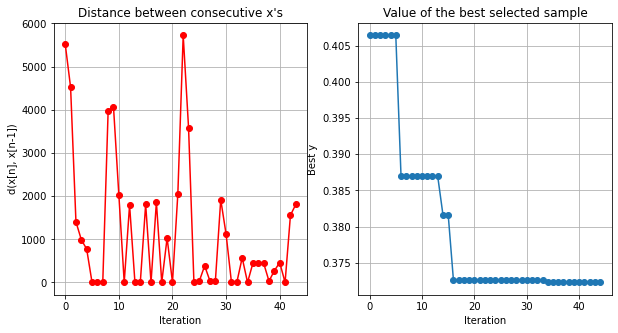

In [9]:
optimizer.plot_convergence()

In [10]:
[(bounds[i]['name'], optimum) for i, optimum in enumerate(optimizer.x_opt)]

[('learning_rate', 0.0027605806620987993),
 ('n_layers', 4.0),
 ('layer_size', 512.0),
 ('batch_size', 256.0)]

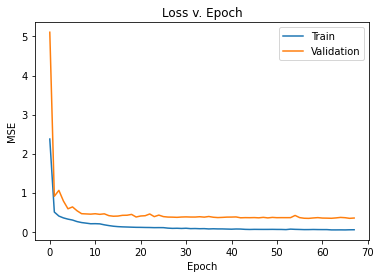

In [11]:
from matplotlib import pyplot as plt

plt.plot(best['history'].history['mse'], label='Train')
plt.plot(best['history'].history['val_mse'], label='Validation')

plt.title('Loss v. Epoch')
plt.ylabel('MSE')
plt.xlabel('Epoch')

plt.legend(loc='upper right')
plt.show()